In [2]:
import numpy as np
import string
import matplotlib.pyplot as plt
from imutils import face_utils
import os, cv2, dlib
import scipy.signal as signal
from scipy.ndimage import median_filter
import pandas as pd
from hdf5storage import loadmat, savemat

def makefiltersos(sr,fp,fs,gp=3,gs=20):
	""" 	Wrapper function around scipy filter functions.  
	Makes it convenient by providing frequency parameters in terms of 
	frequencies in Hz.   
	INPUT: 	sr - sampling rate in Hz. 
		fp - pass frequency in Hz
		fs - stop frequency in Hz
		gp - pass band ripple in dB, default 3 dB
		gs - stop band attenuation in dB, default 20 dB
		doPlot - make a plot of filter gain versus frequency, default 'no'
	OUTPUT: sos filter coefficients. 
			w,h for making bode plot 
	Automatically detects the type of filter.  if fp < fs the filter
	is low pass but if fp > fs the filter is highpass.  """
#
#set up filter parameters

	fn = sr/2
	wp = fp/fn
	ws = fs/fn
#get the filter order

	n,wn = signal.buttord(wp,ws,gp,gs);                                                            
#design the filter

#lowpass 
	if fp < fs:
		sos = signal.butter(n,wn,btype='lowpass',output='sos')
#highpass
	if fs < fp:
		sos = signal.butter(n,wn,btype='highpass',output='sos')
#get filter respons function	
	w,h = signal.sosfreqz(sos,fs=sr)
	return sos,w,h

def makeDummy(arr,mask):
    prac = []
    for i,j in zip(arr,mask):
        if j:
            prac.append(np.full_like(i,0))
        else:
            prac.append(i)
    return np.array(prac)

def getOutlier(roi_data,mask,varThresh):
    roi_data = makeDummy(roi_data,mask)
    # totalImages = len(roi_data)
    # trial_labeling = np.arange(0,len(roi_data))
    trialsVar = np.var(roi_data, axis = 1)
    stdTrials = np.std(trialsVar)
    medianVarTrials = np.median(trialsVar)
    trialOutlier = np.where(trialsVar > medianVarTrials + varThresh * stdTrials)[0]
    return trialsVar,stdTrials,medianVarTrials,trialOutlier

def removeOutlier(roi_data, invalidTrials,baselineIndx):
    trial_labeling = np.arange(0,len(roi_data))

    maskVarOutlier = ~np.isin(np.arange(roi_data.shape[0]), invalidTrials)
    trial_labeling_outlier_removed = trial_labeling[maskVarOutlier]
    # print(f'Data decreased from {len(trial_labeling)} to {len(trial_labeling_outlier_removed)}')

    roi_data_outlier_removed = roi_data[maskVarOutlier].copy()

    # plt.plot(np.mean(roi_data_outlier_removed, axis = 0) - np.mean(roi_data_outlier_removed[:, :baselineIndx]))
    # plt.ylabel('Temperature (Celcius)')
    # plt.xlabel('Frames')
    # plt.title('MeanTemperature (Baselined)')
    # plt.show()

    # plt.plot(roi_data_outlier_removed.T - np.mean(roi_data_outlier_removed[:, :baselineIndx]).T)
    # plt.ylabel('Temperature (Celcius)')
    # plt.xlabel('Frames')
    # plt.title('Temperature Trials (Baselined)')
    # plt.show()

    return roi_data_outlier_removed

def plotCleanup(trialsVar,medianVarTrials,stdTrials,varThresh = 3):
    plt.scatter(np.linspace(0, trialsVar.shape[0] - 1, trialsVar.shape[0]), trialsVar)
    plt.hlines(medianVarTrials + varThresh * stdTrials, 0, trialsVar.shape[0], colors="red")
    plt.ylabel('Variance')
    plt.xlabel('Trial')
    plt.title('Total variance in trial')
    plt.show()
    
def baselinecorrect(data,baselinesamps):
    base = np.mean(data[:,baselinesamps],axis = 1)
    print(data.shape)
    print(base.shape)
    nrows = np.size(data,axis=0)
    ncols = np.size(data,axis=1)
    databc = np.zeros((nrows,ncols))
    for j in range(nrows):
        databc[j,:] = data[j,:] - base[j]
    return databc

# def baselinecorrect(data,baselinesamps):
# 	""" 	Corrects for baseline offset in evoked potentials    
# 	INPUT: 	data is the data 
# 			baselinesamps is the indices of the samples to use as a baseline
# 			e.g., range(200)
# 	OUTPUT: databc baseline corrected data 
# 	Automatically calculates the mean of the baseline interval
# 	and then removes it from the timeseries """
# #
# #find the mean 
# 	base = np.mean(data[baselinesamps,:],axis = 0)
# 	nrows = np.size(data,axis = 0)	
# 	ncols = np.size(data,axis = 1)	
# 	databc = np.zeros((nrows,ncols))
# 	for j in range(ncols):
# 		databc[:,j] = data[:,j] - base[j]
# 	return databc

baselineIndx = 20

varThresh = 3

time = np.arange(-1000,10500,50)

In [4]:

sub = '10323'
ses = '3'
hiDef = False
path = f'../../thermal/Shane/Subject{sub}/{sub}Session{ses}/'

segmentData = loadmat(f'segmented/{sub}SS{ses}_segmented.hdf')
responsechoice = segmentData['choice']
stimresponsechoice = segmentData['pk_choice']
eegBadTrials = list(set(np.where(responsechoice == -1)[0]) | set(np.where(stimresponsechoice == -1)[0]))
mask = np.array([True if i in eegBadTrials else False for i in np.arange(298)])

In [5]:
detector = dlib.simple_object_detector(os.path.join("models/", "dlib_face_detector.svm"))
predictor = dlib.shape_predictor(os.path.join("models/", "dlib_landmark_predictor.dat"))

Logic for making region around ROI

In [13]:
keep_nose_roi_data = []
keep_forehead_roi_data = []
keep_left_cheek_roi_data = []
keep_right_cheek_roi_data = []
keep_bridge_roi_data = []
keep_room_temp_data = []
keepEegBadTrials = []

pass_nose_roi_data = []
pass_forehead_roi_data = []
pass_left_cheek_roi_data = []
pass_right_cheek_roi_data = []
pass_bridge_roi_data = []
pass_room_temp_data = []
passEegBadTrials = []

full_nose_roi_data = []
full_forehead_roi_data = []
full_left_cheek_roi_data = []
full_right_cheek_roi_data = []
full_bridge_roi_data = []
full_room_temp_data = []


full_eye_blinks = []

window_size = 15

# for nback task
# blocks = 10
# levels = 3

# for shanes thing?
numTrials = 300
# numTrials = 75
# images = 145
def fixEnd(arr):
    goodInd = 0
    for i,j in enumerate(arr):
        if j == 0:
            arr[i] = arr[goodInd]
        else:
            goodInd = i
    return arr

def extractWindow(region,window_size,thermalImages):
    rois = []
    for i,point in enumerate(region):
        if not np.all(point == 0):  # Skip if the point is [0, 0], indicating no face found
            roi_x = int(point[0]) - window_size // 2
            roi_y = int(point[1]) - window_size // 2
            # Apply a 5x5 median filter to smooth the image
            # smoothed_image = median_filter(thermalImages[i, :, :], size=(5,5))
            # roi = smoothed_image[roi_y:roi_y + window_size, roi_x:roi_x + window_size]
            roi = thermalImages[i, roi_y:roi_y + window_size, roi_x:roi_x + window_size]
        else:
            roi = np.zeros((window_size, window_size))  # Placeholder for no face

        rois.append(roi)

    rois = np.array(rois)
    timeseries = rois[:, :, :].mean(axis = (1, 2))

    return timeseries
    
# changed structure for shane
try:
    for trial in range(numTrials):
        title = 'Trial:' + str(trial)
    
        timeStamp = np.load(path + 'timeStamp/timeStampBlocktrial' + str(trial) + '.npy')
        timeStamp =  timeStamp / 10000000
        totalFrames = timeStamp.shape[0] #int(1.05 * 65 * 20)
        collectedFrames = totalFrames - np.sum(timeStamp == 0)
        # print(collectedFrames)
        if hiDef:
            thermalImages = np.load(path + 'images/imagesBlocktrial' + str(trial) + '.npy')/ 100 - 100 # 100 - 100 for high precision; 10 - 100 for low precision
        else:
            thermalImages = np.load(path + 'images/imagesBlocktrial' + str(trial) + '.npy')/ 10 - 100 # 100 - 100 for high precision; 10 - 100 for low precision
        thermalImages = thermalImages.reshape(-1, 288, 382)
    
        # collectedFrames = totalFrames - np.sum(timeStamp == 0)
        if collectedFrames < 160:
            images = 148
        elif collectedFrames < 230:
            images = 215
        
        left_brow = np.zeros([images, 2])
        right_brow = np.zeros([images, 2])
        nose_tip = np.zeros([images, 2])
        nose_bridge = np.zeros([images,2])
        left_cheek = np.zeros([images, 2])
        right_cheek = np.zeros([images, 2])
        left_eye = np.zeros([images,2])
        right_eye = np.zeros([images,2])
        left_corner = np.zeros([images, 2])
        right_corner = np.zeros([images, 2])
        print(title)
        
        # timeStamp = np.load(path + str(trial) + '.npy')
    
        # timeStamp =  timeStamp / 10000000
        # totalFrames = timeStamp.shape[0] #int(1.05 * 65 * 20)
        # collectedFrames = totalFrames - np.sum(timeStamp == 0)
        
    
        print('Total images in trial:', collectedFrames)
        
        for currentImage in range(images):
            thermalImage = thermalImages[currentImage, :, :]
            # min_temp = np.partition(x, 1)[0:2]
            # max_temp = 
            min_temp = np.min(thermalImage)
            max_temp = np.max(thermalImage)
    
            normalized_thermal_image = ((thermalImage - min_temp) / (max_temp - min_temp) * 255).astype(np.uint8)       
            rects = detector(normalized_thermal_image, upsample_num_times=1)
    
            if rects:
                (x, y, w, h) = face_utils.rect_to_bb(rects[0])
                shape = predictor(normalized_thermal_image, rects[0])
                shape = face_utils.shape_to_np(shape)
                for i, (sx, sy) in enumerate(shape):
                    coord = [int(sx), int(sy)]
                #     rx1 = int(sx) - window_size // 2
                #     ry1 = int(sy) - window_size // 2
                #     c1 = (rx1,ry1)
                #     c2 = (rx1+window_size,ry1+window_size)
                    cv2.circle(normalized_thermal_image, coord, 2, (0, 255, 0), -1)  # -1 for a filled circle
                # left brow
                coord = [int(shape[21][0]), int(shape[21][1])]
                left_brow[currentImage, :] = np.array(coord)
                lx = int(shape[21][0])
                ly = int(shape[21][1])

                # right brow
                coord = [int(shape[22][0]), int(shape[22][1])]
                right_brow[currentImage, :] = np.array(coord)
                rx = int(shape[22][0])
                ry = int(shape[22][1])
                bx = int((lx + rx) / 2) - window_size // 2
                by = int((ly + ry) / 2) - 5 * window_size // 4
                c1 = (bx,by)
                c2 = (bx+window_size,by+window_size)
                cv2.rectangle(normalized_thermal_image,c1,c2,(0, 0, 255))

                # nose bridge
                coord = [int(shape[28][0]), int(shape[28][1])]
                nose_bridge[currentImage, :] = np.array(coord)
                nx = int(shape[28][0]) - window_size // 2
                ny = int(shape[28][1]) - window_size // 2
                c1 = (nx,ny)
                c2 = (nx+window_size,ny+window_size)
                cv2.circle(normalized_thermal_image, coord, 2, (255, 255, 255),-1)
                cv2.rectangle(normalized_thermal_image,c1,c2,(0, 0, 255))

                # nose
                coord = [int(shape[30][0]), int(shape[30][1])]
                nose_tip[currentImage, :] = np.array(coord)
                nx = int(shape[30][0]) - window_size // 2
                ny = int(shape[30][1]) - window_size // 2
                c1 = (nx,ny)
                c2 = (nx+window_size,ny+window_size)
                cv2.circle(normalized_thermal_image, coord, 2, (255, 255, 255),-1)
                cv2.rectangle(normalized_thermal_image,c1,c2,(0, 0, 255))
            
                # left cheek
                # cv2.rectangle(normalized_thermal_image,(shape[5][0],shape[31][1]),(shape[48][0],shape[30][1]),(0, 0, 255))
                lchk = [int((shape[5][0] + shape[48][0])/2),int((shape[33][1] + shape[30][1])/2)]
                left_cheek[currentImage,:] = np.array(lchk)
                c1 = (lchk[0] - window_size//2, lchk[1] - window_size//2)
                c2 = (c1[0]+window_size, c1[1]+window_size)
                cv2.rectangle(normalized_thermal_image,c1,c2,(0, 0, 255))

                # right cheek
                # cv2.rectangle(normalized_thermal_image,(shape[11][0],shape[31][1]),(shape[50][0],shape[30][1]),(0, 0, 255))
                rchk = [int((shape[11][0] + shape[50][0])/2),int((shape[33][1] + shape[30][1])/2)]
                right_cheek[currentImage,:] = np.array(rchk)
                c1 = (rchk[0] - window_size//2, rchk[1] - window_size//2)
                c2 = (c1[0]+window_size, c1[1]+window_size)
                cv2.rectangle(normalized_thermal_image,c1,c2,(0, 0, 255))

                # left eye
                pts = np.array([shape[36:42]],
                   np.int32)
                pts = pts.reshape((-1, 1, 2))
                x = [j[0] for i in pts for j in i]
                y = [j[1] for i in pts for j in i]
                le = [int(np.mean(x)),int(np.mean(y))]
                left_eye[currentImage,:] = np.array(le)
                cv2.circle(normalized_thermal_image, le, 2, (0, 0, 255),-1)
    
                # right eye
                pts = np.array([shape[42:48]],
                   np.int32)
                pts = pts.reshape((-1, 1, 2))
                x = [j[0] for i in pts for j in i]
                y = [j[1] for i in pts for j in i]
                re = [int(np.mean(x)),int(np.mean(y))]
                right_eye[currentImage,:] = re
                cv2.circle(normalized_thermal_image, re, 2, (0, 0, 255),-1)

                # left corner
                c1 = (0,0)
                c2 = (20,20)
                lcoord = [int((c1[0]+c2[0])/2),int((c1[1]+c2[1])/2)]
                cv2.circle(normalized_thermal_image, lcoord, 2, (0, 255, 0),-1)  # -1 for a filled circle
                left_corner[currentImage, :] = np.array(lcoord)

                # right corner
                c1 = (382,0)
                c2 = (362,20)
                rcoord = [int((c1[0]+c2[0])/2),int((c1[1]+c2[1])/2)]
                cv2.circle(normalized_thermal_image, rcoord, 2, (0, 255, 0),-1)  # -1 for a filled circle
                right_corner[currentImage, :] = np.array(rcoord)
    
            else:
                print("dlib found no face")  
                ### try using previous?
    
            cv2.imshow('Image with Points', normalized_thermal_image)
            cv2.waitKey(10)
    
        # nose_timeseries = extractWindow(nose_tip,window_size,thermalImages)
        # bridge_timeseries = extractWindow(nose_bridge,window_size,thermalImages)
        # forehead_timeseries = extractWindow((left_brow + right_brow)/2,window_size,thermalImages)
        # left_cheek_timeseries = extractWindow(left_cheek,window_size,thermalImages)
        # right_cheek_timeseries = extractWindow(right_cheek,window_size,thermalImages)
        # left_eye_timeseries = extractWindow(left_eye,1,thermalImages)
        # right_eye_timeseries = extractWindow(right_eye,1,thermalImages)
        # right_corner_timeseries = extractWindow(right_corner,20,thermalImages)
        # left_corner_timeseries = extractWindow(left_corner,20,thermalImages)
        # room_timeseries = (right_corner_timeseries+left_corner_timeseries)/2

        # if 0 in room_timeseries:
        #     nose_timeseries = fixEnd(nose_timeseries)
        #     bridge_timeseries = fixEnd(bridge_timeseries)
        #     forehead_timeseries = fixEnd(forehead_timeseries)
        #     left_cheek_timeseries = fixEnd(left_cheek_timeseries)
        #     right_cheek_timeseries = fixEnd(right_cheek_timeseries)
        #     left_eye_timeseries = fixEnd(left_eye_timeseries)
        #     right_eye_timeseries = fixEnd(right_eye_timeseries)
        #     right_corner_timeseries = fixEnd(right_corner_timeseries)
        #     left_corner_timeseries = fixEnd(left_corner_timeseries)
        #     room_timeseries = (right_corner_timeseries+left_corner_timeseries)/2

        
        # if images == 148:
        #     if trial in eegBadTrials:
        #         keepEegBadTrials.append(True)
        #     else:
        #         keepEegBadTrials.append(False)
        #     keep_nose_roi_data.append(nose_timeseries)
        #     keep_bridge_roi_data.append(bridge_timeseries)
        #     keep_forehead_roi_data.append(forehead_timeseries)
        #     keep_left_cheek_roi_data.append(left_cheek_timeseries)
        #     keep_right_cheek_roi_data.append(right_cheek_timeseries)
        #     keep_room_temp_data.append(room_timeseries)

    
        # elif images == 215:
        #     if trial in eegBadTrials:
        #         passEegBadTrials.append(True)
        #     else:
        #         passEegBadTrials.append(False)
        #     pass_nose_roi_data.append(nose_timeseries)
        #     pass_bridge_roi_data.append(bridge_timeseries)
        #     pass_forehead_roi_data.append(forehead_timeseries)
        #     pass_left_cheek_roi_data.append(left_cheek_timeseries)
        #     pass_right_cheek_roi_data.append(right_cheek_timeseries)
        #     pass_room_temp_data.append(room_timeseries)
    
        # full_nose_roi_data.append(nose_timeseries)
        # full_bridge_roi_data.append(bridge_timeseries)
        # full_forehead_roi_data.append(forehead_timeseries)
        # full_left_cheek_roi_data.append(left_cheek_timeseries)
        # full_right_cheek_roi_data.append(right_cheek_timeseries)
        # full_room_temp_data.append(room_timeseries)
    
        # full_eye_blinks.append(eye_timeseries)
        # plt.plot(left_eye_timeseries)
        # plt.plot(right_eye_timeseries)
        # plt.plot((left_eye_timeseries + right_eye_timeseries)/2)
        # plt.title(title+' -Eye Mean')
        # plt.show()
    
        # plt.plot((left_eye_timeseries + right_eye_timeseries)/2,label='Eye')
        # # plt.plot(,label='R Eye')
        # plt.plot(bridge_timeseries,label = 'Bridge')
        # plt.plot(nose_timeseries, label = 'Nose')
        # # plt.plot()
        # # plt.ylim(0.5,1)
        # # plt.title(title + ' - Nose')
        # # plt.show()
        
        # plt.plot(forehead_timeseries,label = 'Forehead')
        # # plt.title(title + ' - Forehead')
        # # plt.show()
    
        # # plt.plot(left_cheek_timeseries,label='left')
        # # plt.plot(right_cheek_timeseries,label='right')
        # # plt.legend()
        # plt.plot((left_cheek_timeseries+right_cheek_timeseries)/2,label = 'Cheeks')
        # # plt.title(title + ' - Cheeks')
        # # plt.show()
        # plt.title(title)
        # plt.legend()
        # plt.show()
except FileNotFoundError:
    print(f'Ended at {trial}')
    
cv2.destroyAllWindows()


Trial:0
Total images in trial: 224


KeyboardInterrupt: 

: 

In [7]:

sub = '105'
ses = '4'
hiDef = False
path = f'../../thermal/Shane/Subject{sub}/{sub}Session{ses}/'

segmentData = loadmat(f'segmented/{sub}SS{ses}_segmented.hdf')
responsechoice = segmentData['choice']
stimresponsechoice = segmentData['pk_choice']
eegBadTrials = list(set(np.where(responsechoice == -1)[0]) | set(np.where(stimresponsechoice == -1)[0]))

keepEegBadTrials = []

passEegBadTrials = []

numTrials = 300



    
# changed structure for shane
try:
    for trial in range(numTrials):
        title = 'Trial:' + str(trial)
    
        timeStamp = np.load(path + 'timeStamp/timeStampBlocktrial' + str(trial) + '.npy')
        timeStamp =  timeStamp / 10000000
        totalFrames = timeStamp.shape[0] #int(1.05 * 65 * 20)
        collectedFrames = totalFrames - np.sum(timeStamp == 0)
    
        # collectedFrames = totalFrames - np.sum(timeStamp == 0)
        if collectedFrames < 160:
            images = 148
        elif collectedFrames < 230:
            images = 215
        
        

        
        if images == 148:
            if trial in eegBadTrials:
                keepEegBadTrials.append(True)
            else:
                keepEegBadTrials.append(False)


    
        elif images == 215:
            if trial in eegBadTrials:
                passEegBadTrials.append(True)
            else:
                passEegBadTrials.append(False)


        # plt.show()
except FileNotFoundError:
    print(f'Ended at {trial}')
    




Ended at 298


In [9]:
150 + 77

227

In [230]:
cv2.destroyAllWindows()
# passEegBadTrials = np.where(np.array(passEegBadTrials) == True)[0]
# keepEegBadTrials = np.where(np.array(keepEegBadTrials) == True)[0]

-1.027111111111111 -0.2426666666666648 -0.20088888888889045 -0.29288888888888565 0.18666666666666742


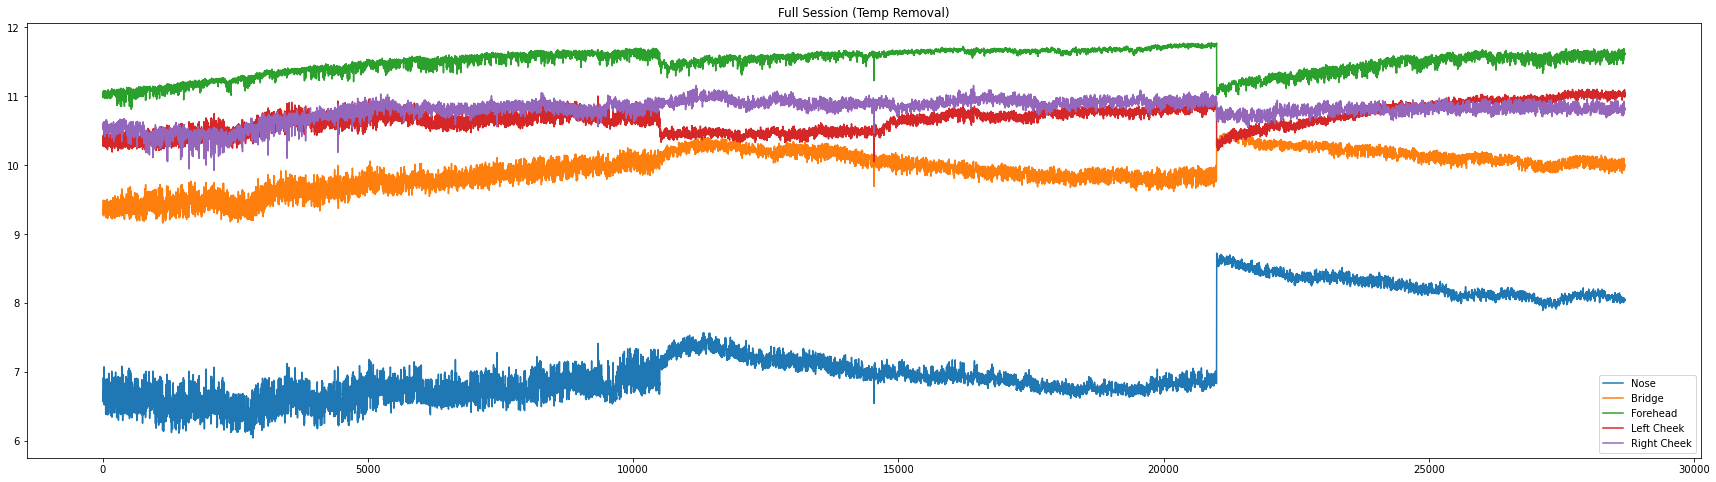

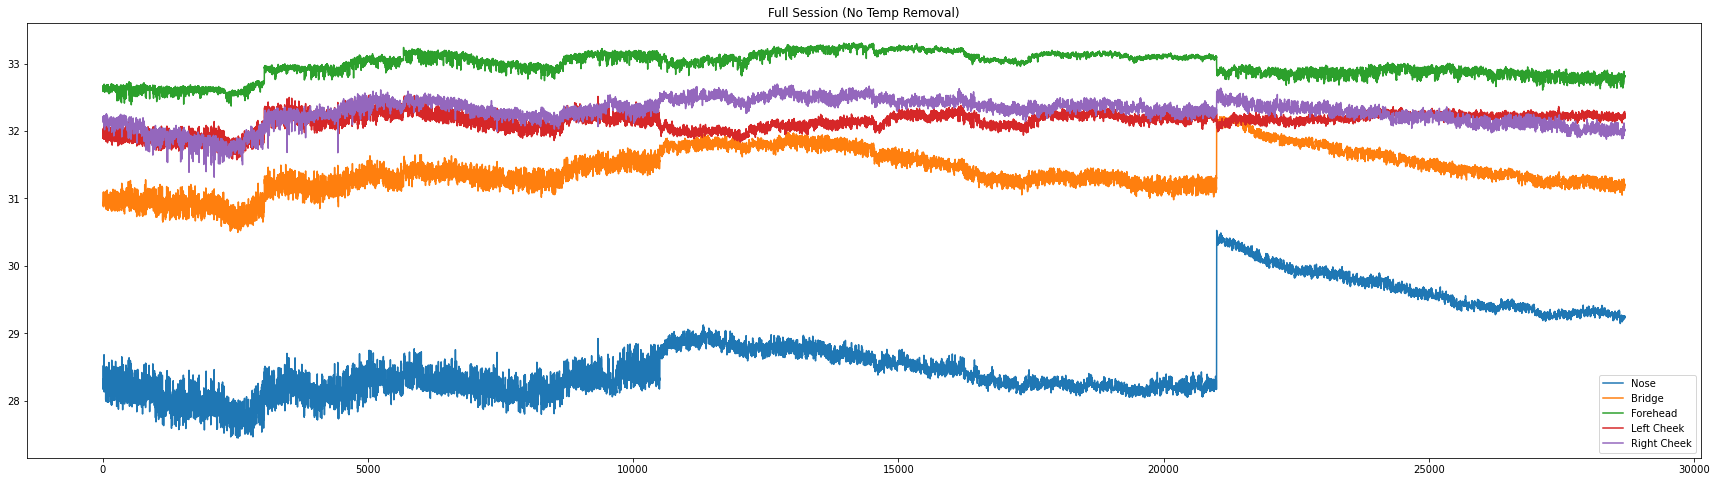

In [260]:
from scipy import ndimage
fullNose = [j for i in full_nose_roi_data for j in i]
fullBridge = [j for i in full_bridge_roi_data for j in i]
fullForehead = [j for i in full_forehead_roi_data for j in i]
fullLeftCheek = [j for i in full_left_cheek_roi_data for j in i]
fullRightCheek = [j for i in full_right_cheek_roi_data for j in i]
fullRoom = np.array([j for i in full_room_temp_data for j in i])
print(fullNose[0] - fullNose[-1]
    , fullBridge[0] - fullBridge[-1]
    , fullForehead[0] - fullForehead[-1]
    , fullLeftCheek[0]-fullLeftCheek[-1]
    , fullRightCheek[0]-fullRightCheek[-1])
# s1ts,s2ts,s3ts,s4ts
plt.figure(figsize=(30,8))
plt.plot(fullNose-fullRoom,label='Nose')
plt.plot(fullBridge-fullRoom,label='Bridge')
plt.plot(fullForehead-fullRoom,label='Forehead')
plt.plot(fullLeftCheek-fullRoom,label='Left Cheek')
plt.plot(fullRightCheek-fullRoom,label='Right Cheek')
plt.title('Full Session (Temp Removal)')
plt.legend()
# plt.vlines([s1ts,s1ts+s2ts,s1ts+s2ts+s3ts],tmin,tmax)
plt.show()
plt.figure(figsize=(30,8))
plt.plot(fullNose,label='Nose')
plt.plot(fullBridge,label='Bridge')
plt.plot(fullForehead,label='Forehead')
plt.plot(fullLeftCheek,label='Left Cheek')
plt.plot(fullRightCheek,label='Right Cheek')
plt.title('Full Session (No Temp Removal)')
plt.legend()
# plt.vlines([s1ts,s1ts+s2ts,s1ts+s2ts+s3ts],28,34)
plt.show()

In [261]:
# keep_nose_roi_data -= np.array(keep_room_temp_data)
# keep_bridge_roi_data -= np.array(keep_room_temp_data)
# keep_forehead_roi_data -= np.array(keep_room_temp_data)
# keep_left_cheek_roi_data -= np.array(keep_room_temp_data)
# keep_right_cheek_roi_data -= np.array(keep_room_temp_data)

# pass_nose_roi_data -= np.array(pass_room_temp_data)
# pass_bridge_roi_data -= np.array(pass_room_temp_data)
# pass_forehead_roi_data -= np.array(pass_room_temp_data)
# pass_left_cheek_roi_data -= np.array(pass_room_temp_data)
# pass_right_cheek_roi_data -= np.array(pass_room_temp_data)

##to undo change
# keep_nose_roi_data += keep_room_temp_data
# keep_bridge_roi_data += keep_room_temp_data
# keep_forehead_roi_data += keep_room_temp_data
# keep_left_cheek_roi_data += keep_room_temp_data
# keep_right_cheek_roi_data += keep_room_temp_data
# pass_nose_roi_data += pass_room_temp_data
# pass_bridge_roi_data += pass_room_temp_data
# pass_forehead_roi_data += pass_room_temp_data
# pass_left_cheek_roi_data += pass_room_temp_data
# pass_right_cheek_roi_data += pass_room_temp_data

In [262]:
## Make copy of data
# k_nose_orig= keep_nose_roi_data.copy()
# k_bridge_orig = keep_bridge_roi_data.copy()
# k_forehead_orig = keep_forehead_roi_data.copy()
# k_left_orig = keep_left_cheek_roi_data.copy()
# k_right_orig = keep_right_cheek_roi_data.copy()
# p_nose_orig = pass_nose_roi_data.copy()
# p_bridge_orig = pass_bridge_roi_data.copy()
# p_forehead_orig = pass_forehead_roi_data.copy()
# p_left_orig = pass_left_cheek_roi_data.copy()
# p_right_orig = pass_right_cheek_roi_data.copy()

## Remove invalid trials before outlier removal
# keep_nose_roi_data = np.array(keep_nose_roi_data)[~np.array(keepEegBadTrials)]
# keep_bridge_roi_data = np.array(keep_bridge_roi_data)[~np.array(keepEegBadTrials)]
# keep_forehead_roi_data = np.array(keep_forehead_roi_data)[~np.array(keepEegBadTrials)]
# keep_left_cheek_roi_data = np.array(keep_left_cheek_roi_data)[~np.array(keepEegBadTrials)]
# keep_right_cheek_roi_data = np.array(keep_right_cheek_roi_data)[~np.array(keepEegBadTrials)]

# pass_nose_roi_data = np.array(pass_nose_roi_data)[~np.array(passEegBadTrials),:]
# pass_bridge_roi_data = np.array(pass_bridge_roi_data)[~np.array(passEegBadTrials),:]
# pass_forehead_roi_data = np.array(pass_forehead_roi_data)[~np.array(passEegBadTrials),:]
# pass_left_cheek_roi_data = np.array(pass_left_cheek_roi_data)[~np.array(passEegBadTrials),:]
# pass_right_cheek_roi_data = np.array(pass_right_cheek_roi_data)[~np.array(passEegBadTrials),:]


In [278]:
# mask = keepEegBadTrials


array([[21.616125, 21.62175 , 21.603   , ..., 21.57175 , 21.608375,
        21.60175 ],
       [21.6005  , 21.622125, 21.598125, ..., 21.551375, 21.550375,
        21.555   ],
       [21.56775 , 21.566   , 21.55875 , ..., 21.589   , 21.572   ,
        21.562625],
       ...,
       [21.212125, 21.221625, 21.203625, ..., 21.216625, 21.205375,
        21.205125],
       [21.208375, 21.197   , 21.189625, ..., 21.2115  , 21.191875,
        21.201125],
       [21.2165  , 21.190625, 21.186625, ..., 21.197875, 21.202625,
        21.193   ]])

In [264]:
full_nose_roi_data = np.array([i[:140] for i in full_nose_roi_data])
full_bridge_roi_data = np.array([i[:140] for i in full_bridge_roi_data])
full_forehead_roi_data = np.array([i[:140] for i in full_forehead_roi_data])
full_left_cheek_roi_data = np.array([i[:140] for i in full_left_cheek_roi_data])
full_right_cheek_roi_data = np.array([i[:140] for i in full_right_cheek_roi_data])
full_room_temp_data = np.array([i[:140] for i in full_room_temp_data])

# full_nose_roi_data -= full_room_temp_data
# full_bridge_roi_data-= full_room_temp_data
# full_forehead_roi_data -= full_room_temp_data
# full_left_cheek_roi_data -= full_room_temp_data
# full_right_cheek_roi_data -= full_room_temp_data

# full_nose_roi_data += full_room_temp_data
# full_bridge_roi_data += full_room_temp_data
# full_forehead_roi_data += full_room_temp_data
# full_left_cheek_roi_data += full_room_temp_data
# full_right_cheek_roi_data += full_room_temp_data
full_cheek_roi_data = (full_left_cheek_roi_data + full_right_cheek_roi_data)/2

In [265]:
### outlier remove -> baseline -> split condition

## outlier remove
noseTrialsVar,stdNoseTrials,medianVarNoseTrials,noseTrialOutlier = getOutlier(np.array(full_nose_roi_data),mask,varThresh)
foreheadTrialsVar,stdForeheadTrials,medianVarForeheadTrials,foreheadTrialOutlier = getOutlier(np.array(full_forehead_roi_data),mask,varThresh)
cheekTrialsVar,stdCheekTrials,medianVarCheekTrials,cheekTrialOutlier = getOutlier(np.array(full_cheek_roi_data),mask,varThresh)

invalidTrials= np.unique(np.concatenate((noseTrialOutlier,foreheadTrialOutlier,cheekTrialOutlier,eegBadTrials)))
validTrialInd = np.array([i for i in np.arange(full_room_temp_data.shape[0]) if i not in invalidTrials])
validPk = stimresponsechoice[validTrialInd]

# Nose
print('Nose')
nose_roi_data_outlier_removed = removeOutlier(np.array(full_nose_roi_data), invalidTrials,baselineIndx)
# plotCleanup(noseTrialsVar,medianVarNoseTrials, stdNoseTrials,varThresh = 3)

# Forehead
print('Forehead')
forehead_roi_data_outlier_removed = removeOutlier(np.array(full_forehead_roi_data), invalidTrials,baselineIndx)
# plotCleanup(foreheadTrialsVar,medianVarForeheadTrials, stdForeheadTrials,varThresh = 3)

# Cheek
print('Cheek')
cheek_roi_data_outlier_removed = removeOutlier(np.array(full_cheek_roi_data), invalidTrials,baselineIndx)
# plotCleanup(cheekTrialsVar,medianVarCheekTrials, stdCheekTrials,varThresh = 3)


# keepNoseTrials = nose_roi_data_outlier_removed - np.mean(nose_roi_data_outlier_removed[:, :baselineIndx])
# keepForeheadTrials = forehead_roi_data_outlier_removed - np.mean(forehead_roi_data_outlier_removed[:, :baselineIndx])
# keepLeftTrials = left_roi_data_outlier_removed - np.mean(left_roi_data_outlier_removed[:, :baselineIndx])
# keepRightTrials = right_roi_data_outlier_removed - np.mean(right_roi_data_outlier_removed[:, :baselineIndx])

## baseline
bsnose = baselinecorrect(nose_roi_data_outlier_removed,range(20))
bsfore = baselinecorrect(forehead_roi_data_outlier_removed,range(20))
bscheek = baselinecorrect(cheek_roi_data_outlier_removed,range(20))

bsnose = np.array(pd.DataFrame(bsnose).T.rolling(window=5).median().T) 
bsfore = np.array(pd.DataFrame(bsfore).T.rolling(window=5).median().T) 
bscheek = np.array(pd.DataFrame(bscheek).T.rolling(window=5).median().T)

# keepNoseTrials = bsnose
# keepForeheadTrials = bsfore
# keepLeftTrials = bsleft
# keepRightTrials = bsright
noseTrials = np.round(bsnose, 2)
foreheadTrials = np.round(bsfore, 2)
cheekTrials = np.round(bscheek,2)

## split condition
# nose
keepNose = noseTrials[np.where(validPk == 1)[0],:]
passNose = noseTrials[np.where(validPk == 0)[0],:]
# forehead
keepForehead = foreheadTrials[np.where(validPk == 1)[0],:]
passForehead = foreheadTrials[np.where(validPk == 0)[0],:]
# cheek
keepCheek = cheekTrials[np.where(validPk == 1)[0],:]
passCheek = cheekTrials[np.where(validPk == 0)[0],:]


Nose
Forehead
Cheek
(190, 140)
(190,)
(190, 140)
(190,)
(190, 140)
(190,)


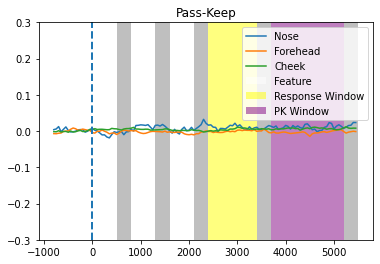

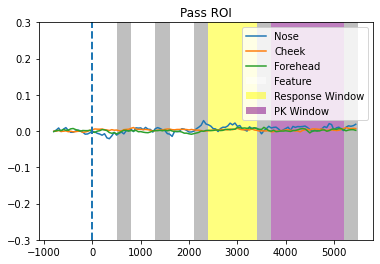

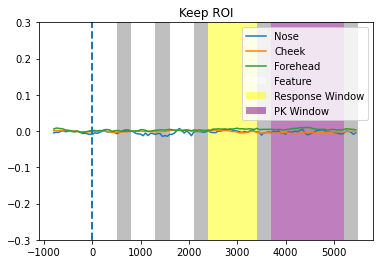

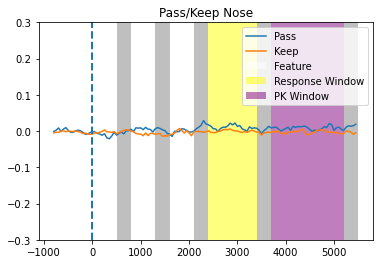

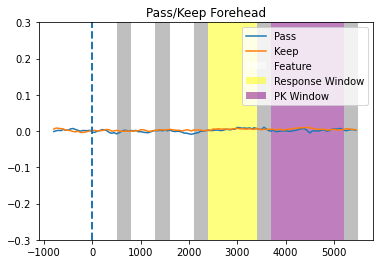

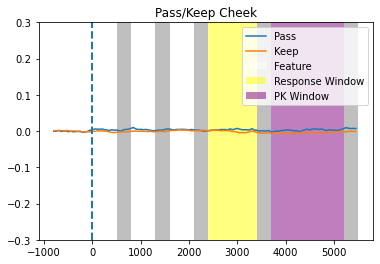

In [266]:
plt.plot(time[:130],(np.mean(passNose,axis=0)[:130] - np.mean(keepNose,axis=0)[:130]),label='Nose')
plt.plot(time[:130],(np.mean(passForehead,axis=0)[:130] - np.mean(keepForehead,axis=0)[:130]),label='Forehead')
plt.plot(time[:130],(np.mean(passCheek,axis=0)[:130] - np.mean(keepCheek,axis=0)[:130]),label='Cheek')
plt.axvline(x=0,linestyle = '--',lw=2)
plt.axvspan(500,800,color = 'gray', alpha=0.5, lw=0)
plt.axvspan(1300,1600,color = 'gray', alpha=0.5, lw=0)
plt.axvspan(2100,2400,color = 'gray', alpha=0.5, lw=0)
plt.axvspan(3400,3700,color = 'gray', alpha=0.5, lw=0)
plt.axvspan(5200,5500,color = 'gray', alpha=0.5, lw=0)

plt.axvspan(0,500,color = 'white', alpha=0.5, lw=0)
plt.axvspan(800,1300,color = 'white', alpha=0.5, lw=0)
plt.axvspan(1600,2100,color = 'white', alpha=0.5, lw=0,label='Feature')
plt.axvspan(2400,3400,color = 'yellow', alpha=0.5, lw=0,label = 'Response Window')
plt.axvspan(3700,5200,color = 'purple', alpha=0.5, lw=0,label = 'PK Window')
plt.title('Pass-Keep')
plt.legend()
plt.ylim(-0.3,0.3)
plt.show()

plt.plot(time[:130],(np.mean(passNose,axis=0)[:130]),label='Nose')
plt.plot(time[:130],(np.mean(passCheek,axis=0)[:130]),label='Cheek')
plt.plot(time[:130],(np.mean(passForehead,axis=0)[:130]),label='Forehead')
plt.axvline(x=0,linestyle = '--',lw=2)
plt.axvspan(500,800,color = 'gray', alpha=0.5, lw=0)
plt.axvspan(1300,1600,color = 'gray', alpha=0.5, lw=0)
plt.axvspan(2100,2400,color = 'gray', alpha=0.5, lw=0)
plt.axvspan(3400,3700,color = 'gray', alpha=0.5, lw=0)
plt.axvspan(5200,5500,color = 'gray', alpha=0.5, lw=0)

plt.axvspan(0,500,color = 'white', alpha=0.5, lw=0)
plt.axvspan(800,1300,color = 'white', alpha=0.5, lw=0)
plt.axvspan(1600,2100,color = 'white', alpha=0.5, lw=0,label='Feature')
plt.axvspan(2400,3400,color = 'yellow', alpha=0.5, lw=0,label = 'Response Window')
plt.axvspan(3700,5200,color = 'purple', alpha=0.5, lw=0,label = 'PK Window')
plt.title('Pass ROI')
plt.legend()
plt.ylim(-0.3,0.3)
plt.show()

plt.plot(time[:130],(np.mean(keepNose,axis=0)[:130]),label='Nose')
plt.plot(time[:130],(np.mean(keepCheek,axis=0)[:130]),label='Cheek')
plt.plot(time[:130],(np.mean(keepForehead,axis=0)[:130]),label='Forehead')
plt.axvline(x=0,linestyle = '--',lw=2)
plt.axvspan(500,800,color = 'gray', alpha=0.5, lw=0)
plt.axvspan(1300,1600,color = 'gray', alpha=0.5, lw=0)
plt.axvspan(2100,2400,color = 'gray', alpha=0.5, lw=0)
plt.axvspan(3400,3700,color = 'gray', alpha=0.5, lw=0)
plt.axvspan(5200,5500,color = 'gray', alpha=0.5, lw=0)

plt.axvspan(0,500,color = 'white', alpha=0.5, lw=0)
plt.axvspan(800,1300,color = 'white', alpha=0.5, lw=0)
plt.axvspan(1600,2100,color = 'white', alpha=0.5, lw=0,label='Feature')
plt.axvspan(2400,3400,color = 'yellow', alpha=0.5, lw=0,label = 'Response Window')
plt.axvspan(3700,5200,color = 'purple', alpha=0.5, lw=0,label = 'PK Window')
plt.title('Keep ROI')
plt.legend()
plt.ylim(-0.3,0.3)
plt.show()

plt.plot(time[:130],(np.mean(passNose,axis=0)[:130]),label='Pass')
plt.plot(time[:130],(np.mean(keepNose,axis=0)[:130]),label='Keep')
plt.axvline(x=0,linestyle = '--',lw=2)
plt.axvspan(500,800,color = 'gray', alpha=0.5, lw=0)
plt.axvspan(1300,1600,color = 'gray', alpha=0.5, lw=0)
plt.axvspan(2100,2400,color = 'gray', alpha=0.5, lw=0)
plt.axvspan(3400,3700,color = 'gray', alpha=0.5, lw=0)
plt.axvspan(5200,5500,color = 'gray', alpha=0.5, lw=0)

plt.axvspan(0,500,color = 'white', alpha=0.5, lw=0)
plt.axvspan(800,1300,color = 'white', alpha=0.5, lw=0)
plt.axvspan(1600,2100,color = 'white', alpha=0.5, lw=0,label='Feature')
plt.axvspan(2400,3400,color = 'yellow', alpha=0.5, lw=0,label = 'Response Window')
plt.axvspan(3700,5200,color = 'purple', alpha=0.5, lw=0,label = 'PK Window')
plt.title('Pass/Keep Nose')
plt.legend()
plt.ylim(-0.3,0.3)
plt.show()

plt.plot(time[:130],(np.mean(passForehead,axis=0)[:130]),label='Pass')
plt.plot(time[:130],(np.mean(keepForehead,axis=0)[:130]),label='Keep')
plt.axvline(x=0,linestyle = '--',lw=2)
plt.axvspan(500,800,color = 'gray', alpha=0.5, lw=0)
plt.axvspan(1300,1600,color = 'gray', alpha=0.5, lw=0)
plt.axvspan(2100,2400,color = 'gray', alpha=0.5, lw=0)
plt.axvspan(3400,3700,color = 'gray', alpha=0.5, lw=0)
plt.axvspan(5200,5500,color = 'gray', alpha=0.5, lw=0)

plt.axvspan(0,500,color = 'white', alpha=0.5, lw=0)
plt.axvspan(800,1300,color = 'white', alpha=0.5, lw=0)
plt.axvspan(1600,2100,color = 'white', alpha=0.5, lw=0,label='Feature')
plt.axvspan(2400,3400,color = 'yellow', alpha=0.5, lw=0,label = 'Response Window')
plt.axvspan(3700,5200,color = 'purple', alpha=0.5, lw=0,label = 'PK Window')
plt.title('Pass/Keep Forehead')
plt.legend()
plt.ylim(-0.3,0.3)
plt.show()

plt.plot(time[:130],(np.mean(passCheek,axis=0)[:130]),label='Pass')
plt.plot(time[:130],(np.mean(keepCheek,axis=0)[:130]),label='Keep')
plt.axvline(x=0,linestyle = '--',lw=2)
plt.axvspan(500,800,color = 'gray', alpha=0.5, lw=0)
plt.axvspan(1300,1600,color = 'gray', alpha=0.5, lw=0)
plt.axvspan(2100,2400,color = 'gray', alpha=0.5, lw=0)
plt.axvspan(3400,3700,color = 'gray', alpha=0.5, lw=0)
plt.axvspan(5200,5500,color = 'gray', alpha=0.5, lw=0)

plt.axvspan(0,500,color = 'white', alpha=0.5, lw=0)
plt.axvspan(800,1300,color = 'white', alpha=0.5, lw=0)
plt.axvspan(1600,2100,color = 'white', alpha=0.5, lw=0,label='Feature')
plt.axvspan(2400,3400,color = 'yellow', alpha=0.5, lw=0,label = 'Response Window')
plt.axvspan(3700,5200,color = 'purple', alpha=0.5, lw=0,label = 'PK Window')
plt.title('Pass/Keep Cheek')
plt.legend()
plt.ylim(-0.3,0.3)
plt.show()

In [267]:
## outlier remove -> split condition -> baseline

## outlier remove
noseTrialsVar,stdNoseTrials,medianVarNoseTrials,noseTrialOutlier = getOutlier(np.array(full_nose_roi_data),mask,varThresh)
foreheadTrialsVar,stdForeheadTrials,medianVarForeheadTrials,foreheadTrialOutlier = getOutlier(np.array(full_forehead_roi_data),mask,varThresh)
cheekTrialsVar,stdCheekTrials,medianVarCheekTrials,cheekTrialOutlier = getOutlier(np.array(full_cheek_roi_data),mask,varThresh)

invalidTrials= np.unique(np.concatenate((noseTrialOutlier,foreheadTrialOutlier,cheekTrialOutlier,eegBadTrials)))
validTrialInd = np.array([i for i in np.arange(300) if i not in invalidTrials])
validPk = stimresponsechoice[validTrialInd]

# Nose
print('Nose')
nose_roi_data_outlier_removed = removeOutlier(np.array(full_nose_roi_data), invalidTrials,baselineIndx)
plotCleanup(noseTrialsVar,medianVarNoseTrials, stdNoseTrials,varThresh = 3)

# Forehead
print('Forehead')
forehead_roi_data_outlier_removed = removeOutlier(np.array(full_forehead_roi_data), invalidTrials,baselineIndx)
plotCleanup(foreheadTrialsVar,medianVarForeheadTrials, stdForeheadTrials,varThresh = 3)

# Cheek
print('Cheek')
cheek_roi_data_outlier_removed = removeOutlier(np.array(full_cheek_roi_data), invalidTrials,baselineIndx)
plotCleanup(cheekTrialsVar,medianVarCheekTrials, stdCheekTrials,varThresh = 3)
## split condition
# nose
keepNose = nose_roi_data_outlier_removed[np.where(validPk == 1)[0],:]
passNose = nose_roi_data_outlier_removed[np.where(validPk == 0)[0],:]
# forehead
keepForehead = forehead_roi_data_outlier_removed[np.where(validPk == 1)[0],:]
passForehead = forehead_roi_data_outlier_removed[np.where(validPk == 0)[0],:]
# cheek
keepCheek = cheek_roi_data_outlier_removed[np.where(validPk == 1)[0],:]
passCheek = cheek_roi_data_outlier_removed[np.where(validPk == 0)[0],:]

# keepNoseTrials = nose_roi_data_outlier_removed - np.mean(nose_roi_data_outlier_removed[:, :baselineIndx])
# keepForeheadTrials = forehead_roi_data_outlier_removed - np.mean(forehead_roi_data_outlier_removed[:, :baselineIndx])
# keepLeftTrials = left_roi_data_outlier_removed - np.mean(left_roi_data_outlier_removed[:, :baselineIndx])
# keepRightTrials = right_roi_data_outlier_removed - np.mean(right_roi_data_outlier_removed[:, :baselineIndx])

## baseline
keepNose = baselinecorrect(keepNose,range(20))
passNose = baselinecorrect(passNose,range(20))

keepForehead = baselinecorrect(keepForehead,range(20))
passForehead = baselinecorrect(passForehead,range(20))

keepCheek = baselinecorrect(keepCheek,range(20))
passCheek = baselinecorrect(passCheek,range(20))

keepNose = np.array(pd.DataFrame(keepNose).T.rolling(window=5).median().T) 
passNose = np.array(pd.DataFrame(passNose).T.rolling(window=5).median().T) 
keepForehead = np.array(pd.DataFrame(keepForehead).T.rolling(window=5).median().T) 
passForehead = np.array(pd.DataFrame(passForehead).T.rolling(window=5).median().T) 
keepCheek = np.array(pd.DataFrame(keepCheek).T.rolling(window=5).median().T) 
passCheek = np.array(pd.DataFrame(passCheek).T.rolling(window=5).median().T) 


keepNose = np.round(keepNose, 2)
passNose = np.round(passNose,2)
keepForehead = np.round(keepForehead, 2)
passForehead = np.round(passForehead,2)
keepCheek = np.round(keepCheek, 2)
passCheek = np.round(passCheek,2)


IndexError: index 225 is out of bounds for axis 0 with size 225

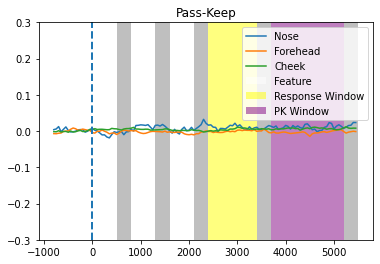

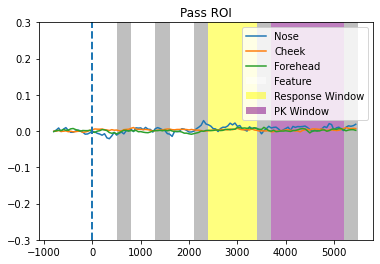

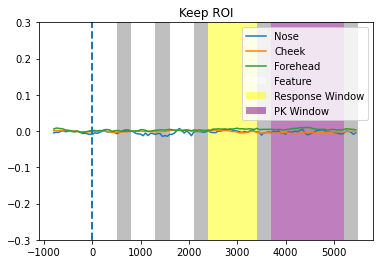

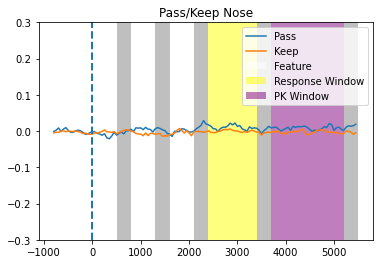

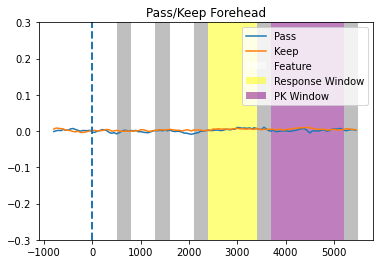

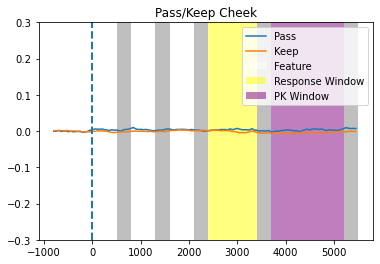

In [268]:
plt.plot(time[:130],(np.mean(passNose,axis=0)[:130] - np.mean(keepNose,axis=0)[:130]),label='Nose')
plt.plot(time[:130],(np.mean(passForehead,axis=0)[:130] - np.mean(keepForehead,axis=0)[:130]),label='Forehead')
plt.plot(time[:130],(np.mean(passCheek,axis=0)[:130] - np.mean(keepCheek,axis=0)[:130]),label='Cheek')
plt.axvline(x=0,linestyle = '--',lw=2)
plt.axvspan(500,800,color = 'gray', alpha=0.5, lw=0)
plt.axvspan(1300,1600,color = 'gray', alpha=0.5, lw=0)
plt.axvspan(2100,2400,color = 'gray', alpha=0.5, lw=0)
plt.axvspan(3400,3700,color = 'gray', alpha=0.5, lw=0)
plt.axvspan(5200,5500,color = 'gray', alpha=0.5, lw=0)

plt.axvspan(0,500,color = 'white', alpha=0.5, lw=0)
plt.axvspan(800,1300,color = 'white', alpha=0.5, lw=0)
plt.axvspan(1600,2100,color = 'white', alpha=0.5, lw=0,label='Feature')
plt.axvspan(2400,3400,color = 'yellow', alpha=0.5, lw=0,label = 'Response Window')
plt.axvspan(3700,5200,color = 'purple', alpha=0.5, lw=0,label = 'PK Window')
plt.title('Pass-Keep')
plt.legend()
plt.ylim(-0.3,0.3)
plt.show()

plt.plot(time[:130],(np.mean(passNose,axis=0)[:130]),label='Nose')
plt.plot(time[:130],(np.mean(passCheek,axis=0)[:130]),label='Cheek')
plt.plot(time[:130],(np.mean(passForehead,axis=0)[:130]),label='Forehead')
plt.axvline(x=0,linestyle = '--',lw=2)
plt.axvspan(500,800,color = 'gray', alpha=0.5, lw=0)
plt.axvspan(1300,1600,color = 'gray', alpha=0.5, lw=0)
plt.axvspan(2100,2400,color = 'gray', alpha=0.5, lw=0)
plt.axvspan(3400,3700,color = 'gray', alpha=0.5, lw=0)
plt.axvspan(5200,5500,color = 'gray', alpha=0.5, lw=0)

plt.axvspan(0,500,color = 'white', alpha=0.5, lw=0)
plt.axvspan(800,1300,color = 'white', alpha=0.5, lw=0)
plt.axvspan(1600,2100,color = 'white', alpha=0.5, lw=0,label='Feature')
plt.axvspan(2400,3400,color = 'yellow', alpha=0.5, lw=0,label = 'Response Window')
plt.axvspan(3700,5200,color = 'purple', alpha=0.5, lw=0,label = 'PK Window')
plt.title('Pass ROI')
plt.legend()
plt.ylim(-0.3,0.3)
plt.show()

plt.plot(time[:130],(np.mean(keepNose,axis=0)[:130]),label='Nose')
plt.plot(time[:130],(np.mean(keepCheek,axis=0)[:130]),label='Cheek')
plt.plot(time[:130],(np.mean(keepForehead,axis=0)[:130]),label='Forehead')
plt.axvline(x=0,linestyle = '--',lw=2)
plt.axvspan(500,800,color = 'gray', alpha=0.5, lw=0)
plt.axvspan(1300,1600,color = 'gray', alpha=0.5, lw=0)
plt.axvspan(2100,2400,color = 'gray', alpha=0.5, lw=0)
plt.axvspan(3400,3700,color = 'gray', alpha=0.5, lw=0)
plt.axvspan(5200,5500,color = 'gray', alpha=0.5, lw=0)

plt.axvspan(0,500,color = 'white', alpha=0.5, lw=0)
plt.axvspan(800,1300,color = 'white', alpha=0.5, lw=0)
plt.axvspan(1600,2100,color = 'white', alpha=0.5, lw=0,label='Feature')
plt.axvspan(2400,3400,color = 'yellow', alpha=0.5, lw=0,label = 'Response Window')
plt.axvspan(3700,5200,color = 'purple', alpha=0.5, lw=0,label = 'PK Window')
plt.title('Keep ROI')
plt.legend()
plt.ylim(-0.3,0.3)
plt.show()

plt.plot(time[:130],(np.mean(passNose,axis=0)[:130]),label='Pass')
plt.plot(time[:130],(np.mean(keepNose,axis=0)[:130]),label='Keep')
plt.axvline(x=0,linestyle = '--',lw=2)
plt.axvspan(500,800,color = 'gray', alpha=0.5, lw=0)
plt.axvspan(1300,1600,color = 'gray', alpha=0.5, lw=0)
plt.axvspan(2100,2400,color = 'gray', alpha=0.5, lw=0)
plt.axvspan(3400,3700,color = 'gray', alpha=0.5, lw=0)
plt.axvspan(5200,5500,color = 'gray', alpha=0.5, lw=0)

plt.axvspan(0,500,color = 'white', alpha=0.5, lw=0)
plt.axvspan(800,1300,color = 'white', alpha=0.5, lw=0)
plt.axvspan(1600,2100,color = 'white', alpha=0.5, lw=0,label='Feature')
plt.axvspan(2400,3400,color = 'yellow', alpha=0.5, lw=0,label = 'Response Window')
plt.axvspan(3700,5200,color = 'purple', alpha=0.5, lw=0,label = 'PK Window')
plt.title('Pass/Keep Nose')
plt.legend()
plt.ylim(-0.3,0.3)
plt.show()

plt.plot(time[:130],(np.mean(passForehead,axis=0)[:130]),label='Pass')
plt.plot(time[:130],(np.mean(keepForehead,axis=0)[:130]),label='Keep')
plt.axvline(x=0,linestyle = '--',lw=2)
plt.axvspan(500,800,color = 'gray', alpha=0.5, lw=0)
plt.axvspan(1300,1600,color = 'gray', alpha=0.5, lw=0)
plt.axvspan(2100,2400,color = 'gray', alpha=0.5, lw=0)
plt.axvspan(3400,3700,color = 'gray', alpha=0.5, lw=0)
plt.axvspan(5200,5500,color = 'gray', alpha=0.5, lw=0)

plt.axvspan(0,500,color = 'white', alpha=0.5, lw=0)
plt.axvspan(800,1300,color = 'white', alpha=0.5, lw=0)
plt.axvspan(1600,2100,color = 'white', alpha=0.5, lw=0,label='Feature')
plt.axvspan(2400,3400,color = 'yellow', alpha=0.5, lw=0,label = 'Response Window')
plt.axvspan(3700,5200,color = 'purple', alpha=0.5, lw=0,label = 'PK Window')
plt.title('Pass/Keep Forehead')
plt.legend()
plt.ylim(-0.3,0.3)
plt.show()

plt.plot(time[:130],(np.mean(passCheek,axis=0)[:130]),label='Pass')
plt.plot(time[:130],(np.mean(keepCheek,axis=0)[:130]),label='Keep')
plt.axvline(x=0,linestyle = '--',lw=2)
plt.axvspan(500,800,color = 'gray', alpha=0.5, lw=0)
plt.axvspan(1300,1600,color = 'gray', alpha=0.5, lw=0)
plt.axvspan(2100,2400,color = 'gray', alpha=0.5, lw=0)
plt.axvspan(3400,3700,color = 'gray', alpha=0.5, lw=0)
plt.axvspan(5200,5500,color = 'gray', alpha=0.5, lw=0)

plt.axvspan(0,500,color = 'white', alpha=0.5, lw=0)
plt.axvspan(800,1300,color = 'white', alpha=0.5, lw=0)
plt.axvspan(1600,2100,color = 'white', alpha=0.5, lw=0,label='Feature')
plt.axvspan(2400,3400,color = 'yellow', alpha=0.5, lw=0,label = 'Response Window')
plt.axvspan(3700,5200,color = 'purple', alpha=0.5, lw=0,label = 'PK Window')
plt.title('Pass/Keep Cheek')
plt.legend()
plt.ylim(-0.3,0.3)
plt.show()

In [269]:
## split condition -> outlier remove -> baseline

## split condition
# nose
keepNose = np.array(full_nose_roi_data)[np.where(stimresponsechoice == 1)[0],:]
passNose = np.array(full_nose_roi_data)[np.where(stimresponsechoice == 0)[0],:]
# forehead
keepForehead = np.array(full_forehead_roi_data)[np.where(stimresponsechoice == 1)[0],:]
passForehead = np.array(full_forehead_roi_data)[np.where(stimresponsechoice == 0)[0],:]
# cheek
keepCheek = np.array(full_cheek_roi_data)[np.where(stimresponsechoice == 1)[0],:]
passCheek = np.array(full_cheek_roi_data)[np.where(stimresponsechoice == 0)[0],:]



## outlier remove
maskShape = np.where(stimresponsechoice == 1)[0].shape[0]
noseTrialsVar,stdNoseTrials,medianVarNoseTrials,noseTrialOutlier = getOutlier(keepNose,np.full(maskShape,False),varThresh)
foreheadTrialsVar,stdForeheadTrials,medianVarForeheadTrials,foreheadTrialOutlier = getOutlier(keepForehead,np.full(maskShape,False),varThresh)
cheekTrialsVar,stdCheekTrials,medianVarCheekTrials,cheekTrialOutlier = getOutlier(keepCheek,np.full(maskShape,False),varThresh)

invalidTrials= np.unique(np.concatenate((noseTrialOutlier,foreheadTrialOutlier,cheekTrialOutlier)))
validTrialInd = np.array([i for i in np.arange(maskShape) if i not in invalidTrials])
validKeep = np.where(stimresponsechoice == 1)[0][validTrialInd]

# Nose
keepNose = removeOutlier(keepNose, invalidTrials,baselineIndx)
# plotCleanup(noseTrialsVar,medianVarNoseTrials, stdNoseTrials,varThresh = 3)

# Forehead
keepForehead = removeOutlier(keepForehead, invalidTrials,baselineIndx)
# plotCleanup(foreheadTrialsVar,medianVarForeheadTrials, stdForeheadTrials,varThresh = 3)

# Cheek
keepCheek = removeOutlier(keepCheek, invalidTrials,baselineIndx)
# plotCleanup(cheekTrialsVar,medianVarCheekTrials, stdCheekTrials,varThresh = 3)

maskShape = np.where(stimresponsechoice == 0)[0].shape[0]
noseTrialsVar,stdNoseTrials,medianVarNoseTrials,noseTrialOutlier = getOutlier(passNose,np.full(maskShape,False),varThresh)
foreheadTrialsVar,stdForeheadTrials,medianVarForeheadTrials,foreheadTrialOutlier = getOutlier(passForehead,np.full(maskShape,False),varThresh)
cheekTrialsVar,stdCheekTrials,medianVarCheekTrials,cheekTrialOutlier = getOutlier(passCheek,np.full(maskShape,False),varThresh)

invalidTrials= np.unique(np.concatenate((noseTrialOutlier,foreheadTrialOutlier,cheekTrialOutlier)))
validTrialInd = np.array([i for i in np.arange(maskShape) if i not in invalidTrials])
validPass = np.where(stimresponsechoice == 0)[0][validTrialInd]

# Nose
passNose = removeOutlier(passNose, invalidTrials,baselineIndx)
# plotCleanup(noseTrialsVar,medianVarNoseTrials, stdNoseTrials,varThresh = 3)

# Forehead
passForehead = removeOutlier(passForehead, invalidTrials,baselineIndx)
# plotCleanup(foreheadTrialsVar,medianVarForeheadTrials, stdForeheadTrials,varThresh = 3)

# Cheek
passCheek = removeOutlier(passCheek, invalidTrials,baselineIndx)
# plotCleanup(cheekTrialsVar,medianVarCheekTrials, stdCheekTrials,varThresh = 3)


# keepNoseTrials = nose_roi_data_outlier_removed - np.mean(nose_roi_data_outlier_removed[:, :baselineIndx])
# keepForeheadTrials = forehead_roi_data_outlier_removed - np.mean(forehead_roi_data_outlier_removed[:, :baselineIndx])
# keepLeftTrials = left_roi_data_outlier_removed - np.mean(left_roi_data_outlier_removed[:, :baselineIndx])
# keepRightTrials = right_roi_data_outlier_removed - np.mean(right_roi_data_outlier_removed[:, :baselineIndx])

## baseline
keepNose = baselinecorrect(keepNose,range(20))
passNose = baselinecorrect(passNose,range(20))

keepForehead = baselinecorrect(keepForehead,range(20))
passForehead = baselinecorrect(passForehead,range(20))

keepCheek = baselinecorrect(keepCheek,range(20))
passCheek = baselinecorrect(passCheek,range(20))

keepNose = np.array(pd.DataFrame(keepNose).T.rolling(window=5).median().T) 
passNose = np.array(pd.DataFrame(passNose).T.rolling(window=5).median().T) 
keepForehead = np.array(pd.DataFrame(keepForehead).T.rolling(window=5).median().T) 
passForehead = np.array(pd.DataFrame(passForehead).T.rolling(window=5).median().T) 
keepCheek = np.array(pd.DataFrame(keepCheek).T.rolling(window=5).median().T) 
passCheek = np.array(pd.DataFrame(passCheek).T.rolling(window=5).median().T) 


keepNose = np.round(keepNose, 2)
passNose = np.round(passNose,2)
keepForehead = np.round(keepForehead, 2)
passForehead = np.round(passForehead,2)
keepCheek = np.round(keepCheek, 2)
passCheek = np.round(passCheek,2)


(142, 140)
(142,)
(46, 140)
(46,)
(142, 140)
(142,)
(46, 140)
(46,)
(142, 140)
(142,)
(46, 140)
(46,)


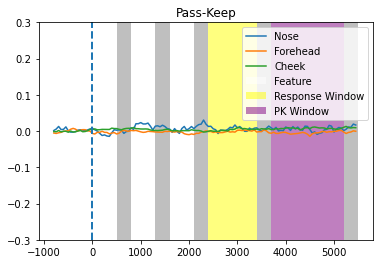

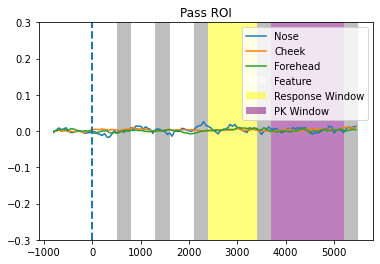

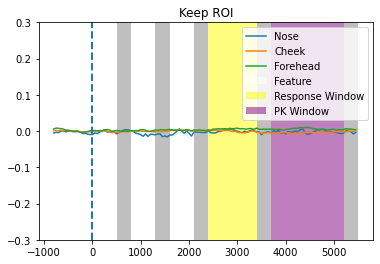

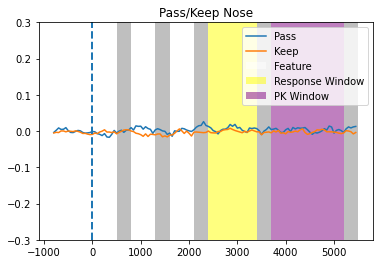

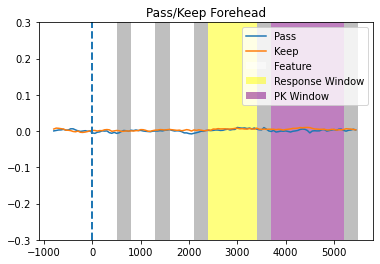

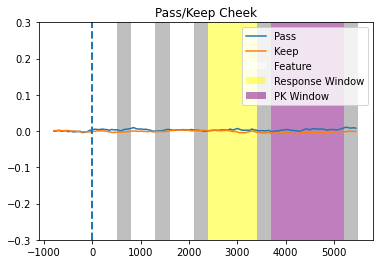

In [270]:
plt.plot(time[:130],(np.mean(passNose,axis=0)[:130] - np.mean(keepNose,axis=0)[:130]),label='Nose')
plt.plot(time[:130],(np.mean(passForehead,axis=0)[:130] - np.mean(keepForehead,axis=0)[:130]),label='Forehead')
plt.plot(time[:130],(np.mean(passCheek,axis=0)[:130] - np.mean(keepCheek,axis=0)[:130]),label='Cheek')
plt.axvline(x=0,linestyle = '--',lw=2)
plt.axvspan(500,800,color = 'gray', alpha=0.5, lw=0)
plt.axvspan(1300,1600,color = 'gray', alpha=0.5, lw=0)
plt.axvspan(2100,2400,color = 'gray', alpha=0.5, lw=0)
plt.axvspan(3400,3700,color = 'gray', alpha=0.5, lw=0)
plt.axvspan(5200,5500,color = 'gray', alpha=0.5, lw=0)

plt.axvspan(0,500,color = 'white', alpha=0.5, lw=0)
plt.axvspan(800,1300,color = 'white', alpha=0.5, lw=0)
plt.axvspan(1600,2100,color = 'white', alpha=0.5, lw=0,label='Feature')
plt.axvspan(2400,3400,color = 'yellow', alpha=0.5, lw=0,label = 'Response Window')
plt.axvspan(3700,5200,color = 'purple', alpha=0.5, lw=0,label = 'PK Window')
plt.title('Pass-Keep')
plt.legend()
plt.ylim(-0.3,0.3)
plt.show()

plt.plot(time[:130],(np.mean(passNose,axis=0)[:130]),label='Nose')
plt.plot(time[:130],(np.mean(passCheek,axis=0)[:130]),label='Cheek')
plt.plot(time[:130],(np.mean(passForehead,axis=0)[:130]),label='Forehead')
plt.axvline(x=0,linestyle = '--',lw=2)
plt.axvspan(500,800,color = 'gray', alpha=0.5, lw=0)
plt.axvspan(1300,1600,color = 'gray', alpha=0.5, lw=0)
plt.axvspan(2100,2400,color = 'gray', alpha=0.5, lw=0)
plt.axvspan(3400,3700,color = 'gray', alpha=0.5, lw=0)
plt.axvspan(5200,5500,color = 'gray', alpha=0.5, lw=0)

plt.axvspan(0,500,color = 'white', alpha=0.5, lw=0)
plt.axvspan(800,1300,color = 'white', alpha=0.5, lw=0)
plt.axvspan(1600,2100,color = 'white', alpha=0.5, lw=0,label='Feature')
plt.axvspan(2400,3400,color = 'yellow', alpha=0.5, lw=0,label = 'Response Window')
plt.axvspan(3700,5200,color = 'purple', alpha=0.5, lw=0,label = 'PK Window')
plt.title('Pass ROI')
plt.legend()
plt.ylim(-0.3,0.3)
plt.show()

plt.plot(time[:130],(np.mean(keepNose,axis=0)[:130]),label='Nose')
plt.plot(time[:130],(np.mean(keepCheek,axis=0)[:130]),label='Cheek')
plt.plot(time[:130],(np.mean(keepForehead,axis=0)[:130]),label='Forehead')
plt.axvline(x=0,linestyle = '--',lw=2)
plt.axvspan(500,800,color = 'gray', alpha=0.5, lw=0)
plt.axvspan(1300,1600,color = 'gray', alpha=0.5, lw=0)
plt.axvspan(2100,2400,color = 'gray', alpha=0.5, lw=0)
plt.axvspan(3400,3700,color = 'gray', alpha=0.5, lw=0)
plt.axvspan(5200,5500,color = 'gray', alpha=0.5, lw=0)

plt.axvspan(0,500,color = 'white', alpha=0.5, lw=0)
plt.axvspan(800,1300,color = 'white', alpha=0.5, lw=0)
plt.axvspan(1600,2100,color = 'white', alpha=0.5, lw=0,label='Feature')
plt.axvspan(2400,3400,color = 'yellow', alpha=0.5, lw=0,label = 'Response Window')
plt.axvspan(3700,5200,color = 'purple', alpha=0.5, lw=0,label = 'PK Window')
plt.title('Keep ROI')
plt.legend()
plt.ylim(-0.3,0.3)
plt.show()

plt.plot(time[:130],(np.mean(passNose,axis=0)[:130]),label='Pass')
plt.plot(time[:130],(np.mean(keepNose,axis=0)[:130]),label='Keep')
plt.axvline(x=0,linestyle = '--',lw=2)
plt.axvspan(500,800,color = 'gray', alpha=0.5, lw=0)
plt.axvspan(1300,1600,color = 'gray', alpha=0.5, lw=0)
plt.axvspan(2100,2400,color = 'gray', alpha=0.5, lw=0)
plt.axvspan(3400,3700,color = 'gray', alpha=0.5, lw=0)
plt.axvspan(5200,5500,color = 'gray', alpha=0.5, lw=0)

plt.axvspan(0,500,color = 'white', alpha=0.5, lw=0)
plt.axvspan(800,1300,color = 'white', alpha=0.5, lw=0)
plt.axvspan(1600,2100,color = 'white', alpha=0.5, lw=0,label='Feature')
plt.axvspan(2400,3400,color = 'yellow', alpha=0.5, lw=0,label = 'Response Window')
plt.axvspan(3700,5200,color = 'purple', alpha=0.5, lw=0,label = 'PK Window')
plt.title('Pass/Keep Nose')
plt.legend()
plt.ylim(-0.3,0.3)
plt.show()

plt.plot(time[:130],(np.mean(passForehead,axis=0)[:130]),label='Pass')
plt.plot(time[:130],(np.mean(keepForehead,axis=0)[:130]),label='Keep')
plt.axvline(x=0,linestyle = '--',lw=2)
plt.axvspan(500,800,color = 'gray', alpha=0.5, lw=0)
plt.axvspan(1300,1600,color = 'gray', alpha=0.5, lw=0)
plt.axvspan(2100,2400,color = 'gray', alpha=0.5, lw=0)
plt.axvspan(3400,3700,color = 'gray', alpha=0.5, lw=0)
plt.axvspan(5200,5500,color = 'gray', alpha=0.5, lw=0)

plt.axvspan(0,500,color = 'white', alpha=0.5, lw=0)
plt.axvspan(800,1300,color = 'white', alpha=0.5, lw=0)
plt.axvspan(1600,2100,color = 'white', alpha=0.5, lw=0,label='Feature')
plt.axvspan(2400,3400,color = 'yellow', alpha=0.5, lw=0,label = 'Response Window')
plt.axvspan(3700,5200,color = 'purple', alpha=0.5, lw=0,label = 'PK Window')
plt.title('Pass/Keep Forehead')
plt.legend()
plt.ylim(-0.3,0.3)
plt.show()

plt.plot(time[:130],(np.mean(passCheek,axis=0)[:130]),label='Pass')
plt.plot(time[:130],(np.mean(keepCheek,axis=0)[:130]),label='Keep')
plt.axvline(x=0,linestyle = '--',lw=2)
plt.axvspan(500,800,color = 'gray', alpha=0.5, lw=0)
plt.axvspan(1300,1600,color = 'gray', alpha=0.5, lw=0)
plt.axvspan(2100,2400,color = 'gray', alpha=0.5, lw=0)
plt.axvspan(3400,3700,color = 'gray', alpha=0.5, lw=0)
plt.axvspan(5200,5500,color = 'gray', alpha=0.5, lw=0)

plt.axvspan(0,500,color = 'white', alpha=0.5, lw=0)
plt.axvspan(800,1300,color = 'white', alpha=0.5, lw=0)
plt.axvspan(1600,2100,color = 'white', alpha=0.5, lw=0,label='Feature')
plt.axvspan(2400,3400,color = 'yellow', alpha=0.5, lw=0,label = 'Response Window')
plt.axvspan(3700,5200,color = 'purple', alpha=0.5, lw=0,label = 'PK Window')
plt.title('Pass/Keep Cheek')
plt.legend()
plt.ylim(-0.3,0.3)
plt.show()

In [271]:
## split condition -> outlier remove -> baseline

## split condition
# nose
keepNose = np.array(keep_nose_roi_data)
passNose = np.array(pass_nose_roi_data)
# forehead
keepForehead = np.array(keep_forehead_roi_data)
passForehead = np.array(pass_forehead_roi_data)
# cheek
keepCheek = (np.array(keep_left_cheek_roi_data) + np.array(keep_right_cheek_roi_data))/2
passCheek = (np.array(pass_left_cheek_roi_data) + np.array(pass_right_cheek_roi_data))/2


keepEegBadTrials = np.array(keepEegBadTrials)
passEegBadTrials = np.array(passEegBadTrials)

## outlier remove
# maskShape = np.where(stimresponsechoice == 1)[0].shape[0]
noseTrialsVar,stdNoseTrials,medianVarNoseTrials,noseTrialOutlier = getOutlier(keepNose,keepEegBadTrials,varThresh)
foreheadTrialsVar,stdForeheadTrials,medianVarForeheadTrials,foreheadTrialOutlier = getOutlier(keepForehead,keepEegBadTrials,varThresh)
cheekTrialsVar,stdCheekTrials,medianVarCheekTrials,cheekTrialOutlier = getOutlier(keepCheek,keepEegBadTrials,varThresh)

invalidTrials= np.unique(np.concatenate((noseTrialOutlier,foreheadTrialOutlier,cheekTrialOutlier,np.where(keepEegBadTrials == True)[0])))
validTrialInd = np.array([i for i in np.arange(keepEegBadTrials.shape[0]) if i not in invalidTrials])
# validKeep = np.where(stimresponsechoice == 1)[0][validTrialInd]

# Nose
keepNose = removeOutlier(keepNose, invalidTrials,baselineIndx)
# plotCleanup(noseTrialsVar,medianVarNoseTrials, stdNoseTrials,varThresh = 3)

# Forehead
keepForehead = removeOutlier(keepForehead, invalidTrials,baselineIndx)
# plotCleanup(foreheadTrialsVar,medianVarForeheadTrials, stdForeheadTrials,varThresh = 3)

# Cheek
keepCheek = removeOutlier(keepCheek, invalidTrials,baselineIndx)
# plotCleanup(cheekTrialsVar,medianVarCheekTrials, stdCheekTrials,varThresh = 3)

# maskShape = np.where(stimresponsechoice == 0)[0].shape[0]
noseTrialsVar,stdNoseTrials,medianVarNoseTrials,noseTrialOutlier = getOutlier(passNose,passEegBadTrials,varThresh)
foreheadTrialsVar,stdForeheadTrials,medianVarForeheadTrials,foreheadTrialOutlier = getOutlier(passForehead,passEegBadTrials,varThresh)
cheekTrialsVar,stdCheekTrials,medianVarCheekTrials,cheekTrialOutlier = getOutlier(passCheek,passEegBadTrials,varThresh)

invalidTrials= np.unique(np.concatenate((noseTrialOutlier,foreheadTrialOutlier,cheekTrialOutlier,np.where(passEegBadTrials == True)[0])))
validTrialInd = np.array([i for i in np.arange(passEegBadTrials.shape[0]) if i not in invalidTrials])
# validPass = np.where(stimresponsechoice == 0)[0][validTrialInd]



# Nose
passNose = removeOutlier(passNose, invalidTrials,baselineIndx)
# plotCleanup(noseTrialsVar,medianVarNoseTrials, stdNoseTrials,varThresh = 3)

# Forehead
passForehead = removeOutlier(passForehead, invalidTrials,baselineIndx)
# plotCleanup(foreheadTrialsVar,medianVarForeheadTrials, stdForeheadTrials,varThresh = 3)

# Cheek
passCheek = removeOutlier(passCheek, invalidTrials,baselineIndx)
# plotCleanup(cheekTrialsVar,medianVarCheekTrials, stdCheekTrials,varThresh = 3)


# keepNoseTrials = nose_roi_data_outlier_removed - np.mean(nose_roi_data_outlier_removed[:, :baselineIndx])
# keepForeheadTrials = forehead_roi_data_outlier_removed - np.mean(forehead_roi_data_outlier_removed[:, :baselineIndx])
# keepLeftTrials = left_roi_data_outlier_removed - np.mean(left_roi_data_outlier_removed[:, :baselineIndx])
# keepRightTrials = right_roi_data_outlier_removed - np.mean(right_roi_data_outlier_removed[:, :baselineIndx])

## baseline
keepNose = baselinecorrect(keepNose,range(20))
passNose = baselinecorrect(passNose,range(20))

keepForehead = baselinecorrect(keepForehead,range(20))
passForehead = baselinecorrect(passForehead,range(20))

keepCheek = baselinecorrect(keepCheek,range(20))
passCheek = baselinecorrect(passCheek,range(20))

keepNose = np.array(pd.DataFrame(keepNose).T.rolling(window=5).median().T) 
passNose = np.array(pd.DataFrame(passNose).T.rolling(window=5).median().T) 
keepForehead = np.array(pd.DataFrame(keepForehead).T.rolling(window=5).median().T) 
passForehead = np.array(pd.DataFrame(passForehead).T.rolling(window=5).median().T) 
keepCheek = np.array(pd.DataFrame(keepCheek).T.rolling(window=5).median().T) 
passCheek = np.array(pd.DataFrame(passCheek).T.rolling(window=5).median().T) 


keepNose = np.round(keepNose, 2)
passNose = np.round(passNose,2)
keepForehead = np.round(keepForehead, 2)
passForehead = np.round(passForehead,2)
keepCheek = np.round(keepCheek, 2)
passCheek = np.round(passCheek,2)


(140, 148)
(140,)
(51, 215)
(51,)
(140, 148)
(140,)
(51, 215)
(51,)
(140, 148)
(140,)
(51, 215)
(51,)


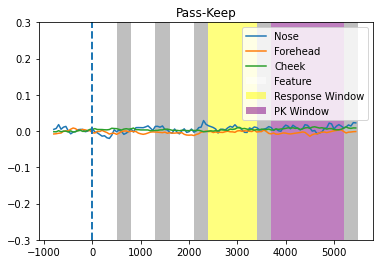

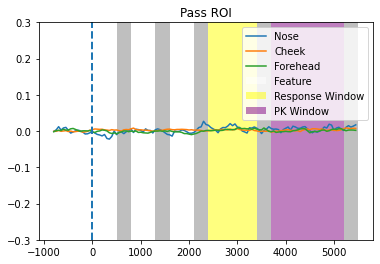

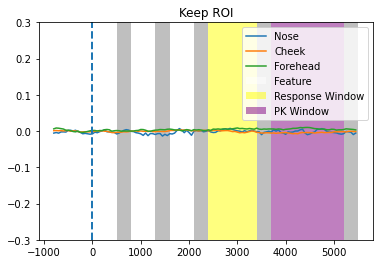

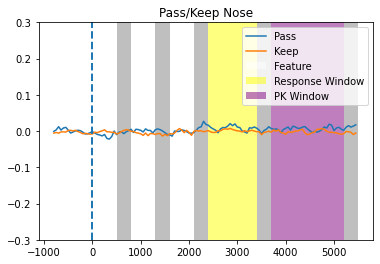

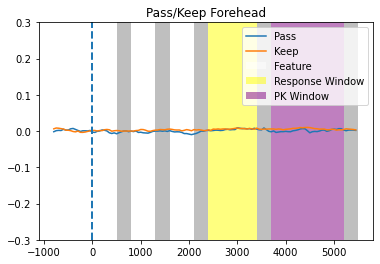

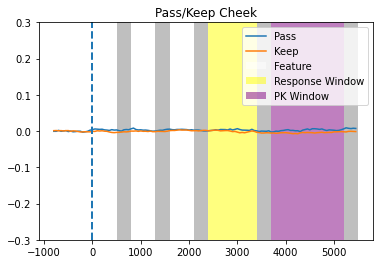

In [272]:
plt.plot(time[:130],(np.mean(passNose,axis=0)[:130] - np.mean(keepNose,axis=0)[:130]),label='Nose')
plt.plot(time[:130],(np.mean(passForehead,axis=0)[:130] - np.mean(keepForehead,axis=0)[:130]),label='Forehead')
plt.plot(time[:130],(np.mean(passCheek,axis=0)[:130] - np.mean(keepCheek,axis=0)[:130]),label='Cheek')
plt.axvline(x=0,linestyle = '--',lw=2)
plt.axvspan(500,800,color = 'gray', alpha=0.5, lw=0)
plt.axvspan(1300,1600,color = 'gray', alpha=0.5, lw=0)
plt.axvspan(2100,2400,color = 'gray', alpha=0.5, lw=0)
plt.axvspan(3400,3700,color = 'gray', alpha=0.5, lw=0)
plt.axvspan(5200,5500,color = 'gray', alpha=0.5, lw=0)

plt.axvspan(0,500,color = 'white', alpha=0.5, lw=0)
plt.axvspan(800,1300,color = 'white', alpha=0.5, lw=0)
plt.axvspan(1600,2100,color = 'white', alpha=0.5, lw=0,label='Feature')
plt.axvspan(2400,3400,color = 'yellow', alpha=0.5, lw=0,label = 'Response Window')
plt.axvspan(3700,5200,color = 'purple', alpha=0.5, lw=0,label = 'PK Window')
plt.title('Pass-Keep')
plt.legend()
plt.ylim(-0.3,0.3)
plt.show()

plt.plot(time[:130],(np.mean(passNose,axis=0)[:130]),label='Nose')
plt.plot(time[:130],(np.mean(passCheek,axis=0)[:130]),label='Cheek')
plt.plot(time[:130],(np.mean(passForehead,axis=0)[:130]),label='Forehead')
plt.axvline(x=0,linestyle = '--',lw=2)
plt.axvspan(500,800,color = 'gray', alpha=0.5, lw=0)
plt.axvspan(1300,1600,color = 'gray', alpha=0.5, lw=0)
plt.axvspan(2100,2400,color = 'gray', alpha=0.5, lw=0)
plt.axvspan(3400,3700,color = 'gray', alpha=0.5, lw=0)
plt.axvspan(5200,5500,color = 'gray', alpha=0.5, lw=0)

plt.axvspan(0,500,color = 'white', alpha=0.5, lw=0)
plt.axvspan(800,1300,color = 'white', alpha=0.5, lw=0)
plt.axvspan(1600,2100,color = 'white', alpha=0.5, lw=0,label='Feature')
plt.axvspan(2400,3400,color = 'yellow', alpha=0.5, lw=0,label = 'Response Window')
plt.axvspan(3700,5200,color = 'purple', alpha=0.5, lw=0,label = 'PK Window')
plt.title('Pass ROI')
plt.legend()
plt.ylim(-0.3,0.3)
plt.show()

plt.plot(time[:130],(np.mean(keepNose,axis=0)[:130]),label='Nose')
plt.plot(time[:130],(np.mean(keepCheek,axis=0)[:130]),label='Cheek')
plt.plot(time[:130],(np.mean(keepForehead,axis=0)[:130]),label='Forehead')
plt.axvline(x=0,linestyle = '--',lw=2)
plt.axvspan(500,800,color = 'gray', alpha=0.5, lw=0)
plt.axvspan(1300,1600,color = 'gray', alpha=0.5, lw=0)
plt.axvspan(2100,2400,color = 'gray', alpha=0.5, lw=0)
plt.axvspan(3400,3700,color = 'gray', alpha=0.5, lw=0)
plt.axvspan(5200,5500,color = 'gray', alpha=0.5, lw=0)

plt.axvspan(0,500,color = 'white', alpha=0.5, lw=0)
plt.axvspan(800,1300,color = 'white', alpha=0.5, lw=0)
plt.axvspan(1600,2100,color = 'white', alpha=0.5, lw=0,label='Feature')
plt.axvspan(2400,3400,color = 'yellow', alpha=0.5, lw=0,label = 'Response Window')
plt.axvspan(3700,5200,color = 'purple', alpha=0.5, lw=0,label = 'PK Window')
plt.title('Keep ROI')
plt.legend()
plt.ylim(-0.3,0.3)
plt.show()

plt.plot(time[:130],(np.mean(passNose,axis=0)[:130]),label='Pass')
plt.plot(time[:130],(np.mean(keepNose,axis=0)[:130]),label='Keep')
plt.axvline(x=0,linestyle = '--',lw=2)
plt.axvspan(500,800,color = 'gray', alpha=0.5, lw=0)
plt.axvspan(1300,1600,color = 'gray', alpha=0.5, lw=0)
plt.axvspan(2100,2400,color = 'gray', alpha=0.5, lw=0)
plt.axvspan(3400,3700,color = 'gray', alpha=0.5, lw=0)
plt.axvspan(5200,5500,color = 'gray', alpha=0.5, lw=0)

plt.axvspan(0,500,color = 'white', alpha=0.5, lw=0)
plt.axvspan(800,1300,color = 'white', alpha=0.5, lw=0)
plt.axvspan(1600,2100,color = 'white', alpha=0.5, lw=0,label='Feature')
plt.axvspan(2400,3400,color = 'yellow', alpha=0.5, lw=0,label = 'Response Window')
plt.axvspan(3700,5200,color = 'purple', alpha=0.5, lw=0,label = 'PK Window')
plt.title('Pass/Keep Nose')
plt.legend()
plt.ylim(-0.3,0.3)
plt.show()

plt.plot(time[:130],(np.mean(passForehead,axis=0)[:130]),label='Pass')
plt.plot(time[:130],(np.mean(keepForehead,axis=0)[:130]),label='Keep')
plt.axvline(x=0,linestyle = '--',lw=2)
plt.axvspan(500,800,color = 'gray', alpha=0.5, lw=0)
plt.axvspan(1300,1600,color = 'gray', alpha=0.5, lw=0)
plt.axvspan(2100,2400,color = 'gray', alpha=0.5, lw=0)
plt.axvspan(3400,3700,color = 'gray', alpha=0.5, lw=0)
plt.axvspan(5200,5500,color = 'gray', alpha=0.5, lw=0)

plt.axvspan(0,500,color = 'white', alpha=0.5, lw=0)
plt.axvspan(800,1300,color = 'white', alpha=0.5, lw=0)
plt.axvspan(1600,2100,color = 'white', alpha=0.5, lw=0,label='Feature')
plt.axvspan(2400,3400,color = 'yellow', alpha=0.5, lw=0,label = 'Response Window')
plt.axvspan(3700,5200,color = 'purple', alpha=0.5, lw=0,label = 'PK Window')
plt.title('Pass/Keep Forehead')
plt.legend()
plt.ylim(-0.3,0.3)
plt.show()

plt.plot(time[:130],(np.mean(passCheek,axis=0)[:130]),label='Pass')
plt.plot(time[:130],(np.mean(keepCheek,axis=0)[:130]),label='Keep')
plt.axvline(x=0,linestyle = '--',lw=2)
plt.axvspan(500,800,color = 'gray', alpha=0.5, lw=0)
plt.axvspan(1300,1600,color = 'gray', alpha=0.5, lw=0)
plt.axvspan(2100,2400,color = 'gray', alpha=0.5, lw=0)
plt.axvspan(3400,3700,color = 'gray', alpha=0.5, lw=0)
plt.axvspan(5200,5500,color = 'gray', alpha=0.5, lw=0)

plt.axvspan(0,500,color = 'white', alpha=0.5, lw=0)
plt.axvspan(800,1300,color = 'white', alpha=0.5, lw=0)
plt.axvspan(1600,2100,color = 'white', alpha=0.5, lw=0,label='Feature')
plt.axvspan(2400,3400,color = 'yellow', alpha=0.5, lw=0,label = 'Response Window')
plt.axvspan(3700,5200,color = 'purple', alpha=0.5, lw=0,label = 'PK Window')
plt.title('Pass/Keep Cheek')
plt.legend()
plt.ylim(-0.3,0.3)
plt.show()

(205, 140)
(205,)
(205, 140)
(205,)
(205, 140)
(205,)
Nose


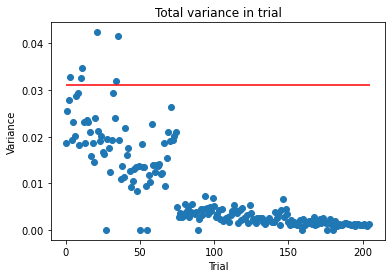

Forehead


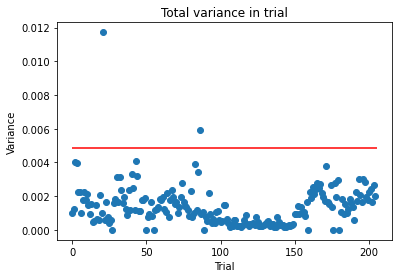

Cheek


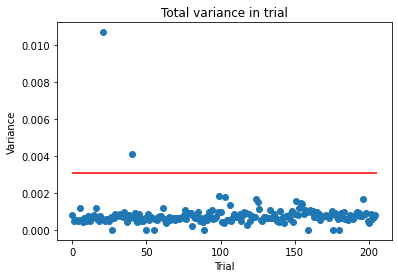

In [273]:
### baseline -> outlier remove -> split condition

## baseline
bsnose = baselinecorrect(np.array(full_nose_roi_data),range(20))
bsfore = baselinecorrect(np.array(full_forehead_roi_data),range(20))
bscheek = baselinecorrect(np.array(full_cheek_roi_data),range(20))

## outlier remove
noseTrialsVar,stdNoseTrials,medianVarNoseTrials,noseTrialOutlier = getOutlier(bsnose,mask,varThresh)
foreheadTrialsVar,stdForeheadTrials,medianVarForeheadTrials,foreheadTrialOutlier = getOutlier(bsfore,mask,varThresh)
cheekTrialsVar,stdCheekTrials,medianVarCheekTrials,cheekTrialOutlier = getOutlier(bscheek,mask,varThresh)

invalidTrials= np.unique(np.concatenate((noseTrialOutlier,foreheadTrialOutlier,cheekTrialOutlier,eegBadTrials)))
validTrialInd = np.array([i for i in np.arange(full_room_temp_data.shape[0]) if i not in invalidTrials])
validPk = stimresponsechoice[validTrialInd]

# Nose
print('Nose')
bsnose = removeOutlier(bsnose, invalidTrials,baselineIndx)
plotCleanup(noseTrialsVar,medianVarNoseTrials, stdNoseTrials,varThresh = 3)

# Forehead
print('Forehead')
bsfore = removeOutlier(bsfore, invalidTrials,baselineIndx)
plotCleanup(foreheadTrialsVar,medianVarForeheadTrials, stdForeheadTrials,varThresh = 3)

# Cheek
print('Cheek')
bscheek = removeOutlier(bscheek, invalidTrials,baselineIndx)
plotCleanup(cheekTrialsVar,medianVarCheekTrials, stdCheekTrials,varThresh = 3)


# keepNoseTrials = nose_roi_data_outlier_removed - np.mean(nose_roi_data_outlier_removed[:, :baselineIndx])
# keepForeheadTrials = forehead_roi_data_outlier_removed - np.mean(forehead_roi_data_outlier_removed[:, :baselineIndx])
# keepLeftTrials = left_roi_data_outlier_removed - np.mean(left_roi_data_outlier_removed[:, :baselineIndx])
# keepRightTrials = right_roi_data_outlier_removed - np.mean(right_roi_data_outlier_removed[:, :baselineIndx])



bsnose = np.array(pd.DataFrame(bsnose).T.rolling(window=5).median().T) 
bsfore = np.array(pd.DataFrame(bsfore).T.rolling(window=5).median().T) 
bscheek = np.array(pd.DataFrame(bscheek).T.rolling(window=5).median().T)

# keepNoseTrials = bsnose
# keepForeheadTrials = bsfore
# keepLeftTrials = bsleft
# keepRightTrials = bsright
noseTrials = np.round(bsnose, 2)
foreheadTrials = np.round(bsfore, 2)
cheekTrials = np.round(bscheek,2)

## split condition
# nose
keepNose = noseTrials[np.where(validPk == 1)[0],:]
passNose = noseTrials[np.where(validPk == 0)[0],:]
# forehead
keepForehead = foreheadTrials[np.where(validPk == 1)[0],:]
passForehead = foreheadTrials[np.where(validPk == 0)[0],:]
# cheek
keepCheek = cheekTrials[np.where(validPk == 1)[0],:]
passCheek = cheekTrials[np.where(validPk == 0)[0],:]



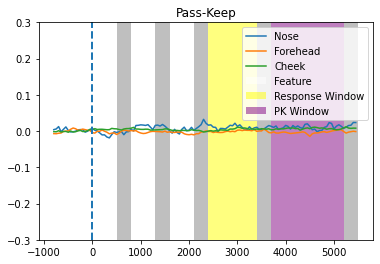

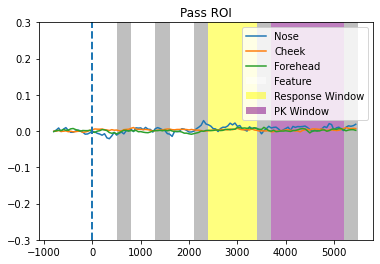

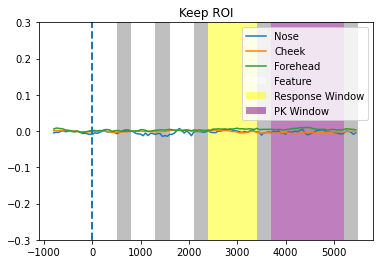

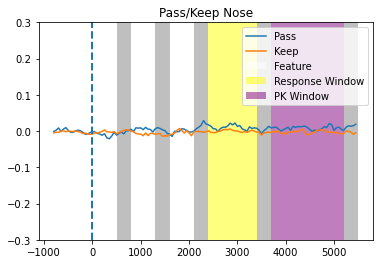

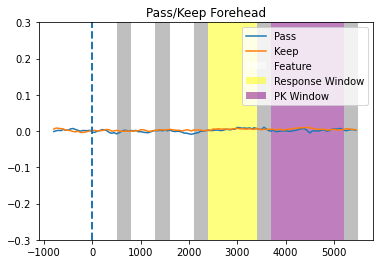

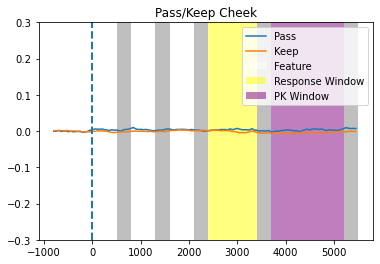

In [274]:
plt.plot(time[:130],(np.mean(passNose,axis=0)[:130] - np.mean(keepNose,axis=0)[:130]),label='Nose')
plt.plot(time[:130],(np.mean(passForehead,axis=0)[:130] - np.mean(keepForehead,axis=0)[:130]),label='Forehead')
plt.plot(time[:130],(np.mean(passCheek,axis=0)[:130] - np.mean(keepCheek,axis=0)[:130]),label='Cheek')
plt.axvline(x=0,linestyle = '--',lw=2)
plt.axvspan(500,800,color = 'gray', alpha=0.5, lw=0)
plt.axvspan(1300,1600,color = 'gray', alpha=0.5, lw=0)
plt.axvspan(2100,2400,color = 'gray', alpha=0.5, lw=0)
plt.axvspan(3400,3700,color = 'gray', alpha=0.5, lw=0)
plt.axvspan(5200,5500,color = 'gray', alpha=0.5, lw=0)

plt.axvspan(0,500,color = 'white', alpha=0.5, lw=0)
plt.axvspan(800,1300,color = 'white', alpha=0.5, lw=0)
plt.axvspan(1600,2100,color = 'white', alpha=0.5, lw=0,label='Feature')
plt.axvspan(2400,3400,color = 'yellow', alpha=0.5, lw=0,label = 'Response Window')
plt.axvspan(3700,5200,color = 'purple', alpha=0.5, lw=0,label = 'PK Window')
plt.title('Pass-Keep')
plt.legend()
plt.ylim(-0.3,0.3)
plt.show()

plt.plot(time[:130],(np.mean(passNose,axis=0)[:130]),label='Nose')
plt.plot(time[:130],(np.mean(passCheek,axis=0)[:130]),label='Cheek')
plt.plot(time[:130],(np.mean(passForehead,axis=0)[:130]),label='Forehead')
plt.axvline(x=0,linestyle = '--',lw=2)
plt.axvspan(500,800,color = 'gray', alpha=0.5, lw=0)
plt.axvspan(1300,1600,color = 'gray', alpha=0.5, lw=0)
plt.axvspan(2100,2400,color = 'gray', alpha=0.5, lw=0)
plt.axvspan(3400,3700,color = 'gray', alpha=0.5, lw=0)
plt.axvspan(5200,5500,color = 'gray', alpha=0.5, lw=0)

plt.axvspan(0,500,color = 'white', alpha=0.5, lw=0)
plt.axvspan(800,1300,color = 'white', alpha=0.5, lw=0)
plt.axvspan(1600,2100,color = 'white', alpha=0.5, lw=0,label='Feature')
plt.axvspan(2400,3400,color = 'yellow', alpha=0.5, lw=0,label = 'Response Window')
plt.axvspan(3700,5200,color = 'purple', alpha=0.5, lw=0,label = 'PK Window')
plt.title('Pass ROI')
plt.legend()
plt.ylim(-0.3,0.3)
plt.show()

plt.plot(time[:130],(np.mean(keepNose,axis=0)[:130]),label='Nose')
plt.plot(time[:130],(np.mean(keepCheek,axis=0)[:130]),label='Cheek')
plt.plot(time[:130],(np.mean(keepForehead,axis=0)[:130]),label='Forehead')
plt.axvline(x=0,linestyle = '--',lw=2)
plt.axvspan(500,800,color = 'gray', alpha=0.5, lw=0)
plt.axvspan(1300,1600,color = 'gray', alpha=0.5, lw=0)
plt.axvspan(2100,2400,color = 'gray', alpha=0.5, lw=0)
plt.axvspan(3400,3700,color = 'gray', alpha=0.5, lw=0)
plt.axvspan(5200,5500,color = 'gray', alpha=0.5, lw=0)

plt.axvspan(0,500,color = 'white', alpha=0.5, lw=0)
plt.axvspan(800,1300,color = 'white', alpha=0.5, lw=0)
plt.axvspan(1600,2100,color = 'white', alpha=0.5, lw=0,label='Feature')
plt.axvspan(2400,3400,color = 'yellow', alpha=0.5, lw=0,label = 'Response Window')
plt.axvspan(3700,5200,color = 'purple', alpha=0.5, lw=0,label = 'PK Window')
plt.title('Keep ROI')
plt.legend()
plt.ylim(-0.3,0.3)
plt.show()

plt.plot(time[:130],(np.mean(passNose,axis=0)[:130]),label='Pass')
plt.plot(time[:130],(np.mean(keepNose,axis=0)[:130]),label='Keep')
plt.axvline(x=0,linestyle = '--',lw=2)
plt.axvspan(500,800,color = 'gray', alpha=0.5, lw=0)
plt.axvspan(1300,1600,color = 'gray', alpha=0.5, lw=0)
plt.axvspan(2100,2400,color = 'gray', alpha=0.5, lw=0)
plt.axvspan(3400,3700,color = 'gray', alpha=0.5, lw=0)
plt.axvspan(5200,5500,color = 'gray', alpha=0.5, lw=0)

plt.axvspan(0,500,color = 'white', alpha=0.5, lw=0)
plt.axvspan(800,1300,color = 'white', alpha=0.5, lw=0)
plt.axvspan(1600,2100,color = 'white', alpha=0.5, lw=0,label='Feature')
plt.axvspan(2400,3400,color = 'yellow', alpha=0.5, lw=0,label = 'Response Window')
plt.axvspan(3700,5200,color = 'purple', alpha=0.5, lw=0,label = 'PK Window')
plt.title('Pass/Keep Nose')
plt.legend()
plt.ylim(-0.3,0.3)
plt.show()

plt.plot(time[:130],(np.mean(passForehead,axis=0)[:130]),label='Pass')
plt.plot(time[:130],(np.mean(keepForehead,axis=0)[:130]),label='Keep')
plt.axvline(x=0,linestyle = '--',lw=2)
plt.axvspan(500,800,color = 'gray', alpha=0.5, lw=0)
plt.axvspan(1300,1600,color = 'gray', alpha=0.5, lw=0)
plt.axvspan(2100,2400,color = 'gray', alpha=0.5, lw=0)
plt.axvspan(3400,3700,color = 'gray', alpha=0.5, lw=0)
plt.axvspan(5200,5500,color = 'gray', alpha=0.5, lw=0)

plt.axvspan(0,500,color = 'white', alpha=0.5, lw=0)
plt.axvspan(800,1300,color = 'white', alpha=0.5, lw=0)
plt.axvspan(1600,2100,color = 'white', alpha=0.5, lw=0,label='Feature')
plt.axvspan(2400,3400,color = 'yellow', alpha=0.5, lw=0,label = 'Response Window')
plt.axvspan(3700,5200,color = 'purple', alpha=0.5, lw=0,label = 'PK Window')
plt.title('Pass/Keep Forehead')
plt.legend()
plt.ylim(-0.3,0.3)
plt.show()

plt.plot(time[:130],(np.mean(passCheek,axis=0)[:130]),label='Pass')
plt.plot(time[:130],(np.mean(keepCheek,axis=0)[:130]),label='Keep')
plt.axvline(x=0,linestyle = '--',lw=2)
plt.axvspan(500,800,color = 'gray', alpha=0.5, lw=0)
plt.axvspan(1300,1600,color = 'gray', alpha=0.5, lw=0)
plt.axvspan(2100,2400,color = 'gray', alpha=0.5, lw=0)
plt.axvspan(3400,3700,color = 'gray', alpha=0.5, lw=0)
plt.axvspan(5200,5500,color = 'gray', alpha=0.5, lw=0)

plt.axvspan(0,500,color = 'white', alpha=0.5, lw=0)
plt.axvspan(800,1300,color = 'white', alpha=0.5, lw=0)
plt.axvspan(1600,2100,color = 'white', alpha=0.5, lw=0,label='Feature')
plt.axvspan(2400,3400,color = 'yellow', alpha=0.5, lw=0,label = 'Response Window')
plt.axvspan(3700,5200,color = 'purple', alpha=0.5, lw=0,label = 'PK Window')
plt.title('Pass/Keep Cheek')
plt.legend()
plt.ylim(-0.3,0.3)
plt.show()

In [275]:
### baseline -> split condition -> outlier remove 

## baseline
bsnose = baselinecorrect(np.array(full_nose_roi_data),range(20))
bsfore = baselinecorrect(np.array(full_forehead_roi_data),range(20))
bscheek = baselinecorrect(np.array(full_cheek_roi_data),range(20))

## split condition
# nose
keepNose = bsnose[np.where(stimresponsechoice == 1)[0],:]
passNose = bsnose[np.where(stimresponsechoice == 0)[0],:]
# forehead
keepForehead = bsfore[np.where(stimresponsechoice == 1)[0],:]
passForehead = bsfore[np.where(stimresponsechoice == 0)[0],:]
# cheek
keepCheek = bscheek[np.where(stimresponsechoice == 1)[0],:]
passCheek = bscheek[np.where(stimresponsechoice == 0)[0],:]


## outlier remove
## outlier remove
# maskShape = np.where(stimresponsechoice == 1)[0].shape[0]
noseTrialsVar,stdNoseTrials,medianVarNoseTrials,noseTrialOutlier = getOutlier(keepNose,keepEegBadTrials,varThresh)
foreheadTrialsVar,stdForeheadTrials,medianVarForeheadTrials,foreheadTrialOutlier = getOutlier(keepForehead,keepEegBadTrials,varThresh)
cheekTrialsVar,stdCheekTrials,medianVarCheekTrials,cheekTrialOutlier = getOutlier(keepCheek,keepEegBadTrials,varThresh)

invalidTrials= np.unique(np.concatenate((noseTrialOutlier,foreheadTrialOutlier,cheekTrialOutlier,np.where(keepEegBadTrials == True)[0])))
validTrialInd = np.array([i for i in np.arange(keepEegBadTrials.shape[0]) if i not in invalidTrials])
# validKeep = np.where(stimresponsechoice == 1)[0][validTrialInd]

# Nose
keepNose = removeOutlier(keepNose, invalidTrials,baselineIndx)
# plotCleanup(noseTrialsVar,medianVarNoseTrials, stdNoseTrials,varThresh = 3)

# Forehead
keepForehead = removeOutlier(keepForehead, invalidTrials,baselineIndx)
# plotCleanup(foreheadTrialsVar,medianVarForeheadTrials, stdForeheadTrials,varThresh = 3)

# Cheek
keepCheek = removeOutlier(keepCheek, invalidTrials,baselineIndx)
# plotCleanup(cheekTrialsVar,medianVarCheekTrials, stdCheekTrials,varThresh = 3)

# maskShape = np.where(stimresponsechoice == 0)[0].shape[0]
noseTrialsVar,stdNoseTrials,medianVarNoseTrials,noseTrialOutlier = getOutlier(passNose,passEegBadTrials,varThresh)
foreheadTrialsVar,stdForeheadTrials,medianVarForeheadTrials,foreheadTrialOutlier = getOutlier(passForehead,passEegBadTrials,varThresh)
cheekTrialsVar,stdCheekTrials,medianVarCheekTrials,cheekTrialOutlier = getOutlier(passCheek,passEegBadTrials,varThresh)

invalidTrials= np.unique(np.concatenate((noseTrialOutlier,foreheadTrialOutlier,cheekTrialOutlier,np.where(passEegBadTrials == True)[0])))
validTrialInd = np.array([i for i in np.arange(passEegBadTrials.shape[0]) if i not in invalidTrials])
# validPass = np.where(stimresponsechoice == 0)[0][validTrialInd]



# Nose
passNose = removeOutlier(passNose, invalidTrials,baselineIndx)
# plotCleanup(noseTrialsVar,medianVarNoseTrials, stdNoseTrials,varThresh = 3)

# Forehead
passForehead = removeOutlier(passForehead, invalidTrials,baselineIndx)
# plotCleanup(foreheadTrialsVar,medianVarForeheadTrials, stdForeheadTrials,varThresh = 3)

# Cheek
passCheek = removeOutlier(passCheek, invalidTrials,baselineIndx)
# plotCleanup(cheekTrialsVar,medianVarCheekTrials, stdCheekTrials,varThresh = 3)



# keepNoseTrials = nose_roi_data_outlier_removed - np.mean(nose_roi_data_outlier_removed[:, :baselineIndx])
# keepForeheadTrials = forehead_roi_data_outlier_removed - np.mean(forehead_roi_data_outlier_removed[:, :baselineIndx])
# keepLeftTrials = left_roi_data_outlier_removed - np.mean(left_roi_data_outlier_removed[:, :baselineIndx])
# keepRightTrials = right_roi_data_outlier_removed - np.mean(right_roi_data_outlier_removed[:, :baselineIndx])



keepNose = np.array(pd.DataFrame(keepNose).T.rolling(window=5).median().T) 
passNose = np.array(pd.DataFrame(passNose).T.rolling(window=5).median().T) 
keepForehead = np.array(pd.DataFrame(keepForehead).T.rolling(window=5).median().T) 
passForehead = np.array(pd.DataFrame(passForehead).T.rolling(window=5).median().T) 
keepCheek = np.array(pd.DataFrame(keepCheek).T.rolling(window=5).median().T) 
passCheek = np.array(pd.DataFrame(passCheek).T.rolling(window=5).median().T) 


keepNose = np.round(keepNose, 2)
passNose = np.round(passNose,2)
keepForehead = np.round(keepForehead, 2)
passForehead = np.round(passForehead,2)
keepCheek = np.round(keepCheek, 2)
passCheek = np.round(passCheek,2)





(205, 140)
(205,)
(205, 140)
(205,)
(205, 140)
(205,)


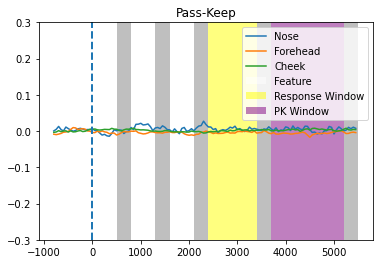

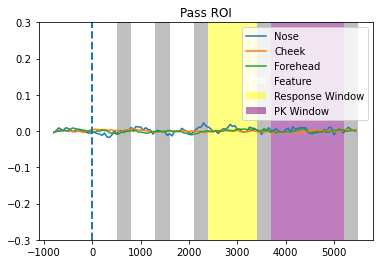

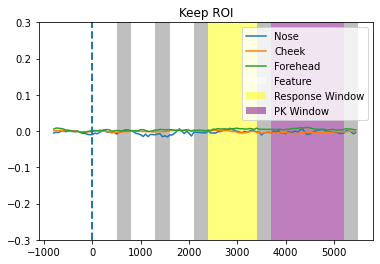

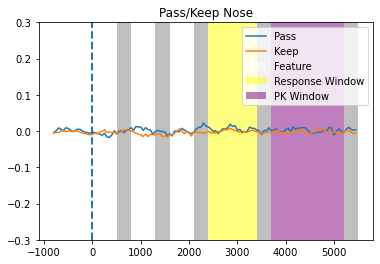

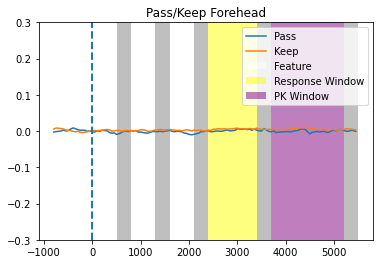

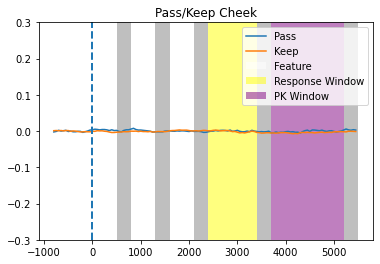

In [276]:
plt.plot(time[:130],(np.mean(passNose,axis=0)[:130] - np.mean(keepNose,axis=0)[:130]),label='Nose')
plt.plot(time[:130],(np.mean(passForehead,axis=0)[:130] - np.mean(keepForehead,axis=0)[:130]),label='Forehead')
plt.plot(time[:130],(np.mean(passCheek,axis=0)[:130] - np.mean(keepCheek,axis=0)[:130]),label='Cheek')
plt.axvline(x=0,linestyle = '--',lw=2)
plt.axvspan(500,800,color = 'gray', alpha=0.5, lw=0)
plt.axvspan(1300,1600,color = 'gray', alpha=0.5, lw=0)
plt.axvspan(2100,2400,color = 'gray', alpha=0.5, lw=0)
plt.axvspan(3400,3700,color = 'gray', alpha=0.5, lw=0)
plt.axvspan(5200,5500,color = 'gray', alpha=0.5, lw=0)

plt.axvspan(0,500,color = 'white', alpha=0.5, lw=0)
plt.axvspan(800,1300,color = 'white', alpha=0.5, lw=0)
plt.axvspan(1600,2100,color = 'white', alpha=0.5, lw=0,label='Feature')
plt.axvspan(2400,3400,color = 'yellow', alpha=0.5, lw=0,label = 'Response Window')
plt.axvspan(3700,5200,color = 'purple', alpha=0.5, lw=0,label = 'PK Window')
plt.title('Pass-Keep')
plt.legend()
plt.ylim(-0.3,0.3)
plt.show()

plt.plot(time[:130],(np.mean(passNose,axis=0)[:130]),label='Nose')
plt.plot(time[:130],(np.mean(passCheek,axis=0)[:130]),label='Cheek')
plt.plot(time[:130],(np.mean(passForehead,axis=0)[:130]),label='Forehead')
plt.axvline(x=0,linestyle = '--',lw=2)
plt.axvspan(500,800,color = 'gray', alpha=0.5, lw=0)
plt.axvspan(1300,1600,color = 'gray', alpha=0.5, lw=0)
plt.axvspan(2100,2400,color = 'gray', alpha=0.5, lw=0)
plt.axvspan(3400,3700,color = 'gray', alpha=0.5, lw=0)
plt.axvspan(5200,5500,color = 'gray', alpha=0.5, lw=0)

plt.axvspan(0,500,color = 'white', alpha=0.5, lw=0)
plt.axvspan(800,1300,color = 'white', alpha=0.5, lw=0)
plt.axvspan(1600,2100,color = 'white', alpha=0.5, lw=0,label='Feature')
plt.axvspan(2400,3400,color = 'yellow', alpha=0.5, lw=0,label = 'Response Window')
plt.axvspan(3700,5200,color = 'purple', alpha=0.5, lw=0,label = 'PK Window')
plt.title('Pass ROI')
plt.legend()
plt.ylim(-0.3,0.3)
plt.show()

plt.plot(time[:130],(np.mean(keepNose,axis=0)[:130]),label='Nose')
plt.plot(time[:130],(np.mean(keepCheek,axis=0)[:130]),label='Cheek')
plt.plot(time[:130],(np.mean(keepForehead,axis=0)[:130]),label='Forehead')
plt.axvline(x=0,linestyle = '--',lw=2)
plt.axvspan(500,800,color = 'gray', alpha=0.5, lw=0)
plt.axvspan(1300,1600,color = 'gray', alpha=0.5, lw=0)
plt.axvspan(2100,2400,color = 'gray', alpha=0.5, lw=0)
plt.axvspan(3400,3700,color = 'gray', alpha=0.5, lw=0)
plt.axvspan(5200,5500,color = 'gray', alpha=0.5, lw=0)

plt.axvspan(0,500,color = 'white', alpha=0.5, lw=0)
plt.axvspan(800,1300,color = 'white', alpha=0.5, lw=0)
plt.axvspan(1600,2100,color = 'white', alpha=0.5, lw=0,label='Feature')
plt.axvspan(2400,3400,color = 'yellow', alpha=0.5, lw=0,label = 'Response Window')
plt.axvspan(3700,5200,color = 'purple', alpha=0.5, lw=0,label = 'PK Window')
plt.title('Keep ROI')
plt.legend()
plt.ylim(-0.3,0.3)
plt.show()

plt.plot(time[:130],(np.mean(passNose,axis=0)[:130]),label='Pass')
plt.plot(time[:130],(np.mean(keepNose,axis=0)[:130]),label='Keep')
plt.axvline(x=0,linestyle = '--',lw=2)
plt.axvspan(500,800,color = 'gray', alpha=0.5, lw=0)
plt.axvspan(1300,1600,color = 'gray', alpha=0.5, lw=0)
plt.axvspan(2100,2400,color = 'gray', alpha=0.5, lw=0)
plt.axvspan(3400,3700,color = 'gray', alpha=0.5, lw=0)
plt.axvspan(5200,5500,color = 'gray', alpha=0.5, lw=0)

plt.axvspan(0,500,color = 'white', alpha=0.5, lw=0)
plt.axvspan(800,1300,color = 'white', alpha=0.5, lw=0)
plt.axvspan(1600,2100,color = 'white', alpha=0.5, lw=0,label='Feature')
plt.axvspan(2400,3400,color = 'yellow', alpha=0.5, lw=0,label = 'Response Window')
plt.axvspan(3700,5200,color = 'purple', alpha=0.5, lw=0,label = 'PK Window')
plt.title('Pass/Keep Nose')
plt.legend()
plt.ylim(-0.3,0.3)
plt.show()

plt.plot(time[:130],(np.mean(passForehead,axis=0)[:130]),label='Pass')
plt.plot(time[:130],(np.mean(keepForehead,axis=0)[:130]),label='Keep')
plt.axvline(x=0,linestyle = '--',lw=2)
plt.axvspan(500,800,color = 'gray', alpha=0.5, lw=0)
plt.axvspan(1300,1600,color = 'gray', alpha=0.5, lw=0)
plt.axvspan(2100,2400,color = 'gray', alpha=0.5, lw=0)
plt.axvspan(3400,3700,color = 'gray', alpha=0.5, lw=0)
plt.axvspan(5200,5500,color = 'gray', alpha=0.5, lw=0)

plt.axvspan(0,500,color = 'white', alpha=0.5, lw=0)
plt.axvspan(800,1300,color = 'white', alpha=0.5, lw=0)
plt.axvspan(1600,2100,color = 'white', alpha=0.5, lw=0,label='Feature')
plt.axvspan(2400,3400,color = 'yellow', alpha=0.5, lw=0,label = 'Response Window')
plt.axvspan(3700,5200,color = 'purple', alpha=0.5, lw=0,label = 'PK Window')
plt.title('Pass/Keep Forehead')
plt.legend()
plt.ylim(-0.3,0.3)
plt.show()

plt.plot(time[:130],(np.mean(passCheek,axis=0)[:130]),label='Pass')
plt.plot(time[:130],(np.mean(keepCheek,axis=0)[:130]),label='Keep')
plt.axvline(x=0,linestyle = '--',lw=2)
plt.axvspan(500,800,color = 'gray', alpha=0.5, lw=0)
plt.axvspan(1300,1600,color = 'gray', alpha=0.5, lw=0)
plt.axvspan(2100,2400,color = 'gray', alpha=0.5, lw=0)
plt.axvspan(3400,3700,color = 'gray', alpha=0.5, lw=0)
plt.axvspan(5200,5500,color = 'gray', alpha=0.5, lw=0)

plt.axvspan(0,500,color = 'white', alpha=0.5, lw=0)
plt.axvspan(800,1300,color = 'white', alpha=0.5, lw=0)
plt.axvspan(1600,2100,color = 'white', alpha=0.5, lw=0,label='Feature')
plt.axvspan(2400,3400,color = 'yellow', alpha=0.5, lw=0,label = 'Response Window')
plt.axvspan(3700,5200,color = 'purple', alpha=0.5, lw=0,label = 'PK Window')
plt.title('Pass/Keep Cheek')
plt.legend()
plt.ylim(-0.3,0.3)
plt.show()

In [277]:
from hdf5storage import savemat
outdict = {}
outdict['processed_pass_nose'] = passNose
outdict['processed_pass_forehead'] = passForehead
outdict['processed_pass_cheek'] = passCheek
# outdict['processed_pass_right_cheek'] = passRight
outdict['processed_keep_nose'] = keepNose
outdict['processed_keep_forehead'] = keepForehead
outdict['processed_keep_cheek'] = keepCheek
# outdict['processed_keep_right_cheek'] = keepRight
# outdict['keep_invalid_trials'] = keep
# outdict['pass_invalid_trials'] = passInvalidTrials
# outdict['keep_trial_ind'] = validKeepTrialInd 
# outdict['pass_trial_ind'] = validPassTrialInd
outdict['full_nose_data'] = full_nose_roi_data
outdict['full_bridge_data'] = full_bridge_roi_data
outdict['full_forehead_data'] = full_forehead_roi_data
outdict['full_left_cheek_data'] = full_left_cheek_roi_data
outdict['full_right_cheek_data'] = full_right_cheek_roi_data
outdict['full_cheek_data'] = full_cheek_roi_data
outdict['full_room_temp_data'] = full_room_temp_data
outdict['pass_nose_data'] = pass_nose_roi_data
outdict['pass_bridge_data'] = pass_bridge_roi_data
outdict['pass_forehead_data'] = pass_forehead_roi_data
outdict['pass_left_cheek_data'] = pass_left_cheek_roi_data
outdict['pass_right_cheek_data'] = pass_right_cheek_roi_data
outdict['pass_room_temp_data'] = pass_room_temp_data
outdict['keep_nose_data'] = keep_nose_roi_data
outdict['keep_bridge_data'] = keep_bridge_roi_data
outdict['keep_forehead_data'] = keep_forehead_roi_data
outdict['keep_left_cheek_data'] = keep_left_cheek_roi_data
outdict['keep_right_cheek_data'] = keep_right_cheek_roi_data
outdict['keep_room_temp_data'] = keep_room_temp_data
outpath = f'../data/Subject{sub}/{sub}Session{ses}/Subject{sub}_roi_data2.hdf'
savemat(outpath,outdict,store_python_metadata=True)

In [259]:
passNose.shape

(42, 140)

#### This is where the main script end. Everything below is testing analysis

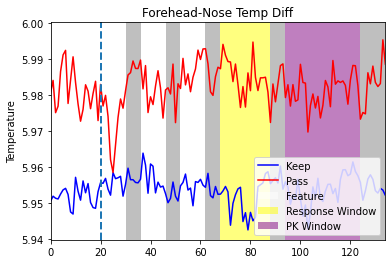

In [ ]:
plt.plot(keepDiff.T,color='blue',label='Keep')
plt.legend(loc='upper right')
plt.ylabel('Keep Temperature')
# plt.twinx()
plt.plot(passDiff.T,color='red',label='Pass')
plt.axvline(x=20,linestyle = '--',lw=2)
plt.axvspan(30,36,color = 'gray', alpha=0.5, lw=0)
plt.axvspan(46,52,color = 'gray', alpha=0.5, lw=0)
plt.axvspan(62,68,color = 'gray', alpha=0.5, lw=0)
plt.axvspan(88,94,color = 'gray', alpha=0.5, lw=0)
plt.axvspan(124,134,color = 'gray', alpha=0.5, lw=0)

plt.axvspan(20,30,color = 'white', alpha=0.5, lw=0)
plt.axvspan(36,46,color = 'white', alpha=0.5, lw=0)
plt.axvspan(52,62,color = 'white', alpha=0.5, lw=0,label='Feature')
plt.axvspan(68,88,color = 'yellow', alpha=0.5, lw=0,label = 'Response Window')
plt.axvspan(94,124,color = 'purple', alpha=0.5, lw=0,label = 'PK Window')
plt.legend(loc='lower right')
plt.ylabel('Temperature')
plt.xlim(0,134)
plt.title('Forehead-Nose Temp Diff')

plt.show()

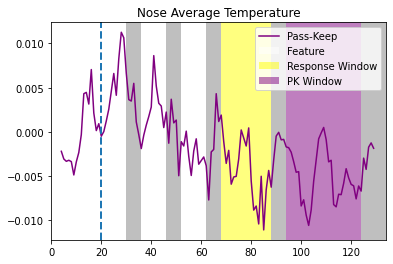

In [ ]:
passNoseTrials
passForeheadTrials
keepNoseTrials
keepForeheadTrials
# plt.plot(np.mean(passNoseTrials,axis=0),color='red',label = 'Pass') #np.arange(0,215),
# plt.plot(np.mean(keepNoseTrials,axis=0),color='blue',label = 'Keep') # np.arange(0,148)-20,
plt.plot(np.mean(passNoseTrials,axis=0)[:130] - np.mean(keepNoseTrials,axis=0)[:130],color='purple',label='Pass-Keep')
plt.axvline(x=20,linestyle = '--',lw=2)
plt.axvspan(30,36,color = 'gray', alpha=0.5, lw=0)
plt.axvspan(46,52,color = 'gray', alpha=0.5, lw=0)
plt.axvspan(62,68,color = 'gray', alpha=0.5, lw=0)
plt.axvspan(88,94,color = 'gray', alpha=0.5, lw=0)
plt.axvspan(124,134,color = 'gray', alpha=0.5, lw=0)

plt.axvspan(20,30,color = 'white', alpha=0.5, lw=0)
plt.axvspan(36,46,color = 'white', alpha=0.5, lw=0)
plt.axvspan(52,62,color = 'white', alpha=0.5, lw=0,label='Feature')
plt.axvspan(68,88,color = 'yellow', alpha=0.5, lw=0,label = 'Response Window')
plt.axvspan(94,124,color = 'purple', alpha=0.5, lw=0,label = 'PK Window')
plt.legend(loc='lower right')
plt.legend(loc='upper right')
plt.xlim((0,134))
# plt.ylim((-.03,.03))

plt.title('Nose Average Temperature')
plt.show()

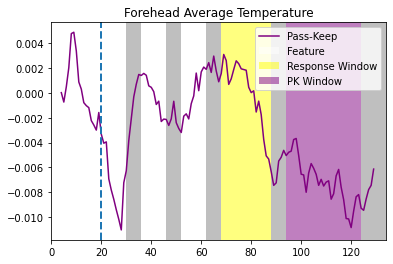

In [ ]:
# plt.plot(np.mean(passForeheadTrials,axis=0),color='red',label = 'Pass')
# plt.plot(np.mean(keepForeheadTrials,axis=0),color='blue',label = 'Keep')
plt.plot(np.mean(passForeheadTrials,axis=0)[:130] - np.mean(keepForeheadTrials,axis=0)[:130],color='purple',label='Pass-Keep')

plt.axvline(x=20,linestyle = '--',lw=2)
plt.axvspan(30,36,color = 'gray', alpha=0.5, lw=0)
plt.axvspan(46,52,color = 'gray', alpha=0.5, lw=0)
plt.axvspan(62,68,color = 'gray', alpha=0.5, lw=0)
plt.axvspan(88,94,color = 'gray', alpha=0.5, lw=0)
plt.axvspan(124,134,color = 'gray', alpha=0.5, lw=0)

plt.axvspan(20,30,color = 'white', alpha=0.5, lw=0)
plt.axvspan(36,46,color = 'white', alpha=0.5, lw=0)
plt.axvspan(52,62,color = 'white', alpha=0.5, lw=0,label='Feature')
plt.axvspan(68,88,color = 'yellow', alpha=0.5, lw=0,label = 'Response Window')
plt.axvspan(94,124,color = 'purple', alpha=0.5, lw=0,label = 'PK Window')
plt.legend(loc='upper right')
plt.xlim((0,134))
# plt.ylim((-.03,.03))

plt.title('Forehead Average Temperature')
plt.show()

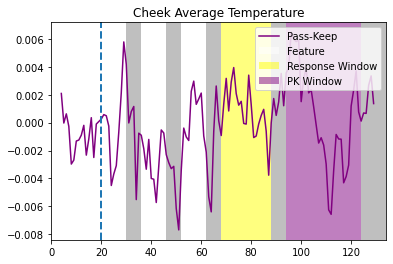

In [ ]:
# plt.plot(np.mean(passLeftTrials,axis=0),color='brown',label = 'Pass Left') #np.arange(0,215),
# plt.plot(np.mean(passRightTrials,axis=0),color='orange',label = 'Pass Right') #np.arange(0,215),
# plt.plot(np.mean(keepLeftTrials,axis=0),color='cyan',label = 'Keep Left') # np.arange(0,148)-20,
# plt.plot(np.mean(keepRightTrials,axis=0),color='green',label = 'Keep Right') # np.arange(0,148)-20,

passAvg = np.mean([np.mean(passRightTrials,axis=0),np.mean(passLeftTrials,axis=0)],axis=0)
keepAvg = np.mean([np.mean(keepRightTrials,axis=0),np.mean(keepLeftTrials,axis=0)],axis=0)
plt.plot(passAvg[:130] - keepAvg[:130],color='purple',label='Pass-Keep')

plt.axvline(x=20,linestyle = '--',lw=2)
plt.axvspan(30,36,color = 'gray', alpha=0.5, lw=0)
plt.axvspan(46,52,color = 'gray', alpha=0.5, lw=0)
plt.axvspan(62,68,color = 'gray', alpha=0.5, lw=0)
plt.axvspan(88,94,color = 'gray', alpha=0.5, lw=0)
plt.axvspan(124,134,color = 'gray', alpha=0.5, lw=0)

plt.axvspan(20,30,color = 'white', alpha=0.5, lw=0)
plt.axvspan(36,46,color = 'white', alpha=0.5, lw=0)
plt.axvspan(52,62,color = 'white', alpha=0.5, lw=0,label='Feature')
plt.axvspan(68,88,color = 'yellow', alpha=0.5, lw=0,label = 'Response Window')
plt.axvspan(94,124,color = 'purple', alpha=0.5, lw=0,label = 'PK Window')
plt.xlim(0,134)
plt.legend(loc='upper right')
# plt.ylim((-.03,.03))

plt.title('Cheek Average Temperature')
plt.show()

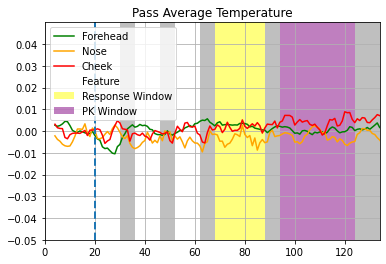

In [ ]:
# plt.plot(np.linspace(0,11750,215),np.mean(passForeheadTrials,axis=0),color='green',label = 'Forehead')
# plt.plot(np.linspace(0,11750,215),np.mean(passNoseTrials,axis=0),color='orange',label = 'Nose')
# # plt.plot(np.linspace(0,11750,215),np.mean(passLeftTrials,axis=0),color='blue',label = 'Left Cheek')
# # plt.plot(np.linspace(0,11750,215),np.mean(passRightTrials,axis=0),color='red',label = 'Right Cheek')
# plt.plot(np.linspace(0,11750,215),np.mean((passLeftTrials+passRightTrials)/2,axis=0),color='red',label = 'Cheek')

# plt.axvline(x=1000,linestyle = '--',lw=2)
# plt.axvspan(1500,1800,color = 'gray', alpha=0.5, lw=0)
# plt.axvspan(2300,2600,color = 'gray', alpha=0.5, lw=0)
# plt.axvspan(3100,3400,color = 'gray', alpha=0.5, lw=0)
# plt.axvspan(4400,4700,color = 'gray', alpha=0.5, lw=0)
# plt.axvspan(6700,7000,color = 'gray', alpha=0.5, lw=0)

# plt.axvspan(1000,1500,color = 'white', alpha=0.5, lw=0)
# plt.axvspan(1800,2300,color = 'white', alpha=0.5, lw=0)
# plt.axvspan(2600,3100,color = 'white', alpha=0.5, lw=0,label='Feature')
# plt.axvspan(3400,4400,color = 'yellow', alpha=0.5, lw=0,label = 'Response Window')
# plt.axvspan(4700,6200,color = 'purple', alpha=0.5, lw=0,label = 'PK Window')

plt.plot(np.mean(passForeheadTrials,axis=0),color='green',label = 'Forehead')
plt.plot(np.mean(passNoseTrials,axis=0),color='orange',label = 'Nose')
# plt.plot(np.linspace(0,11750,215),np.mean(passLeftTrials,axis=0),color='blue',label = 'Left Cheek')
# plt.plot(np.linspace(0,11750,215),np.mean(passRightTrials,axis=0),color='red',label = 'Right Cheek')
plt.plot(np.mean((passLeftTrials+passRightTrials)/2,axis=0),color='red',label = 'Cheek')
plt.axvline(x=20,linestyle = '--',lw=2)
plt.axvspan(30,36,color = 'gray', alpha=0.5, lw=0)
plt.axvspan(46,52,color = 'gray', alpha=0.5, lw=0)
plt.axvspan(62,68,color = 'gray', alpha=0.5, lw=0)
plt.axvspan(88,94,color = 'gray', alpha=0.5, lw=0)
plt.axvspan(124,134,color = 'gray', alpha=0.5, lw=0)

plt.axvspan(20,30,color = 'white', alpha=0.5, lw=0)
plt.axvspan(36,46,color = 'white', alpha=0.5, lw=0)
plt.axvspan(52,62,color = 'white', alpha=0.5, lw=0,label='Feature')
plt.axvspan(68,88,color = 'yellow', alpha=0.5, lw=0,label = 'Response Window')
plt.axvspan(94,124,color = 'purple', alpha=0.5, lw=0,label = 'PK Window')
plt.xlim(0,134)

plt.legend()
# plt.xlim((0,130))
plt.yticks(np.arange(-0.05,0.05,0.01))
plt.ylim((-.05,.05))
plt.grid()
plt.title('Pass Average Temperature')
plt.show()

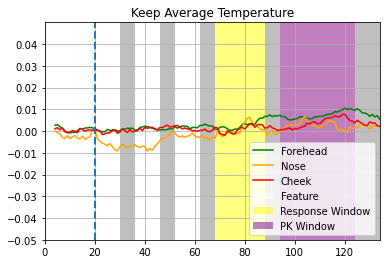

In [ ]:
# plt.plot(np.linspace(0,7400,148),np.mean(keepForeheadTrials,axis=0),color='green',label = 'Forehead')
# plt.plot(np.linspace(0,7400,148),np.mean(keepNoseTrials,axis=0),color='orange',label = 'Nose')
# # plt.plot(np.linspace(0,7400,148),np.mean(keepLeftTrials,axis=0),color='blue',label = 'Left Cheek')
# # plt.plot(np.linspace(0,7400,148),np.mean(keepRightTrials,axis=0),color='red',label = 'Right Cheek')
# plt.plot(np.linspace(0,7400,148),np.mean((keepLeftTrials+keepRightTrials)/2,axis=0),color='red',label = 'Cheek')

# plt.axvline(x=1000,linestyle = '--',lw=2)
# plt.axvspan(1500,1800,color = 'gray', alpha=0.5, lw=0)
# plt.axvspan(2300,2600,color = 'gray', alpha=0.5, lw=0)
# plt.axvspan(3100,3400,color = 'gray', alpha=0.5, lw=0)
# plt.axvspan(4400,4700,color = 'gray', alpha=0.5, lw=0)
# plt.axvspan(6700,7000,color = 'gray', alpha=0.5, lw=0)

# plt.axvspan(1000,1500,color = 'white', alpha=0.5, lw=0)
# plt.axvspan(1800,2300,color = 'white', alpha=0.5, lw=0)
# plt.axvspan(2600,3100,color = 'white', alpha=0.5, lw=0,label='Feature')
# plt.axvspan(3400,4400,color = 'yellow', alpha=0.5, lw=0,label = 'Response Window')
# plt.axvspan(4700,6200,color = 'purple', alpha=0.5, lw=0,label = 'PK Window')

plt.plot(np.mean(keepForeheadTrials,axis=0),color='green',label = 'Forehead')
plt.plot(np.mean(keepNoseTrials,axis=0),color='orange',label = 'Nose')
# plt.plot(np.linspace(0,7400,148),np.mean(keepLeftTrials,axis=0),color='blue',label = 'Left Cheek')
# plt.plot(np.linspace(0,7400,148),np.mean(keepRightTrials,axis=0),color='red',label = 'Right Cheek')
plt.plot(np.mean((keepLeftTrials+keepRightTrials)/2,axis=0),color='red',label = 'Cheek')
plt.axvline(x=20,linestyle = '--',lw=2)
plt.axvspan(30,36,color = 'gray', alpha=0.5, lw=0)
plt.axvspan(46,52,color = 'gray', alpha=0.5, lw=0)
plt.axvspan(62,68,color = 'gray', alpha=0.5, lw=0)
plt.axvspan(88,94,color = 'gray', alpha=0.5, lw=0)
plt.axvspan(124,134,color = 'gray', alpha=0.5, lw=0)

plt.axvspan(20,30,color = 'white', alpha=0.5, lw=0)
plt.axvspan(36,46,color = 'white', alpha=0.5, lw=0)
plt.axvspan(52,62,color = 'white', alpha=0.5, lw=0,label='Feature')
plt.axvspan(68,88,color = 'yellow', alpha=0.5, lw=0,label = 'Response Window')
plt.axvspan(94,124,color = 'purple', alpha=0.5, lw=0,label = 'PK Window')
plt.xlim((0,134))
plt.legend()

plt.yticks(np.arange(-0.05,0.05,0.01))
plt.ylim((-.05,.05))
plt.grid()
plt.title('Keep Average Temperature')
plt.show()

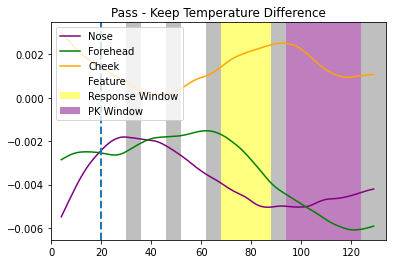

In [ ]:
n = np.mean(passNoseTrials,axis=0)[:130] - np.mean(keepNoseTrials,axis=0)[:130]
f = np.mean(passForeheadTrials,axis=0)[:130] - np.mean(keepForeheadTrials,axis=0)[:130]
c = passAvg[:130] - keepAvg[:130]

sr = 20
lo_f = .15
sos_low, w_low, h_low = makefiltersos(sr, lo_f, lo_f+5, gp=3, gs=20)
n = np.concatenate([np.full(4,np.nan), signal.sosfiltfilt(sos_low,n[4:],axis=0, padtype='odd')])
f = np.concatenate([np.full(4,np.nan), signal.sosfiltfilt(sos_low,f[4:],axis=0, padtype='odd')])
c = np.concatenate([np.full(4,np.nan), signal.sosfiltfilt(sos_low,c[4:],axis=0, padtype='odd')])


plt.plot(n,color='purple',label='Nose')
plt.plot(f,color='green',label='Forehead')
plt.plot(c,color='orange',label='Cheek')

plt.axvline(x=20,linestyle = '--',lw=2)
plt.axvspan(30,36,color = 'gray', alpha=0.5, lw=0)
plt.axvspan(46,52,color = 'gray', alpha=0.5, lw=0)
plt.axvspan(62,68,color = 'gray', alpha=0.5, lw=0)
plt.axvspan(88,94,color = 'gray', alpha=0.5, lw=0)
plt.axvspan(124,134,color = 'gray', alpha=0.5, lw=0)

plt.axvspan(20,30,color = 'white', alpha=0.5, lw=0)
plt.axvspan(36,46,color = 'white', alpha=0.5, lw=0)
plt.axvspan(52,62,color = 'white', alpha=0.5, lw=0,label='Feature')
plt.axvspan(68,88,color = 'yellow', alpha=0.5, lw=0,label = 'Response Window')
plt.axvspan(94,124,color = 'purple', alpha=0.5, lw=0,label = 'PK Window')
plt.xlim(0,134)
plt.legend(loc='upper left')
plt.title('Pass - Keep Temperature Difference')
plt.show()

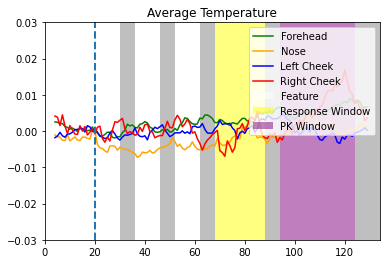

In [ ]:
plt.plot(np.arange(130),np.mean(np.concatenate((keepForeheadTrials[:,:130],passForeheadTrials[:,:130])),axis=0),color='green',label = 'Forehead')
plt.plot(np.arange(130),np.mean(np.concatenate((keepNoseTrials[:,:130],passNoseTrials[:,:130])),axis=0),color='orange',label = 'Nose')
plt.plot(np.arange(130),np.mean(np.concatenate((keepLeftTrials[:,:130],passLeftTrials[:,:130])),axis=0),color='blue',label = 'Left Cheek')
plt.plot(np.arange(130),np.mean(np.concatenate((keepRightTrials[:,:130],passRightTrials[:,:130])),axis=0),color='red',label = 'Right Cheek')
plt.axvline(x=20,linestyle = '--',lw=2)
plt.axvspan(30,36,color = 'gray', alpha=0.5, lw=0)
plt.axvspan(46,52,color = 'gray', alpha=0.5, lw=0)
plt.axvspan(62,68,color = 'gray', alpha=0.5, lw=0)
plt.axvspan(88,94,color = 'gray', alpha=0.5, lw=0)
plt.axvspan(124,134,color = 'gray', alpha=0.5, lw=0)

plt.axvspan(20,30,color = 'white', alpha=0.5, lw=0)
plt.axvspan(36,46,color = 'white', alpha=0.5, lw=0)
plt.axvspan(52,62,color = 'white', alpha=0.5, lw=0,label='Feature')
plt.axvspan(68,88,color = 'yellow', alpha=0.5, lw=0,label = 'Response Window')
plt.axvspan(94,124,color = 'purple', alpha=0.5, lw=0,label = 'PK Window')
plt.xlim(0,134)
plt.legend(loc='upper right')
plt.ylim((-.03,.03))

plt.title('Average Temperature')
plt.show()

In [ ]:
path = f'../data/Subject{sub}/{sub}Session{ses}/'
finalblk = sorted([i for i in os.listdir(path) if i.endswith('.csv')])[-1]

In [ ]:
fin= pd.read_csv(path+finalblk)
keep = []
correct = []
for i,j in fin.iterrows():
    di = eval(j['Experiment Data'])
    if di['Stim Type'] == 'opt':
        if di['Correct']:
            correct.append(True)
        else:
            correct.append(False)
        if di['Ask ML']:
            keep.append(False)
        else:
            keep.append(True)
keepCorrectArr = np.array(correct)[np.where(np.array(keep) == True)]
passCorrectArr = np.array(correct)[np.where(np.array(keep) == False)]
keepCorrectArr = keepCorrectArr[~np.isin(np.arange(keepCorrectArr.shape[0]), keepInvalidTrials)]
passCorrectArr = passCorrectArr[~np.isin(np.arange(passCorrectArr.shape[0]), passInvalidTrials)]

In [ ]:
keepCorrectArr[~np.isin(np.arange(keepCorrectArr.shape[0]), keepInvalidTrials)].shape

(106,)

In [ ]:
keepForeheadTrials.shape,keepInvalidTrials.shape,np.array(correct)[np.where(np.array(keep) == True)].shape

((121, 148), (170,), (154,))

In [ ]:
# for c,f,n,l,r in zip(keepCorrectArr , keepForeheadTrials, keepNoseTrials, keepLeftTrials, keepRightTrials):
plt.plot(np.mean(keepForeheadTrials[np.where(keepCorrectArr == True)],axis=0),color = 'blue',label = 'Keep Correct')
plt.plot(np.mean(keepForeheadTrials[np.where(keepCorrectArr == False)],axis=0),color = 'red',label = 'Keep Wrong')
plt.plot(np.mean(passForeheadTrials[np.where(passCorrectArr == True)],axis=0),color = 'green',label = 'Pass Correct')
plt.plot(np.mean(passForeheadTrials[np.where(passCorrectArr == False)],axis=0),color = 'orange',label = 'Pass Wrong')
plt.axvline(x=20,linestyle = '--',lw=2)
plt.axvspan(30,36,color = 'gray', alpha=0.5, lw=0)
plt.axvspan(46,52,color = 'gray', alpha=0.5, lw=0)
plt.axvspan(62,68,color = 'gray', alpha=0.5, lw=0)
plt.axvspan(88,94,color = 'gray', alpha=0.5, lw=0)
plt.axvspan(124,134,color = 'gray', alpha=0.5, lw=0)

plt.axvspan(20,30,color = 'white', alpha=0.5, lw=0)
plt.axvspan(36,46,color = 'white', alpha=0.5, lw=0)
plt.axvspan(52,62,color = 'white', alpha=0.5, lw=0,label='Feature')
plt.axvspan(68,88,color = 'yellow', alpha=0.5, lw=0,label = 'Response Window')
plt.axvspan(94,124,color = 'purple', alpha=0.5, lw=0,label = 'PK Window')
plt.xlim(0,134)
plt.legend()
plt.ylim((-.03,.03))
plt.show()

IndexError: index 122 is out of bounds for axis 0 with size 121

In [ ]:
plt.plot(np.mean(keepNoseTrials[np.where(keepCorrectArr == True)],axis=0),color = 'blue',label = 'Keep Correct')
plt.plot(np.mean(keepNoseTrials[np.where(keepCorrectArr == False)],axis=0),color = 'red',label = 'Keep Wrong')
plt.plot(np.mean(passNoseTrials[np.where(passCorrectArr == True)],axis=0),color = 'green',label = 'Pass Correct')
plt.plot(np.mean(passNoseTrials[np.where(passCorrectArr == False)],axis=0),color = 'orange',label = 'Pass Wrong')
plt.axvline(x=10,linestyle = '--',lw=2)
plt.axvspan(20,26,color = 'gray', alpha=0.5, lw=0)
plt.axvspan(36,42,color = 'gray', alpha=0.5, lw=0)
plt.axvspan(52,58,color = 'gray', alpha=0.5, lw=0)
plt.axvspan(78,84,color = 'gray', alpha=0.5, lw=0)
plt.axvspan(120,130,color = 'gray', alpha=0.5, lw=0)

plt.axvspan(10,20,color = 'white', alpha=0.5, lw=0)
plt.axvspan(26,36,color = 'white', alpha=0.5, lw=0)
plt.axvspan(42,52,color = 'white', alpha=0.5, lw=0,label='Feature')
plt.axvspan(58,78,color = 'yellow', alpha=0.5, lw=0,label = 'Response Window')
plt.axvspan(84,120,color = 'purple', alpha=0.5, lw=0,label = 'PK Window')
plt.legend()
plt.xlim(0,130)
plt.ylim((-.03,.03))
plt.show()

IndexError: index 120 is out of bounds for axis 0 with size 120

In [ ]:
plt.plot(np.mean(keepLeftTrials[np.where(keepCorrectArr == True)],axis=0),color = 'blue',label = 'Keep Correct')
plt.plot(np.mean(keepLeftTrials[np.where(keepCorrectArr == False)],axis=0),color = 'red',label = 'Keep Wrong')
plt.plot(np.mean(passLeftTrials[np.where(passCorrectArr == True)],axis=0),color = 'green',label = 'Pass Correct')
plt.plot(np.mean(passLeftTrials[np.where(passCorrectArr == False)],axis=0),color = 'orange',label = 'Pass Wrong')
plt.axvline(x=10,linestyle = '--',lw=2)
plt.axvspan(20,26,color = 'gray', alpha=0.5, lw=0)
plt.axvspan(36,42,color = 'gray', alpha=0.5, lw=0)
plt.axvspan(52,58,color = 'gray', alpha=0.5, lw=0)
plt.axvspan(78,84,color = 'gray', alpha=0.5, lw=0)
plt.axvspan(120,130,color = 'gray', alpha=0.5, lw=0)

plt.axvspan(10,20,color = 'white', alpha=0.5, lw=0)
plt.axvspan(26,36,color = 'white', alpha=0.5, lw=0)
plt.axvspan(42,52,color = 'white', alpha=0.5, lw=0,label='Feature')
plt.axvspan(58,78,color = 'yellow', alpha=0.5, lw=0,label = 'Response Window')
plt.axvspan(84,120,color = 'purple', alpha=0.5, lw=0,label = 'PK Window')
plt.legend()
plt.xlim(0,130)
plt.ylim((-.03,.03))
plt.show()

IndexError: index 120 is out of bounds for axis 0 with size 120

In [ ]:
plt.plot(np.mean(keepRightTrials[np.where(keepCorrectArr == True)],axis=0),color = 'blue',label = 'Keep Correct')
plt.plot(np.mean(keepRightTrials[np.where(keepCorrectArr == False)],axis=0),color = 'red',label = 'Keep Wrong')
plt.plot(np.mean(passRightTrials[np.where(passCorrectArr == True)],axis=0),color = 'green',label = 'Pass Correct')
plt.plot(np.mean(passRightTrials[np.where(passCorrectArr == False)],axis=0),color = 'orange',label = 'Pass Wrong')
plt.axvline(x=10,linestyle = '--',lw=2)
plt.axvspan(20,26,color = 'gray', alpha=0.5, lw=0)
plt.axvspan(36,42,color = 'gray', alpha=0.5, lw=0)
plt.axvspan(52,58,color = 'gray', alpha=0.5, lw=0)
plt.axvspan(78,84,color = 'gray', alpha=0.5, lw=0)
plt.axvspan(120,130,color = 'gray', alpha=0.5, lw=0)

plt.axvspan(10,20,color = 'white', alpha=0.5, lw=0)
plt.axvspan(26,36,color = 'white', alpha=0.5, lw=0)
plt.axvspan(42,52,color = 'white', alpha=0.5, lw=0,label='Feature')
plt.axvspan(58,78,color = 'yellow', alpha=0.5, lw=0,label = 'Response Window')
plt.axvspan(84,120,color = 'purple', alpha=0.5, lw=0,label = 'PK Window')
plt.legend()
plt.xlim(0,130)
plt.ylim((-.03,.03))
plt.show()

IndexError: index 120 is out of bounds for axis 0 with size 120

In [ ]:
'''Nose changes'''
passChange = np.nanmean(np.mean(passNoseTrials,axis=0)[-20:]) - np.nanmean(np.mean(passNoseTrials,axis=0)[:20])
keepChange = np.nanmean(np.mean(keepNoseTrials,axis=0)[-20:]) - np.nanmean(np.mean(keepNoseTrials,axis=0)[:20])
keepChange,passChange

(0.006597916666666667, -0.0031329787234042556)

In [ ]:
'''Forehead changes'''
passChange = np.nanmean(np.mean(passForeheadTrials,axis=0)[-20:]) - np.nanmean(np.mean(passForeheadTrials,axis=0)[:20])
keepChange = np.nanmean(np.mean(keepForeheadTrials,axis=0)[-20:]) - np.nanmean(np.mean(keepForeheadTrials,axis=0)[:20])
keepChange,passChange

(0.006344791666666665, 0.010510638297872337)

In [ ]:
'''Cheek changes'''
passChange = np.nanmean(passAvg[-20:]) - np.nanmean(passAvg[:20])
keepChange = np.nanmean(keepAvg[-20:]) - np.nanmean(keepAvg[:20])
passChange,keepChange

(0.014448138297872339, 0.003060937500000001)

In [154]:
'''Nose changes'''
passChange = np.nanmax(np.mean(passNoseTrials,axis=0)) - np.nanmin(np.mean(passNoseTrials,axis=0))
keepChange = np.nanmax(np.mean(keepNoseTrials,axis=0)) - np.nanmin(np.mean(keepNoseTrials,axis=0))
keepChange,passChange

(0.020000000000000007, 0.03595744680851065)

In [155]:
'''Forehead changes'''
passChange = np.nanmax(np.mean(passForeheadTrials,axis=0)) - np.nanmin(np.mean(passForeheadTrials,axis=0))
keepChange = np.nanmax(np.mean(keepForeheadTrials,axis=0)) - np.nanmin(np.mean(keepForeheadTrials,axis=0))
keepChange,passChange

(0.0285, 0.04702127659574468)

In [156]:
'''Cheek changes'''
passChange = np.nanmax(passAvg) - np.nanmin(passAvg)
keepChange = np.nanmax(keepAvg) - np.nanmin(keepAvg)
keepChange,passChange

(0.011166666666666672, 0.031276595744680856)

In [64]:
numTrials = 295
# images = 145
passTrialInd = []
keepTrialInd = []
# changed structure for shane
path = f'../../thermal/Shane/Subject{sub}/{sub}Session{ses}/'
try:
    for trial in range(numTrials):
        title = 'Trial:' + str(trial)
    
        timeStamp = np.load(path + 'timeStamp/timeStampBlocktrial' + str(trial) + '.npy')
        timeStamp =  timeStamp / 10000000
        totalFrames = timeStamp.shape[0] #int(1.05 * 65 * 20)
        collectedFrames = totalFrames - np.sum(timeStamp == 0)
    
        if collectedFrames < 160:
            keepTrialInd.append(trial)
        elif collectedFrames < 230:
            passTrialInd.append(trial)
except FileNotFoundError:
    pass
validPassTrialInd = [j for i,j in enumerate(passTrialInd) if i not in passInvalidTrials]
validKeepTrialInd = [j for i,j in enumerate(keepTrialInd) if i not in keepInvalidTrials]

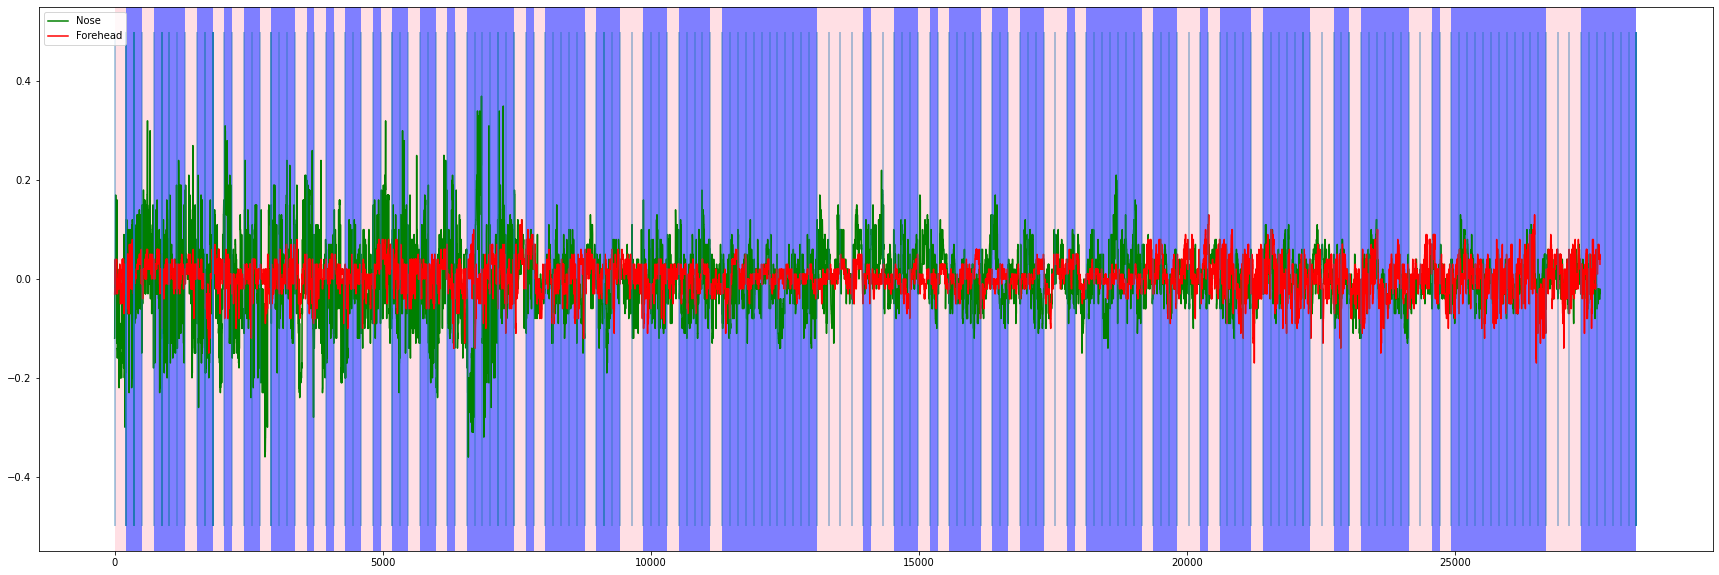

In [65]:
fullNoseData=np.full((295,215),np.nan)
fullForeData=np.full((295,215),np.nan)
startArr = np.full(295,0)

for i in zip(validKeepTrialInd,keepNoseTrials):
    fullNoseData[i[0],0:len(i[1])] = i[1]
    startArr[i[0]] = 148
for i in zip(validPassTrialInd,passNoseTrials):
    fullNoseData[i[0],0:len(i[1])] = i[1]
    startArr[i[0]] = 215
for i in zip(validKeepTrialInd,keepForeheadTrials):
    fullForeData[i[0],0:len(i[1])] = i[1]
for i in zip(validPassTrialInd,passForeheadTrials):
    fullForeData[i[0],0:len(i[1])] = i[1]

def removeNan(x):
    return x[~np.isnan(x)]

# fullNoseData = removeNan(fullNoseData.flatten())
# fullForeData = removeNan(fullForeData.flatten())
startArr = removeNan(startArr)

startArr = np.r_[0, startArr].cumsum()[:-1]

# pltNose = removeNan(fullNoseData.flatten()) - np.mean(removeNan(fullNoseData.flatten())[:10])
# pltFore = removeNan(fullForeData.flatten()) - np.mean(removeNan(fullForeData.flatten())[:10])
plt.figure(figsize=(30,10))
plt.plot(removeNan(fullNoseData.flatten()),color = 'green',label = 'Nose')
plt.plot(removeNan(fullForeData.flatten()),color = 'red',label = 'Forehead')
# plt.plot(fullNoseData.flatten(),color = 'green',label = 'Nose')
# plt.plot(fullForeData.flatten(),color = 'red',label = 'Forehead')
for start in (validKeepTrialInd):
    plt.axvspan(startArr[start],startArr[start] + 148,color = 'blue', alpha=0.5, lw=0)
for start in (validPassTrialInd):
    plt.axvspan(startArr[start],startArr[start] + 215,color = 'pink', alpha=0.5, lw=0)
plt.vlines(startArr,ymin = -0.5,ymax=0.5,alpha=.5)
plt.legend()
plt.show()

In [ ]:
for i in np.arange(0,295,3):
    plt.figure(figsize=(30,10))
    plt.plot(removeNan(fullNoseData.flatten()),color = 'green',label = 'Nose')
    plt.plot(removeNan(fullForeData.flatten()),color = 'red',label = 'Forehead')
    # plt.plot(fullNoseData.flatten(),color = 'green',label = 'Nose')
    # plt.plot(fullForeData.flatten(),color = 'red',label = 'Forehead')
    for start in (validKeepTrialInd):
        plt.axvspan(startArr[start],startArr[start] + 148,color = 'blue', alpha=0.5, lw=0)
    plt.axvspan(startArr[start],startArr[start] + 148,color = 'blue', alpha=0.5, lw=0,label = 'Keep')
    for start in (validPassTrialInd):
        plt.axvspan(startArr[start],startArr[start] + 215,color = 'pink', alpha=0.5, lw=0)
    plt.axvspan(startArr[start],startArr[start] + 215,color = 'pink', alpha=0.5, lw=0,label='Pass')
    plt.vlines(startArr,ymin = -0.5,ymax=0.5,alpha=.5)
    plt.axhline(removeNan(fullNoseData.flatten())[startArr[i]],linestyle='--',color='green')
    plt.axhline(removeNan(fullForeData.flatten())[startArr[i]],linestyle='--',color='red')
    try:
        plt.xlim(startArr[i],startArr[i+3])
    except IndexError:
        plt.xlim(startArr[i],startArr[-1])
    plt.ylim(-0.5,0.5)
    plt.legend()
    plt.show()

In [67]:
removeNan(fullForeData.flatten()).min(),removeNan(fullForeData.flatten()).max()

(-0.17, 0.13)

In [68]:
removeNan(fullNoseData.flatten()).min(),removeNan(fullNoseData.flatten()).max()

(-0.36, 0.37)

In [69]:
keepNoseTrials.shape, passNoseTrials.shape

((122, 148), (48, 215))

In [70]:
len(keepTrialInd),len(passTrialInd)

(146, 59)

In [59]:
passNoseTrials

keepForeheadTrials.shape,passForeheadTrials.shape

((122, 148), (48, 215))

In [60]:
keepInvalidTrials,passInvalidTrials

(array([  0,   1,   3,   4,   5,   6,   7,   8,   9,  10,  13,  14,  19,
         21,  22,  23,  24,  28,  29,  38,  48,  51,  59, 116]),
 array([ 1,  2,  3,  4,  5,  7,  8, 10, 11, 26, 51]))

In [73]:
np.mean(removeNan(fullNoseData.flatten())[:10])

-0.008

In [61]:
nose_stream = np.array([j for i in full_nose_roi_data for j in i ])
forehead_stream = np.array([j for i in full_forehead_roi_data for j in i ])
left_cheek_stream = np.array([j for i in full_left_cheek_roi_data for j in i ])
right_cheek_stream = np.array([j for i in full_right_cheek_roi_data for j in i ])
cheek_stream = (left_cheek_stream + right_cheek_stream)/2

cheek_stream -= np.mean(cheek_stream[:10])
nose_stream -= np.mean(nose_stream[:10])
forehead_stream -= np.mean(forehead_stream[:10])

# sr = 20
# lo_f = .15
# sos_low, w_low, h_low = makefiltersos(sr, lo_f, lo_f+5, gp=3, gs=20)
# cheek_stream = signal.sosfiltfilt(sos_low,cheek_stream, padtype='odd')
# nose_stream = signal.sosfiltfilt(sos_low,nose_stream, padtype='odd')
# forehead_stream = signal.sosfiltfilt(sos_low,forehead_stream, padtype='odd')

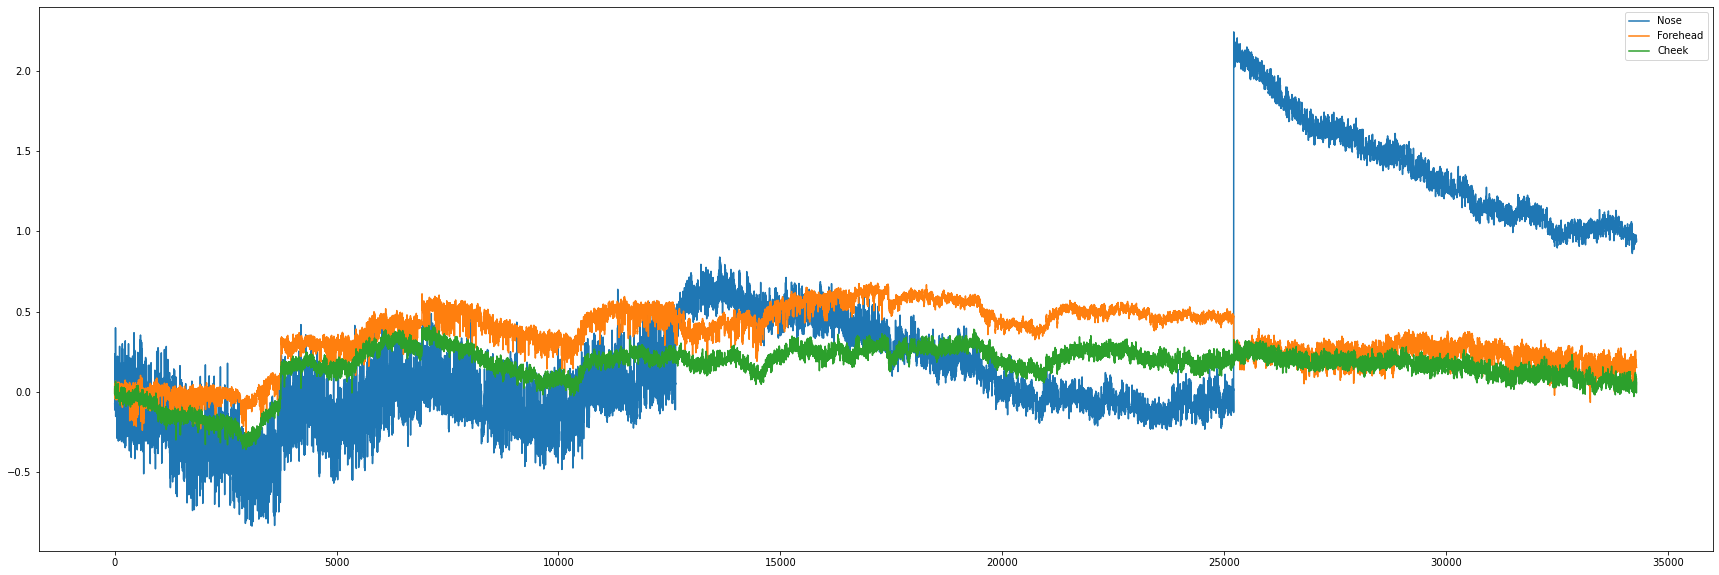

In [62]:
plt.figure(figsize = (30,10))
plt.plot(nose_stream,label='Nose')
plt.plot(forehead_stream, label = 'Forehead')
plt.plot(cheek_stream,label = 'Cheek')
plt.legend()
plt.show()

In [64]:
from scipy.interpolate import splrep, BSpline

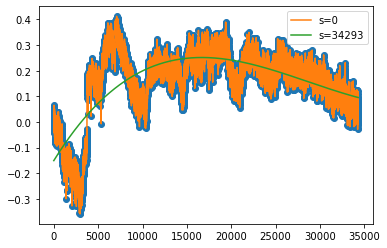

In [65]:
tck = splrep(np.arange(len(cheek_stream)),cheek_stream, s=0)
tck_s = splrep(np.arange(len(cheek_stream)),cheek_stream, s=len(cheek_stream))
plt.plot(np.arange(len(cheek_stream)),cheek_stream, 'o')
plt.plot(np.arange(len(cheek_stream)), BSpline(*tck)(np.arange(len(cheek_stream))), '-', label='s=0')
plt.plot(np.arange(len(cheek_stream)), BSpline(*tck_s)(np.arange(len(cheek_stream))), '-', label=f's={len(cheek_stream)}')
plt.legend()
plt.show()

In [66]:
a = BSpline(*tck_s)(np.arange(len(cheek_stream)))

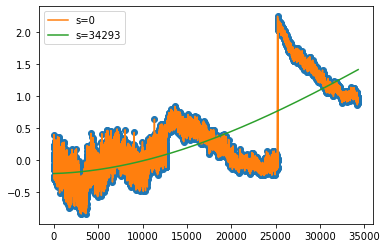

In [67]:
tck = splrep(np.arange(len(nose_stream)),nose_stream, s=0)
tck_s = splrep(np.arange(len(nose_stream)),nose_stream, s=len(cheek_stream))
plt.plot(np.arange(len(nose_stream)),nose_stream, 'o')
plt.plot(np.arange(len(nose_stream)), BSpline(*tck)(np.arange(len(nose_stream))), '-', label='s=0')
plt.plot(np.arange(len(nose_stream)), BSpline(*tck_s)(np.arange(len(nose_stream))), '-', label=f's={len(nose_stream)}')
plt.legend()
plt.show()

In [68]:
b = BSpline(*tck_s)(np.arange(len(nose_stream)))

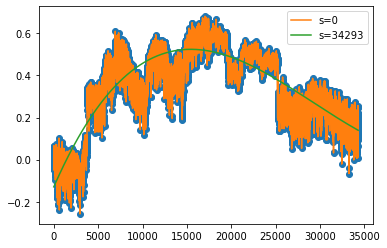

In [69]:
tck = splrep(np.arange(len(forehead_stream)),forehead_stream, s=0)
tck_s = splrep(np.arange(len(forehead_stream)),forehead_stream, s=len(forehead_stream))
plt.plot(np.arange(len(forehead_stream)),forehead_stream, 'o')
plt.plot(np.arange(len(forehead_stream)), BSpline(*tck)(np.arange(len(forehead_stream))), '-', label='s=0')
plt.plot(np.arange(len(forehead_stream)), BSpline(*tck_s)(np.arange(len(forehead_stream))), '-', label=f's={len(forehead_stream)}')
plt.legend()
plt.show()

In [70]:
c = BSpline(*tck_s)(np.arange(len(forehead_stream)))

In [71]:
image =             cv2.polylines(normalized_thermal_image, [pts], 
                                  isClosed, color, 
                                  thickness)

NameError: name 'isClosed' is not defined

In [72]:
x = [j[0] for i in pts for j in i]
y = [j[1] for i in pts for j in i]
int(np.mean(x)),int(np.mean(y))

(205, 187)

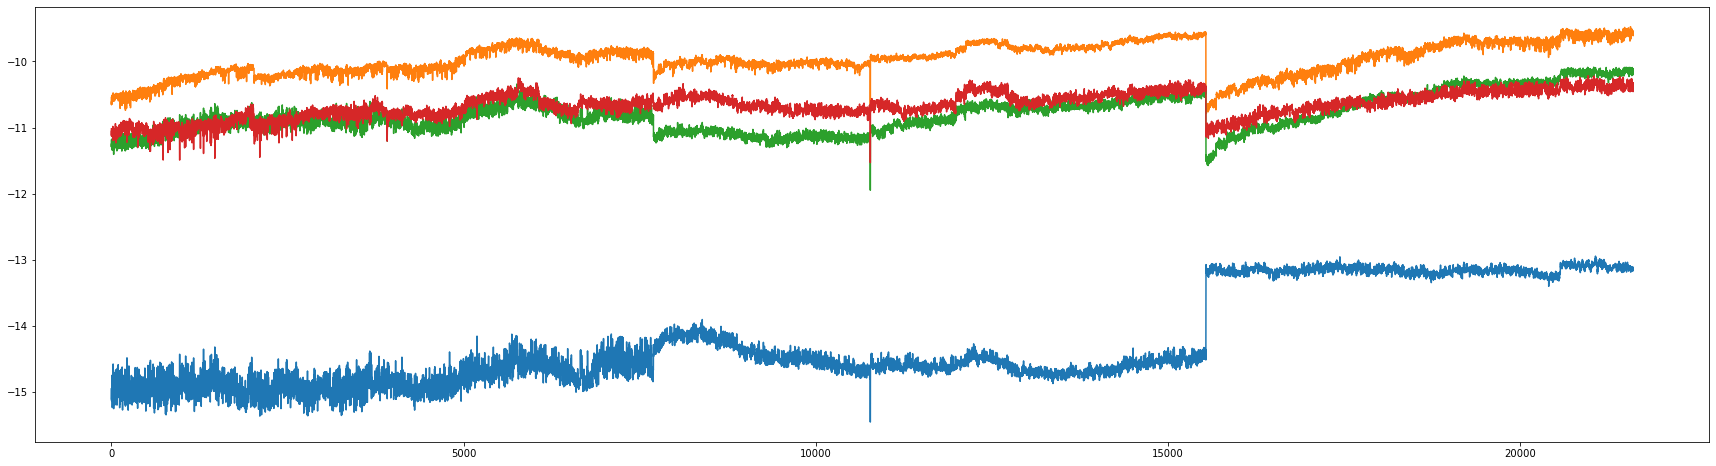

In [73]:
plt.figure(figsize=(30,8))
plt.plot([j for i in np.array(keep_nose_roi_data)-np.array(keep_room_temp_data) for j in i])
plt.plot([j for i in np.array(keep_forehead_roi_data)-np.array(keep_room_temp_data) for j in i])
plt.plot([j for i in np.array(keep_left_cheek_roi_data)-np.array(keep_room_temp_data) for j in i])
plt.plot([j for i in np.array(keep_right_cheek_roi_data)-np.array(keep_room_temp_data) for j in i])
plt.show()

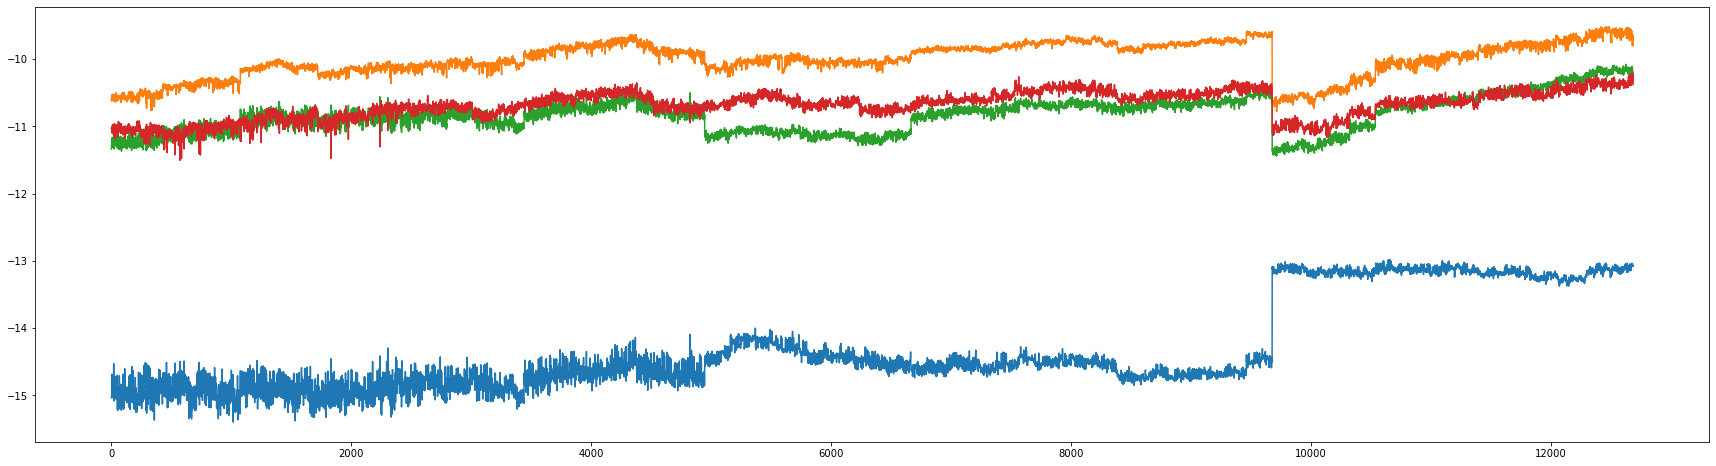

In [74]:
plt.figure(figsize=(30,8))
plt.plot([j for i in np.array(pass_nose_roi_data)-np.array(pass_room_temp_data) for j in i])
plt.plot([j for i in np.array(pass_forehead_roi_data)-np.array(pass_room_temp_data) for j in i])
plt.plot([j for i in np.array(pass_left_cheek_roi_data)-np.array(pass_room_temp_data) for j in i])
plt.plot([j for i in np.array(pass_right_cheek_roi_data)-np.array(pass_room_temp_data) for j in i])
plt.show()

In [75]:
s1ts = 0
for i in full_room_temp_data[:75]:
    s1ts+=len(i)
s2ts = 0
for i in full_room_temp_data[75:150]:
    s2ts+=len(i)
s3ts = 0
for i in full_room_temp_data[150:225]:
    s3ts+=len(i)
s4ts = 0
for i in full_room_temp_data[225:]:
    s4ts+=len(i)
s1ts,s2ts,s3ts,s4ts

(12641, 12574, 9078, 0)

-1.0257777777777726 -0.2937777777777697 -0.16133333333333866 -0.34400000000000475 0.16622222222222405


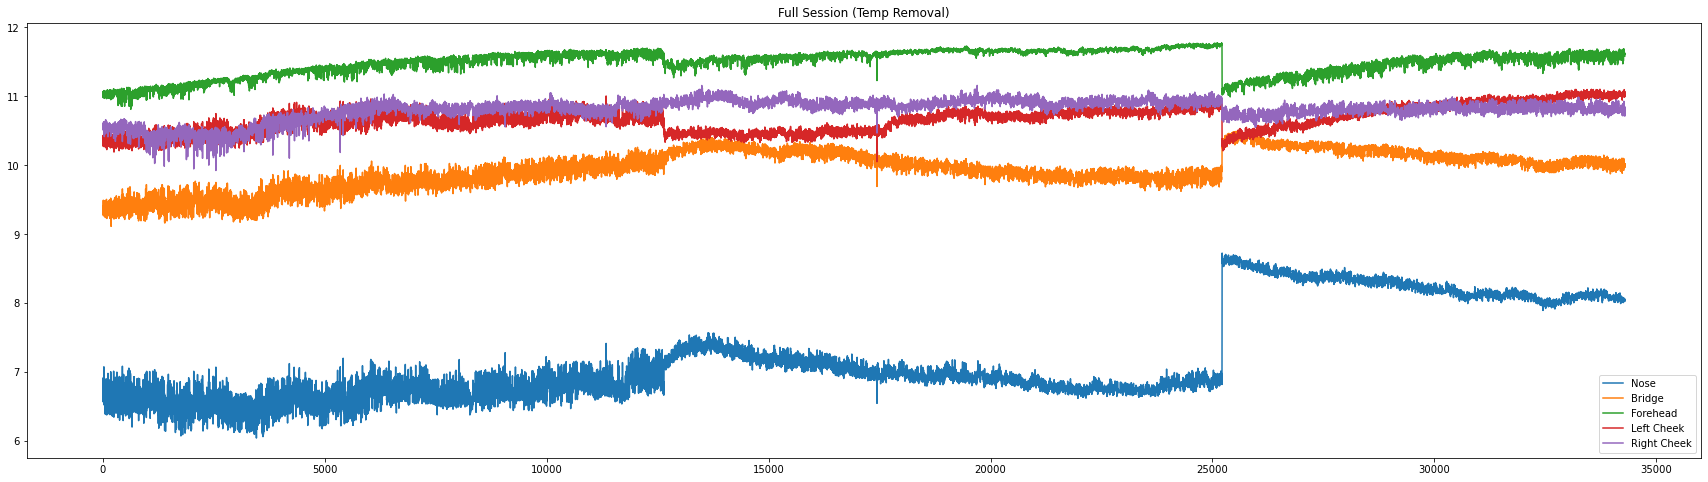

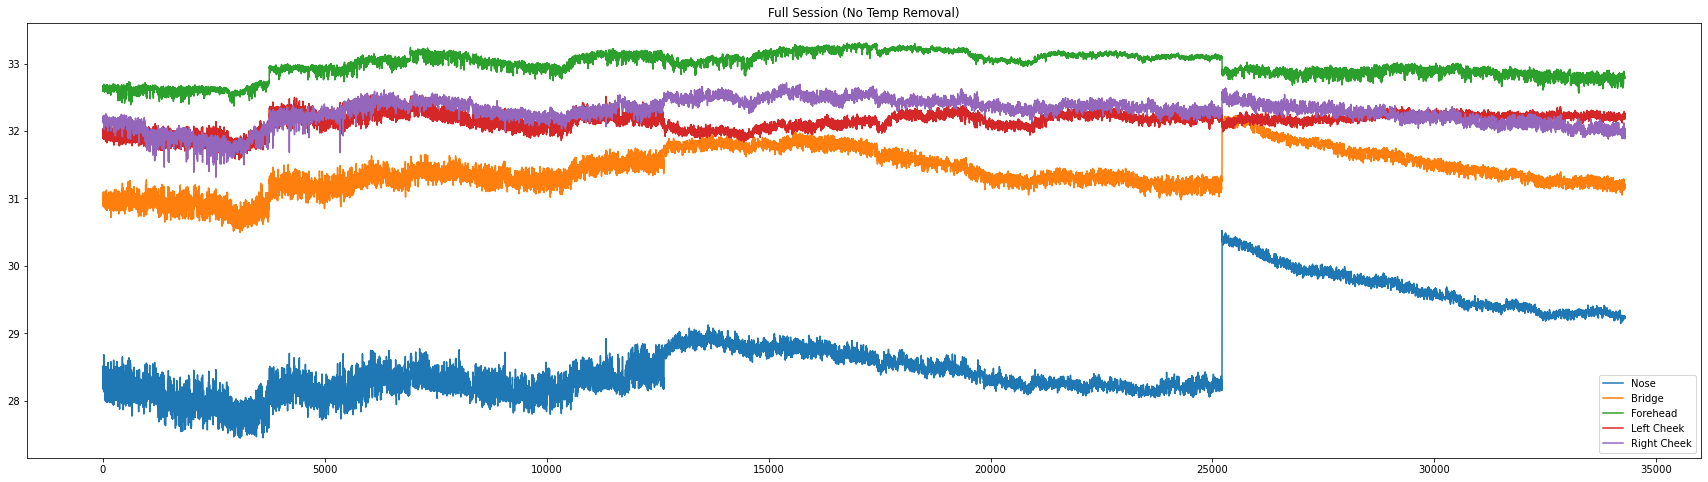

In [76]:
from scipy import ndimage
from scipy.signal import detrend
fullNose = np.array([j for i in full_nose_roi_data for j in i])
fullBridge = np.array([j for i in full_bridge_roi_data for j in i])
fullForehead = np.array([j for i in full_forehead_roi_data for j in i])
fullLeftCheek = np.array([j for i in full_left_cheek_roi_data for j in i])
fullRightCheek = np.array([j for i in full_right_cheek_roi_data for j in i])
fullRoom = np.array([j for i in full_room_temp_data for j in i])
print(fullNose[0] - fullNose[-1]
    , fullBridge[0] - fullBridge[-1]
    , fullForehead[0] - fullForehead[-1]
    , fullLeftCheek[0]-fullLeftCheek[-1]
    , fullRightCheek[0]-fullRightCheek[-1])
# s1ts,s2ts,s3ts,s4ts
plt.figure(figsize=(30,8))
plt.plot(fullNose-fullRoom,label='Nose')
plt.plot(fullBridge-fullRoom,label='Bridge')
plt.plot(fullForehead-fullRoom,label='Forehead')
plt.plot(fullLeftCheek-fullRoom,label='Left Cheek')
plt.plot(fullRightCheek-fullRoom,label='Right Cheek')
plt.title('Full Session (Temp Removal)')
plt.legend()
# plt.vlines([s1ts,s1ts+s2ts,s1ts+s2ts+s3ts],-5,3)
plt.show()
plt.figure(figsize=(30,8))
plt.plot(fullNose,label='Nose')
plt.plot(fullBridge,label='Bridge')
plt.plot(fullForehead,label='Forehead')
plt.plot(fullLeftCheek,label='Left Cheek')
plt.plot(fullRightCheek,label='Right Cheek')
plt.title('Full Session (No Temp Removal)')
plt.legend()
# plt.vlines([s1ts,s1ts+s2ts,s1ts+s2ts+s3ts],28,34)
plt.show()

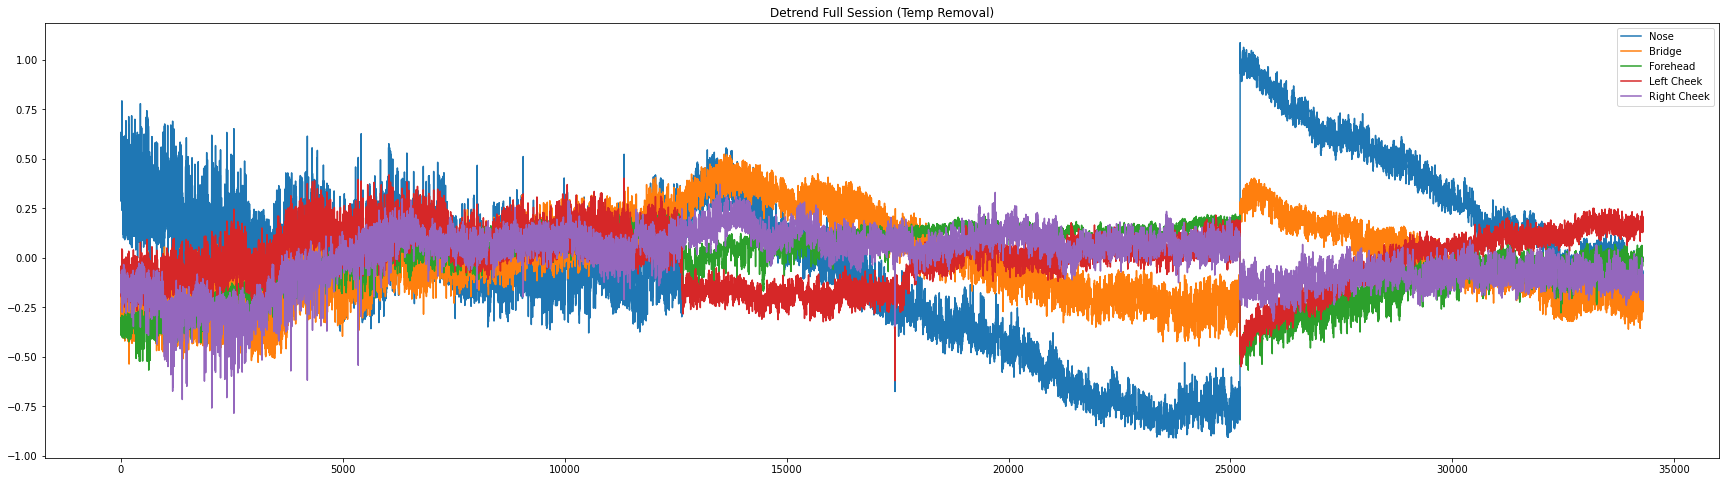

In [77]:
plt.figure(figsize=(30,8))
plt.plot(detrend(fullNose-fullRoom),label='Nose')
plt.plot(detrend(fullBridge-fullRoom),label='Bridge')
plt.plot(detrend(fullForehead-fullRoom),label='Forehead')
plt.plot(detrend(fullLeftCheek-fullRoom),label='Left Cheek')
plt.plot(detrend(fullRightCheek-fullRoom),label='Right Cheek')
plt.title('Detrend Full Session (Temp Removal)')
plt.legend()
# plt.vlines([s1ts,s1ts+s2ts,s1ts+s2ts+s3ts],-1.5,2)
plt.show()

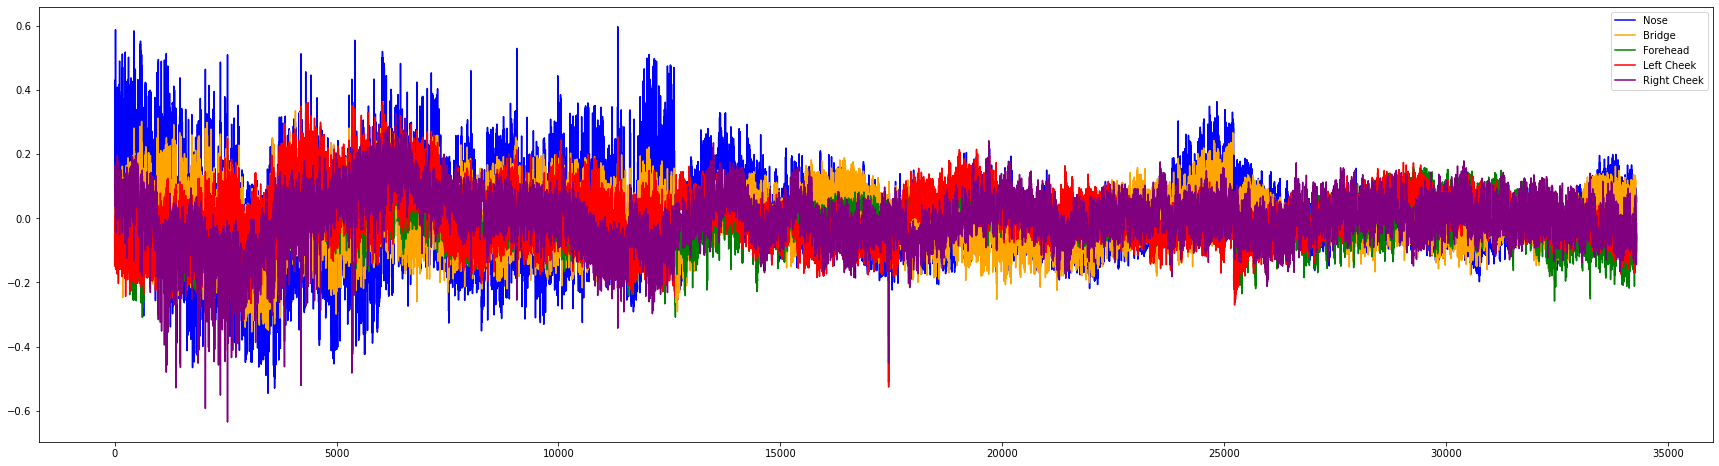

In [82]:
plt.figure(figsize=(30,8))
for ss in [(0,s1ts),(s1ts,s1ts+s2ts),(s1ts+s2ts,s1ts+s2ts+s3ts),(s1ts+s2ts+s3ts,len(fullRoom))]:
    if ss[1]-ss[0] == 0:
        continue
    plt.plot(np.arange(ss[0],ss[1]),detrend(fullNose[ss[0]:ss[1]]-fullRoom[ss[0]:ss[1]]),color='blue',label='Nose')
    plt.plot(np.arange(ss[0],ss[1]),detrend(fullBridge[ss[0]:ss[1]]-fullRoom[ss[0]:ss[1]]),color='orange',label='Bridge')
    plt.plot(np.arange(ss[0],ss[1]),detrend(fullForehead[ss[0]:ss[1]]-fullRoom[ss[0]:ss[1]]),color='green',label='Forehead')
    plt.plot(np.arange(ss[0],ss[1]),detrend(fullLeftCheek[ss[0]:ss[1]]-fullRoom[ss[0]:ss[1]]),color='red',label='Left Cheek')
    plt.plot(np.arange(ss[0],ss[1]),detrend(fullRightCheek[ss[0]:ss[1]]-fullRoom[ss[0]:ss[1]]),color='purple',label = 'Right Cheek')
# plt.vlines([s1ts,s1ts+s2ts,s1ts+s2ts+s3ts],-1,1)
plt.legend(labels = ['Nose','Bridge','Forehead','Left Cheek','Right Cheek'])
plt.show()

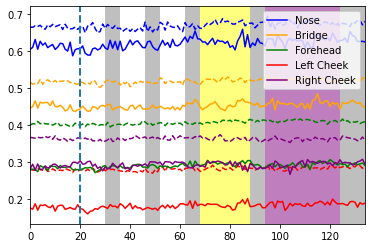

In [85]:
ntemp = np.array(keep_nose_roi_data)-np.array(keep_room_temp_data)
btemp = np.array(keep_bridge_roi_data)-np.array(keep_room_temp_data)
ftemp = np.array(keep_forehead_roi_data)-np.array(keep_room_temp_data)
ltemp = np.array(keep_left_cheek_roi_data)-np.array(keep_room_temp_data)
rtemp = np.array(keep_right_cheek_roi_data)-np.array(keep_room_temp_data)
plt.plot((np.mean(ntemp,axis=0)-np.mean(ntemp[:10])).T,linestyle='--',color='blue')
plt.plot((np.mean(btemp,axis=0)-np.mean(btemp[:10])).T,linestyle='--',color='orange')
plt.plot((np.mean(ftemp,axis=0)-np.mean(ftemp[:10])).T,linestyle='--',color='green')
plt.plot((np.mean(ltemp,axis=0)-np.mean(ltemp[:10])).T,linestyle='--',color='red')
plt.plot((np.mean(rtemp,axis=0)-np.mean(rtemp[:10])).T,linestyle='--',color='purple')

# plt.twinx()
ntemp = np.array(pass_nose_roi_data)-np.array(pass_room_temp_data)
btemp = np.array(pass_bridge_roi_data)-np.array(pass_room_temp_data)
ftemp = np.array(pass_forehead_roi_data)-np.array(pass_room_temp_data)
ltemp = np.array(pass_left_cheek_roi_data)-np.array(pass_room_temp_data)
rtemp = np.array(pass_right_cheek_roi_data)-np.array(pass_room_temp_data)
plt.plot((np.mean(ntemp,axis=0)-np.mean(ntemp[:10])).T,color='blue',label='Nose')
plt.plot((np.mean(btemp,axis=0)-np.mean(btemp[:10])).T,color='orange',label='Bridge')
plt.plot((np.mean(ftemp,axis=0)-np.mean(ftemp[:10])).T,color='green',label='Forehead')
plt.plot((np.mean(ltemp,axis=0)-np.mean(ltemp[:10])).T,color='red',label='Left Cheek')
plt.plot((np.mean(rtemp,axis=0)-np.mean(rtemp[:10])).T,color='purple',label='Right Cheek')
plt.legend()
plt.axvline(x=20,linestyle = '--',lw=2)
plt.axvspan(30,36,color = 'gray', alpha=0.5, lw=0)
plt.axvspan(46,52,color = 'gray', alpha=0.5, lw=0)
plt.axvspan(62,68,color = 'gray', alpha=0.5, lw=0)
plt.axvspan(88,94,color = 'gray', alpha=0.5, lw=0)
plt.axvspan(124,134,color = 'gray', alpha=0.5, lw=0)

plt.axvspan(20,30,color = 'white', alpha=0.5, lw=0)
plt.axvspan(36,46,color = 'white', alpha=0.5, lw=0)
plt.axvspan(52,62,color = 'white', alpha=0.5, lw=0,label='Feature')
plt.axvspan(68,88,color = 'yellow', alpha=0.5, lw=0,label = 'Response Window')
plt.axvspan(94,124,color = 'purple', alpha=0.5, lw=0,label = 'PK Window')
plt.xlim(0,134)
plt.show()

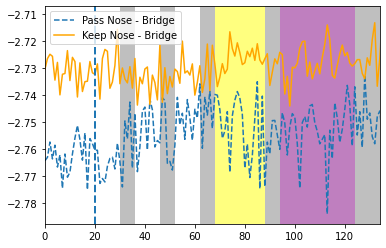

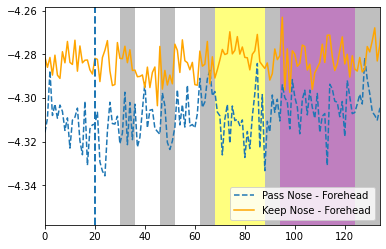

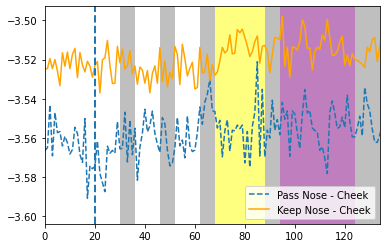

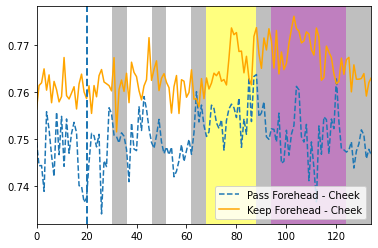

In [86]:
ntemp = np.array(pass_nose_roi_data)-np.array(pass_room_temp_data)
btemp = np.array(pass_bridge_roi_data)-np.array(pass_room_temp_data)
ftemp = np.array(pass_forehead_roi_data)-np.array(pass_room_temp_data)
ltemp = np.array(pass_left_cheek_roi_data)-np.array(pass_room_temp_data)
rtemp = np.array(pass_right_cheek_roi_data)-np.array(pass_room_temp_data)
ctemp = (ltemp+rtemp)/2


plt.plot(np.mean(ntemp,axis=0)-np.mean(btemp,axis=0),linestyle='--',label='Pass Nose - Bridge')
plt.legend()
# plt.twinx()
ntemp = np.array(keep_nose_roi_data)-np.array(keep_room_temp_data)
btemp = np.array(keep_bridge_roi_data)-np.array(keep_room_temp_data)
ftemp = np.array(keep_forehead_roi_data)-np.array(keep_room_temp_data)
ltemp = np.array(keep_left_cheek_roi_data)-np.array(keep_room_temp_data)
rtemp = np.array(keep_right_cheek_roi_data)-np.array(keep_room_temp_data)
ctemp = (ltemp+rtemp)/2

plt.plot(np.mean(ntemp,axis=0)-np.mean(btemp,axis=0),color='orange',label='Keep Nose - Bridge')
plt.legend()
plt.axvline(x=20,linestyle = '--',lw=2)
plt.axvspan(30,36,color = 'gray', alpha=0.5, lw=0)
plt.axvspan(46,52,color = 'gray', alpha=0.5, lw=0)
plt.axvspan(62,68,color = 'gray', alpha=0.5, lw=0)
plt.axvspan(88,94,color = 'gray', alpha=0.5, lw=0)
plt.axvspan(124,134,color = 'gray', alpha=0.5, lw=0)

plt.axvspan(20,30,color = 'white', alpha=0.5, lw=0)
plt.axvspan(36,46,color = 'white', alpha=0.5, lw=0)
plt.axvspan(52,62,color = 'white', alpha=0.5, lw=0,label='Feature')
plt.axvspan(68,88,color = 'yellow', alpha=0.5, lw=0,label = 'Response Window')
plt.axvspan(94,124,color = 'purple', alpha=0.5, lw=0,label = 'PK Window')
plt.xlim(0,134)
plt.show()


ntemp = np.array(pass_nose_roi_data)-np.array(pass_room_temp_data)
btemp = np.array(pass_bridge_roi_data)-np.array(pass_room_temp_data)
ftemp = np.array(pass_forehead_roi_data)-np.array(pass_room_temp_data)
ltemp = np.array(pass_left_cheek_roi_data)-np.array(pass_room_temp_data)
rtemp = np.array(pass_right_cheek_roi_data)-np.array(pass_room_temp_data)
ctemp = (ltemp+rtemp)/2


plt.plot(np.mean(ntemp,axis=0)-np.mean(ftemp,axis=0),linestyle='--',label='Pass Nose - Forehead')
plt.legend()
# plt.twinx()
ntemp = np.array(keep_nose_roi_data)-np.array(keep_room_temp_data)
btemp = np.array(keep_bridge_roi_data)-np.array(keep_room_temp_data)
ftemp = np.array(keep_forehead_roi_data)-np.array(keep_room_temp_data)
ltemp = np.array(keep_left_cheek_roi_data)-np.array(keep_room_temp_data)
rtemp = np.array(keep_right_cheek_roi_data)-np.array(keep_room_temp_data)
ctemp = (ltemp+rtemp)/2

plt.plot(np.mean(ntemp,axis=0)-np.mean(ftemp,axis=0),color='orange',label='Keep Nose - Forehead')
plt.legend()
plt.axvline(x=20,linestyle = '--',lw=2)
plt.axvspan(30,36,color = 'gray', alpha=0.5, lw=0)
plt.axvspan(46,52,color = 'gray', alpha=0.5, lw=0)
plt.axvspan(62,68,color = 'gray', alpha=0.5, lw=0)
plt.axvspan(88,94,color = 'gray', alpha=0.5, lw=0)
plt.axvspan(124,134,color = 'gray', alpha=0.5, lw=0)

plt.axvspan(20,30,color = 'white', alpha=0.5, lw=0)
plt.axvspan(36,46,color = 'white', alpha=0.5, lw=0)
plt.axvspan(52,62,color = 'white', alpha=0.5, lw=0,label='Feature')
plt.axvspan(68,88,color = 'yellow', alpha=0.5, lw=0,label = 'Response Window')
plt.axvspan(94,124,color = 'purple', alpha=0.5, lw=0,label = 'PK Window')
plt.xlim(0,134)
plt.show()

ntemp = np.array(pass_nose_roi_data)-np.array(pass_room_temp_data)
btemp = np.array(pass_bridge_roi_data)-np.array(pass_room_temp_data)
ftemp = np.array(pass_forehead_roi_data)-np.array(pass_room_temp_data)
ltemp = np.array(pass_left_cheek_roi_data)-np.array(pass_room_temp_data)
rtemp = np.array(pass_right_cheek_roi_data)-np.array(pass_room_temp_data)
ctemp = (ltemp+rtemp)/2


plt.plot(np.mean(ntemp,axis=0)-np.mean(ctemp,axis=0),linestyle='--',label='Pass Nose - Cheek')
plt.legend()
# plt.twinx()
ntemp = np.array(keep_nose_roi_data)-np.array(keep_room_temp_data)
btemp = np.array(keep_bridge_roi_data)-np.array(keep_room_temp_data)
ftemp = np.array(keep_forehead_roi_data)-np.array(keep_room_temp_data)
ltemp = np.array(keep_left_cheek_roi_data)-np.array(keep_room_temp_data)
rtemp = np.array(keep_right_cheek_roi_data)-np.array(keep_room_temp_data)
ctemp = (ltemp+rtemp)/2

plt.plot(np.mean(ntemp,axis=0)-np.mean(ctemp,axis=0),color='orange',label='Keep Nose - Cheek')
plt.legend()
plt.axvline(x=20,linestyle = '--',lw=2)
plt.axvspan(30,36,color = 'gray', alpha=0.5, lw=0)
plt.axvspan(46,52,color = 'gray', alpha=0.5, lw=0)
plt.axvspan(62,68,color = 'gray', alpha=0.5, lw=0)
plt.axvspan(88,94,color = 'gray', alpha=0.5, lw=0)
plt.axvspan(124,134,color = 'gray', alpha=0.5, lw=0)

plt.axvspan(20,30,color = 'white', alpha=0.5, lw=0)
plt.axvspan(36,46,color = 'white', alpha=0.5, lw=0)
plt.axvspan(52,62,color = 'white', alpha=0.5, lw=0,label='Feature')
plt.axvspan(68,88,color = 'yellow', alpha=0.5, lw=0,label = 'Response Window')
plt.axvspan(94,124,color = 'purple', alpha=0.5, lw=0,label = 'PK Window')
plt.xlim(0,134)
plt.show()

ntemp = np.array(pass_nose_roi_data)-np.array(pass_room_temp_data)
btemp = np.array(pass_bridge_roi_data)-np.array(pass_room_temp_data)
ftemp = np.array(pass_forehead_roi_data)-np.array(pass_room_temp_data)
ltemp = np.array(pass_left_cheek_roi_data)-np.array(pass_room_temp_data)
rtemp = np.array(pass_right_cheek_roi_data)-np.array(pass_room_temp_data)
ctemp = (ltemp+rtemp)/2


plt.plot(np.mean(ftemp,axis=0)-np.mean(ctemp,axis=0),linestyle='--',label='Pass Forehead - Cheek')
plt.legend()
# plt.twinx()
ntemp = np.array(keep_nose_roi_data)-np.array(keep_room_temp_data)
btemp = np.array(keep_bridge_roi_data)-np.array(keep_room_temp_data)
ftemp = np.array(keep_forehead_roi_data)-np.array(keep_room_temp_data)
ltemp = np.array(keep_left_cheek_roi_data)-np.array(keep_room_temp_data)
rtemp = np.array(keep_right_cheek_roi_data)-np.array(keep_room_temp_data)
ctemp = (ltemp+rtemp)/2

plt.plot(np.mean(ftemp,axis=0)-np.mean(ctemp,axis=0),color='orange',label='Keep Forehead - Cheek')
plt.legend()
plt.axvline(x=20,linestyle = '--',lw=2)
plt.axvspan(30,36,color = 'gray', alpha=0.5, lw=0)
plt.axvspan(46,52,color = 'gray', alpha=0.5, lw=0)
plt.axvspan(62,68,color = 'gray', alpha=0.5, lw=0)
plt.axvspan(88,94,color = 'gray', alpha=0.5, lw=0)
plt.axvspan(124,134,color = 'gray', alpha=0.5, lw=0)

plt.axvspan(20,30,color = 'white', alpha=0.5, lw=0)
plt.axvspan(36,46,color = 'white', alpha=0.5, lw=0)
plt.axvspan(52,62,color = 'white', alpha=0.5, lw=0,label='Feature')
plt.axvspan(68,88,color = 'yellow', alpha=0.5, lw=0,label = 'Response Window')
plt.axvspan(94,124,color = 'purple', alpha=0.5, lw=0,label = 'PK Window')
plt.xlim(0,134)
plt.show()
##############################

# btemp = np.array(pass_bridge_roi_data)-np.array(pass_room_temp_data)
# plt.plot((np.mean(btemp,axis=0)-np.mean(btemp,axis=0)[10]).T,linestyle='--',label='Pass Bridge')
# plt.legend()
# # plt.twinx()
# btemp = np.array(keep_bridge_roi_data)-np.array(keep_room_temp_data)
# plt.plot((np.mean(btemp,axis=0)-np.mean(btemp,axis=0)[10]).T,color='orange',label='Keep Bridge')
# plt.xlim(0,130)
# plt.legend()
# plt.axvline(x=10,linestyle = '--',lw=2)
# plt.axvspan(20,26,color = 'gray', alpha=0.5, lw=0)
# plt.axvspan(36,42,color = 'gray', alpha=0.5, lw=0)
# plt.axvspan(52,58,color = 'gray', alpha=0.5, lw=0)
# plt.axvspan(78,84,color = 'gray', alpha=0.5, lw=0)
# plt.axvspan(120,130,color = 'gray', alpha=0.5, lw=0)

# plt.axvspan(10,20,color = 'white', alpha=0.5, lw=0)
# plt.axvspan(26,36,color = 'white', alpha=0.5, lw=0)
# plt.axvspan(42,52,color = 'white', alpha=0.5, lw=0,label='Feature')
# plt.axvspan(58,78,color = 'yellow', alpha=0.5, lw=0,label = 'Response Window')
# plt.axvspan(84,120,color = 'purple', alpha=0.5, lw=0,label = 'PK Window')
# plt.show()

# ftemp = np.array(pass_forehead_roi_data)-np.array(pass_room_temp_data)
# plt.plot((np.mean(ftemp,axis=0)-np.mean(ftemp,axis=0)[10]).T,linestyle='--',label='Pass Forehead')
# plt.legend()
# # plt.twinx()
# ftemp = np.array(keep_forehead_roi_data)-np.array(keep_room_temp_data)
# plt.plot((np.mean(ftemp,axis=0)-np.mean(ftemp,axis=0)[10]).T,color='orange',label='Keep Forehead')
# plt.xlim(0,130)
# plt.legend()
# plt.axvline(x=10,linestyle = '--',lw=2)
# plt.axvspan(20,26,color = 'gray', alpha=0.5, lw=0)
# plt.axvspan(36,42,color = 'gray', alpha=0.5, lw=0)
# plt.axvspan(52,58,color = 'gray', alpha=0.5, lw=0)
# plt.axvspan(78,84,color = 'gray', alpha=0.5, lw=0)
# plt.axvspan(120,130,color = 'gray', alpha=0.5, lw=0)

# plt.axvspan(10,20,color = 'white', alpha=0.5, lw=0)
# plt.axvspan(26,36,color = 'white', alpha=0.5, lw=0)
# plt.axvspan(42,52,color = 'white', alpha=0.5, lw=0,label='Feature')
# plt.axvspan(58,78,color = 'yellow', alpha=0.5, lw=0,label = 'Response Window')
# plt.axvspan(84,120,color = 'purple', alpha=0.5, lw=0,label = 'PK Window')
# plt.show()

# ltemp = np.array(pass_left_cheek_roi_data)-np.array(pass_room_temp_data)
# plt.plot((np.mean(ltemp,axis=0)-np.mean(ltemp,axis=0)[10]).T,linestyle='--',label='Pass Left Cheek')
# plt.legend()
# # plt.twinx()
# ltemp = np.array(keep_left_cheek_roi_data)-np.array(keep_room_temp_data)
# plt.plot((np.mean(ltemp,axis=0)-np.mean(ltemp,axis=0)[10]).T,color='orange',label='Keep Left Cheek')
# plt.xlim(0,130)
# plt.legend()
# plt.axvline(x=10,linestyle = '--',lw=2)
# plt.axvspan(20,26,color = 'gray', alpha=0.5, lw=0)
# plt.axvspan(36,42,color = 'gray', alpha=0.5, lw=0)
# plt.axvspan(52,58,color = 'gray', alpha=0.5, lw=0)
# plt.axvspan(78,84,color = 'gray', alpha=0.5, lw=0)
# plt.axvspan(120,130,color = 'gray', alpha=0.5, lw=0)

# plt.axvspan(10,20,color = 'white', alpha=0.5, lw=0)
# plt.axvspan(26,36,color = 'white', alpha=0.5, lw=0)
# plt.axvspan(42,52,color = 'white', alpha=0.5, lw=0,label='Feature')
# plt.axvspan(58,78,color = 'yellow', alpha=0.5, lw=0,label = 'Response Window')
# plt.axvspan(84,120,color = 'purple', alpha=0.5, lw=0,label = 'PK Window')
# plt.show()

# rtemp = np.array(pass_right_cheek_roi_data)-np.array(pass_room_temp_data)
# plt.plot((np.mean(rtemp,axis=0)-np.mean(rtemp,axis=0)[10]).T,linestyle='--',label='Pass Right Cheek')
# plt.legend()
# # plt.twinx()
# rtemp = np.array(keep_right_cheek_roi_data)-np.array(keep_room_temp_data)
# plt.plot((np.mean(rtemp,axis=0)-np.mean(rtemp,axis=0)[10]).T,color='orange',label='Keep Right Cheek')
# plt.xlim(0,130)
# plt.legend()
# plt.axvline(x=10,linestyle = '--',lw=2)
# plt.axvspan(20,26,color = 'gray', alpha=0.5, lw=0)
# plt.axvspan(36,42,color = 'gray', alpha=0.5, lw=0)
# plt.axvspan(52,58,color = 'gray', alpha=0.5, lw=0)
# plt.axvspan(78,84,color = 'gray', alpha=0.5, lw=0)
# plt.axvspan(120,130,color = 'gray', alpha=0.5, lw=0)

# plt.axvspan(10,20,color = 'white', alpha=0.5, lw=0)
# plt.axvspan(26,36,color = 'white', alpha=0.5, lw=0)
# plt.axvspan(42,52,color = 'white', alpha=0.5, lw=0,label='Feature')
# plt.axvspan(58,78,color = 'yellow', alpha=0.5, lw=0,label = 'Response Window')
# plt.axvspan(84,120,color = 'purple', alpha=0.5, lw=0,label = 'PK Window')
# plt.show()

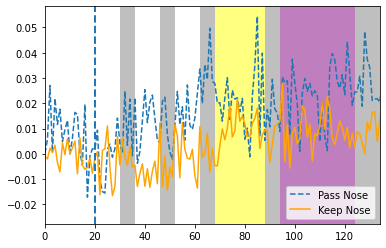

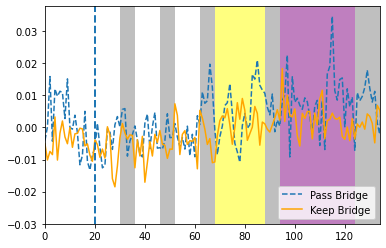

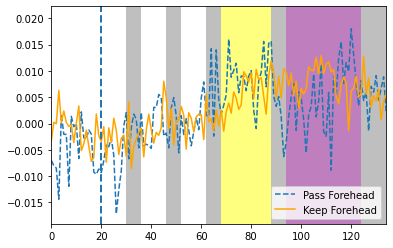

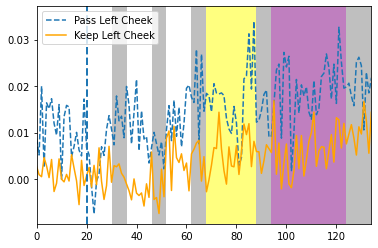

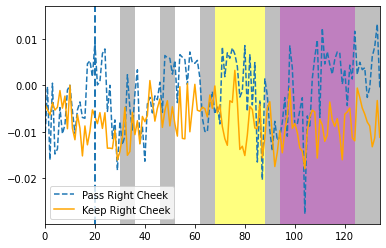

In [87]:
ntemp = np.array(pass_nose_roi_data)-np.array(pass_room_temp_data)
plt.plot((np.mean(ntemp,axis=0)-np.mean(ntemp,axis=0)[10]).T,linestyle='--',label='Pass Nose')
plt.legend()
# plt.twinx()
ntemp = np.array(keep_nose_roi_data)-np.array(keep_room_temp_data)
plt.plot((np.mean(ntemp,axis=0)-np.mean(ntemp,axis=0)[10]).T,color='orange',label='Keep Nose')
plt.legend()
plt.axvline(x=20,linestyle = '--',lw=2)
plt.axvspan(30,36,color = 'gray', alpha=0.5, lw=0)
plt.axvspan(46,52,color = 'gray', alpha=0.5, lw=0)
plt.axvspan(62,68,color = 'gray', alpha=0.5, lw=0)
plt.axvspan(88,94,color = 'gray', alpha=0.5, lw=0)
plt.axvspan(124,134,color = 'gray', alpha=0.5, lw=0)

plt.axvspan(20,30,color = 'white', alpha=0.5, lw=0)
plt.axvspan(36,46,color = 'white', alpha=0.5, lw=0)
plt.axvspan(52,62,color = 'white', alpha=0.5, lw=0,label='Feature')
plt.axvspan(68,88,color = 'yellow', alpha=0.5, lw=0,label = 'Response Window')
plt.axvspan(94,124,color = 'purple', alpha=0.5, lw=0,label = 'PK Window')
plt.xlim(0,134)
plt.show()

btemp = np.array(pass_bridge_roi_data)-np.array(pass_room_temp_data)
plt.plot((np.mean(btemp,axis=0)-np.mean(btemp,axis=0)[10]).T,linestyle='--',label='Pass Bridge')
plt.legend()
# plt.twinx()
btemp = np.array(keep_bridge_roi_data)-np.array(keep_room_temp_data)
plt.plot((np.mean(btemp,axis=0)-np.mean(btemp,axis=0)[10]).T,color='orange',label='Keep Bridge')
plt.legend()
plt.axvline(x=20,linestyle = '--',lw=2)
plt.axvspan(30,36,color = 'gray', alpha=0.5, lw=0)
plt.axvspan(46,52,color = 'gray', alpha=0.5, lw=0)
plt.axvspan(62,68,color = 'gray', alpha=0.5, lw=0)
plt.axvspan(88,94,color = 'gray', alpha=0.5, lw=0)
plt.axvspan(124,134,color = 'gray', alpha=0.5, lw=0)

plt.axvspan(20,30,color = 'white', alpha=0.5, lw=0)
plt.axvspan(36,46,color = 'white', alpha=0.5, lw=0)
plt.axvspan(52,62,color = 'white', alpha=0.5, lw=0,label='Feature')
plt.axvspan(68,88,color = 'yellow', alpha=0.5, lw=0,label = 'Response Window')
plt.axvspan(94,124,color = 'purple', alpha=0.5, lw=0,label = 'PK Window')
plt.xlim(0,134)
plt.show()

ftemp = np.array(pass_forehead_roi_data)-np.array(pass_room_temp_data)
plt.plot((np.mean(ftemp,axis=0)-np.mean(ftemp,axis=0)[10]).T,linestyle='--',label='Pass Forehead')
plt.legend()
# plt.twinx()
ftemp = np.array(keep_forehead_roi_data)-np.array(keep_room_temp_data)
plt.plot((np.mean(ftemp,axis=0)-np.mean(ftemp,axis=0)[10]).T,color='orange',label='Keep Forehead')
plt.legend()
plt.axvline(x=20,linestyle = '--',lw=2)
plt.axvspan(30,36,color = 'gray', alpha=0.5, lw=0)
plt.axvspan(46,52,color = 'gray', alpha=0.5, lw=0)
plt.axvspan(62,68,color = 'gray', alpha=0.5, lw=0)
plt.axvspan(88,94,color = 'gray', alpha=0.5, lw=0)
plt.axvspan(124,134,color = 'gray', alpha=0.5, lw=0)

plt.axvspan(20,30,color = 'white', alpha=0.5, lw=0)
plt.axvspan(36,46,color = 'white', alpha=0.5, lw=0)
plt.axvspan(52,62,color = 'white', alpha=0.5, lw=0,label='Feature')
plt.axvspan(68,88,color = 'yellow', alpha=0.5, lw=0,label = 'Response Window')
plt.axvspan(94,124,color = 'purple', alpha=0.5, lw=0,label = 'PK Window')
plt.xlim(0,134)
plt.show()

ltemp = np.array(pass_left_cheek_roi_data)-np.array(pass_room_temp_data)
plt.plot((np.mean(ltemp,axis=0)-np.mean(ltemp,axis=0)[10]).T,linestyle='--',label='Pass Left Cheek')
plt.legend()
# plt.twinx()
ltemp = np.array(keep_left_cheek_roi_data)-np.array(keep_room_temp_data)
plt.plot((np.mean(ltemp,axis=0)-np.mean(ltemp,axis=0)[10]).T,color='orange',label='Keep Left Cheek')
plt.legend()
plt.axvline(x=20,linestyle = '--',lw=2)
plt.axvspan(30,36,color = 'gray', alpha=0.5, lw=0)
plt.axvspan(46,52,color = 'gray', alpha=0.5, lw=0)
plt.axvspan(62,68,color = 'gray', alpha=0.5, lw=0)
plt.axvspan(88,94,color = 'gray', alpha=0.5, lw=0)
plt.axvspan(124,134,color = 'gray', alpha=0.5, lw=0)

plt.axvspan(20,30,color = 'white', alpha=0.5, lw=0)
plt.axvspan(36,46,color = 'white', alpha=0.5, lw=0)
plt.axvspan(52,62,color = 'white', alpha=0.5, lw=0,label='Feature')
plt.axvspan(68,88,color = 'yellow', alpha=0.5, lw=0,label = 'Response Window')
plt.axvspan(94,124,color = 'purple', alpha=0.5, lw=0,label = 'PK Window')
plt.xlim(0,134)
plt.show()

rtemp = np.array(pass_right_cheek_roi_data)-np.array(pass_room_temp_data)
plt.plot((np.mean(rtemp,axis=0)-np.mean(rtemp,axis=0)[10]).T,linestyle='--',label='Pass Right Cheek')
plt.legend()
# plt.twinx()
rtemp = np.array(keep_right_cheek_roi_data)-np.array(keep_room_temp_data)
plt.plot((np.mean(rtemp,axis=0)-np.mean(rtemp,axis=0)[10]).T,color='orange',label='Keep Right Cheek')
plt.legend()
plt.axvline(x=20,linestyle = '--',lw=2)
plt.axvspan(30,36,color = 'gray', alpha=0.5, lw=0)
plt.axvspan(46,52,color = 'gray', alpha=0.5, lw=0)
plt.axvspan(62,68,color = 'gray', alpha=0.5, lw=0)
plt.axvspan(88,94,color = 'gray', alpha=0.5, lw=0)
plt.axvspan(124,134,color = 'gray', alpha=0.5, lw=0)

plt.axvspan(20,30,color = 'white', alpha=0.5, lw=0)
plt.axvspan(36,46,color = 'white', alpha=0.5, lw=0)
plt.axvspan(52,62,color = 'white', alpha=0.5, lw=0,label='Feature')
plt.axvspan(68,88,color = 'yellow', alpha=0.5, lw=0,label = 'Response Window')
plt.axvspan(94,124,color = 'purple', alpha=0.5, lw=0,label = 'PK Window')
plt.xlim(0,134)
plt.show()

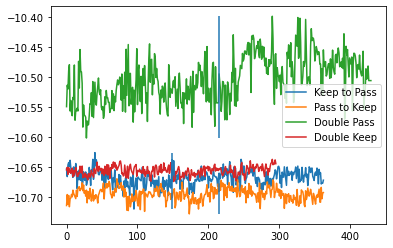

-0.006143611111111724
-0.0010289609053497628
0.03125902777777867
0.008095885744234366


((20, 363), (27, 363), (2, 430), (53, 296))

In [88]:
doubleKeep = []
doublePass = []
passKeep = []
keepPass = []
keep_target_arr = keep_right_cheek_roi_data
pass_target_arr = pass_right_cheek_roi_data
for i in zip(np.array(passTrialInd)[::2],np.array(passTrialInd)[1::2]):
    if i[1]-i[0] == 1:
        firstind = np.where(passTrialInd == i[0])[0][0]
        secondind = np.where(passTrialInd == i[1])[0][0]
        ele = np.concatenate(((np.array(pass_target_arr)-np.array(pass_room_temp_data))[firstind],(np.array(pass_target_arr)-np.array(pass_room_temp_data))[secondind]))
        doublePass.append(ele)
    else:
        firstind = np.where(passTrialInd == i[0])[0][0]
        secondind = np.where(keepTrialInd == i[0]+1)[0][0]
        ele = np.concatenate(((np.array(pass_target_arr)-np.array(pass_room_temp_data))[firstind],(np.array(keep_target_arr)-np.array(keep_room_temp_data))[secondind]))
        passKeep.append(ele)

for i in zip(np.array(keepTrialInd)[::2],np.array(keepTrialInd)[1::2]):
    if i[1]-i[0] == 1:
        firstind = np.where(keepTrialInd == i[0])[0][0]
        secondind = np.where(keepTrialInd == i[1])[0][0]
        ele = np.concatenate(((np.array(keep_target_arr)-np.array(keep_room_temp_data))[firstind],(np.array(keep_target_arr)-np.array(keep_room_temp_data))[secondind]))
        doubleKeep.append(ele)
    else:
        firstind = np.where(keepTrialInd == i[0])[0][0]
        secondind = np.where(passTrialInd == i[0]+1)[0][0]
        ele = np.concatenate(((np.array(keep_target_arr)-np.array(keep_room_temp_data))[firstind],(np.array(pass_target_arr)-np.array(pass_room_temp_data))[secondind]))
        keepPass.append(ele)
doubleKeep = np.array(doubleKeep)
doublePass = np.array(doublePass)
passKeep = np.array(passKeep)
keepPass = np.array(keepPass)

plt.plot(np.mean(keepPass,axis=0),label='Keep to Pass')
plt.plot(np.mean(passKeep,axis=0),label = 'Pass to Keep')
plt.plot(np.mean(doublePass,axis=0),label = 'Double Pass')
plt.plot(np.mean(doubleKeep,axis=0),label = 'Double Keep')
plt.legend()
plt.vlines([148,215,215,148]
           ,[np.mean(keepPass,axis=0).min(),np.mean(passKeep,axis=0).min(),np.mean(doublePass,axis=0).min(),np.mean(doubleKeep,axis=0).min()]
           ,[np.mean(keepPass,axis=0).max(),np.mean(passKeep,axis=0).max(),np.mean(doublePass,axis=0).max(),np.mean(doubleKeep,axis=0).max()])
plt.show()
for i in [np.mean(keepPass,axis=0),np.mean(passKeep,axis=0),np.mean(doublePass,axis=0),np.mean(doubleKeep,axis=0)]:
    print(np.mean(i[-20:])-np.mean(i[:20]))
keepPass.shape,passKeep.shape,doublePass.shape,doubleKeep.shape

In [160]:
from hdf5storage import savemat
outdict = {}
outdict['processed_pass_nose'] = passNoseTrials
outdict['processed_pass_forehead'] = passForeheadTrials
outdict['processed_pass_left_cheek'] = passLeftTrials
outdict['processed_pass_right_ceek'] = passRightTrials
outdict['processed_keep_nose'] = keepNoseTrials
outdict['processed_keep_forehead'] = keepForeheadTrials
outdict['processed_keep_left_cheek'] = keepLeftTrials
outdict['processed_keep_right_cheek'] = keepRightTrials
outdict['keep_invalid_trials'] = keepInvalidTrials
outdict['pass_invalif_trials'] = passInvalidTrials
outdict['keep_trial_ind'] = validKeepTrialInd 
outdict['pass_trial_ind'] = validPassTrialInd
outdict['full_nose_data'] = full_nose_roi_data
outdict['full_bridge_data'] = full_bridge_roi_data
outdict['full_forehead_data'] = full_forehead_roi_data
outdict['full_left_cheek_data'] = full_left_cheek_roi_data
outdict['full_right_cheek_data'] = full_right_cheek_roi_data
outdict['full_room_temp_data'] = full_room_temp_data
outdict['pass_nose_data'] = pass_nose_roi_data
outdict['pass_bridge_data'] = pass_bridge_roi_data
outdict['pass_forehead_data'] = pass_forehead_roi_data
outdict['pass_left_cheek_data'] = pass_left_cheek_roi_data
outdict['pass_right_cheek_data'] = pass_right_cheek_roi_data
outdict['pass_room_temp_data'] = pass_room_temp_data
outdict['keep_nose_data'] = keep_nose_roi_data
outdict['keep_bridge_data'] = keep_bridge_roi_data
outdict['keep_forehead_data'] = keep_forehead_roi_data
outdict['keep_left_cheek_data'] = keep_left_cheek_roi_data
outdict['keep_right_cheek_data'] = keep_right_cheek_roi_data
outdict['keep_room_temp_data'] = keep_room_temp_data
outpath = f'../data/Subject{sub}/{sub}Session{ses}/Subject{sub}_roi_data.hdf'
savemat(outpath,outdict,store_python_metadata=True)

In [669]:
pwd

'/home/shane/IncPredExpNew/analysis'

In [ ]:
a = (full_room_temp_data + 100) * 10
b = (a - 1000) / 10
a = a / 10 - 100
b[0],a[0]